In [165]:
%load_ext autoreload
%autoreload 1
%aimport AnalysisUtils
%aimport genCrossCor
%aimport genMapsfromCor
%aimport run_euclidlike_analysis
%matplotlib inline
# %matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
print 5

5


In [167]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot #to have two axis labels
import mpl_toolkits.axisartist as AA #to have two axis labels
from itertools import permutations, chain, izip_longest
from scipy.optimize import leastsq
import scipy.stats as stats
from operator import itemgetter
from matplotlib.colors import LogNorm
import error_ellipse as ee

In [168]:
import MapParams as mp
import CosmParams as cp #[NJW 160606]
import ClRunUtils as clu
import genCrossCor as gcc
import genMapsfromCor as gmc
import AnalysisUtils as au
import mapdef_utils as mdu
import run_euclidlike_analysis as runeuc
import time
import datetime
import healpy as hp
import os
import itertools
import copy

In [169]:
def getCombos(ls, size=None, contains=False):
    """get list of tuples of all possible combinations of elements of input list ls. If size specified, limits combos to length==size. If contains, limit to combos with contains argument present"""
    if size:
        result = list(itertools.combinations(ls, size))
    else:
        a = []
        for L in range(0, len(ls)+1): #all possible combo lengths
            for subset in itertools.combinations(ls, L):
                if size==None or len(subset)==size:
                    a.append(subset)
        result = a[1:] #first element is blank tuple, so drop
    if contains:
        result = [combo for combo in result if contains in combo] #only return combos that have "contains" in it
    return result

def strp_str(bintag, to_strip='_bin0'):
    """strip '_bin0' from a bintag string"""
    return bintag[:bintag.rfind(to_strip)]

def m_binarr_to_labels(maptags,to_strip='_bin0', to_add=''):
        """[maptagA, maptagB,...,maptagN] --> 'maptagA+maptagB+...+maptagN', with to_strip (string) removed from end of each maptag.
        to_add argument is appended to end of full label"""
        return '+'.join([strp_str(mt, to_strip=to_strip) for mt in maptags])+to_add
def getShapeStr(shape,lmin,lmax,width=False):
    if shape=='g':
        assert width!=False
        shapestr='g{2:d}_{0:d}l{1:d}'.format(lmin,lmax,int(width))
    elif shape=='l2':
        shapestr='l2_{0:d}l{1:d}'.format(lmin,lmax)
#             if shapelist[s]=='g':
#                 shapestr=r'$C_{{\ell}}^{{\rm cal}}\propto e^{{-(\ell/{0:.0f})^2}}$'.format(widthlist[s],lminlist[s],lmaxlist[s])
#                 #shapestr=r'$C_{{\ell}}^{{\rm cal}}\propto e^{{-(\ell/{0:.0f})^2}}$ for ${1:d}\leq \ell \leq {2:d}$'.format(widthlist[s],lminlist[s],lmaxlist[s])
#                 #shapestr='g{2:d}_{0:d}l{1:d}'.format(lminlist[s],lmaxlist[s],int(widthlist[s]))
#             elif shapelist[s]=='l2':
#                 shapestr=r'$C_{{\ell}}^{{\rm cal}}\propto \ell^{{-2}}$'.format(lminlist[s],lmaxlist[s])
#                 #shapestr=r'$C_{{\ell}}^{{\rm cal}}\propto \ell^{{-2}}$ for ${0:d}\leq \ell \leq {1:d}$'.format(lminlist[s],lmaxlist[s])
    else: raise ValueError('please enter valid shape string: {"g", "l2"}')
    return shapestr

In [170]:
#The following are all just "multi" versions of the original functions in run_euclidlike.py. They are not very different - indeed some may be
#unnecessary repeats, but I copied the functions over and tweaked so as to not mess up the original functions.
def multi_depthtest_get_binmaps(z0vals=np.array([.3,.6,.7,.8]),includeisw=True, nbar='default'):
    tagend = ['']*len(z0vals) #ending to tack on to each survey tag -- default to nothing
    if nbar!='default':
        surveys=[mdu.get_Euclidlike_SurveyType(z0=z0,onebin=True,nbar=nbar,tag='eucz{0:02d}'.format(int(10*z0))+tagend[i]) for i,z0 in enumerate(z0vals)]
    else: surveys=[mdu.get_Euclidlike_SurveyType(z0=z0,onebin=True,tag='eucz{0:02d}'.format(int(10*z0))+tagend[i]) for i,z0 in enumerate(z0vals)]
    bins=[s.binmaps[0] for s in surveys] #all surveys have only one bin
    if includeisw:
        iswmaptype=mdu.get_fullISW_MapType(zmax=15)
        iswbins=iswmaptype.binmaps
        bins=iswbins+bins
    return bins

def multi_get_Cl(justread=True,z0vals = np.array([.3,.6,.7,.8]),nbar='default', outtag=''):
    #[added outtag to allow easy spec of different output directory]
    #gets cls for all pairs
    bins=multi_depthtest_get_binmaps(z0vals, nbar=nbar)
    zmax=max(m.zmax for m in bins) #get highest max z of all the binmaps
    rundat = clu.ClRunData(tag='depthtest',rundir='output/'+outtag+'/',lmax=95,zmax=zmax) #keep info like lmax, output dir, tag, zmax, etc. and other general cl information we'll need for all maps
    return gcc.getCl(bins,rundat,dopairs=['all'],DoNotOverwrite=justread)

# same as depthtest_get_reclist, but don't define includeglm so uses all bins instead of limiting to the current bin (i.e. multisurvey)
def multi_depthtest_get_reclist(z0vals=np.array([.3,.6,.7,.8]), multi = False, nbar='default',minl_forrec=2):
    """get reclist for single or multiple depth maps. z0vals is list of z0 depths, multi is list of indices for which z0s to combine
    (tuple if multiple, e.g. multi=[0,1,2,(0,2)] returns reclist of length 4, with recons of 1st three single z0val recons and one recon with 1st and 3rd z0 maps."""
    if multi == False:
        multi = range(z0vals) + [(0,1)]
    bins=multi_depthtest_get_binmaps(z0vals,nbar=nbar) #list of bins, since each map is only one bin for depth test
    binlist=[] #bins but without isw_bin0, so corresponds to input z0vals
    for b in bins:
        if b.tag!='isw_bin0':
            binlist.append([b])
        #print b.tag   #make list of lists, with each sublist a list of the bins in the map to use for recreation (only 1 each for now)
    Nrec = len(multi)
    reclist = [0]* Nrec
    for i,irec in enumerate(multi):
        includeglm=[]
        inmaptag = ''
        if type(irec) == int:
            irec = (irec,) #set to tuple so we can reuse upcoming for loop code
            mtag = ''
        else: mtag = '+'
        for m in irec: #for each survey in the list of surveys to use for recon
            for b in binlist[m]: #for each bin in the survey
                bintag=b.tag
                includeglm.append(bintag)
            inmaptag += mtag + bintag[:bintag.rfind('_bin')] #if single map, will be the standard bintag (without '_bin[X]'), if multi will be 'bintag0+bintag1'
        reclist[i] = au.RecData(includeglm=includeglm, inmaptag=inmaptag, minl_forrec=minl_forrec)
#         print (irec,includeglm, inmaptag)
    return reclist

#use cldat to generate glm, alm, and maps; saves maps but not alm
#   does isw reconstruction automatically
def multi_depthtest_get_glm_and_rec(cldat=False, Nreal=1,z0vals=np.array([.3,.6,.7,.8]),minreal=0,justgetrho=0,dorell=0,
                                    dorho=1,dos=1,dochisq=1,dochisqell=0, multi=False, outtag='', nbar='default'):
    t0=time.time()
    if cldat==False:
        if multi==False:
            if nbar!='default': print "Warning, using default nbar instead of passed value!"
            cldat = depthtest_get_Cl(justread=True,z0vals=z0vals,outtag=outtag) #this isn't setup to take nbar yet
        else: cldat = multi_get_Cl(justread=True,z0vals=z0vals,outtag=outtag,nbar=nbar)
    makeplots=Nreal==1
    rlzns=np.arange(minreal,minreal+Nreal)
    if multi:
        reclist = multi_depthtest_get_reclist(z0vals, multi=multi) #try to use all the depth tests in recon
    else: reclist=runeuc.depthtest_get_reclist(z0vals)
    au.getmaps_fromCl(cldat,rlzns=rlzns,reclist=reclist,justgetrho=justgetrho,dorell=dorell,dorho=dorho,dos=dos,
                      dochisq=dochisq,dochisqell=dochisqell)
    t1=time.time()
    print "total time for Nreal",Nreal,": ",t1-t0,'sec'
    
# get expectation values of rho or s, choose variable via varname
def multi_depthtest_get_expected_rho(cldat=False,reclist=False,z0vals=np.array([0.3,0.6,0.7,0.8]),nbar='default',varname='rho',outtag=''):
    if cldat==False: cldat=multi_get_Cl(justread=True, z0vals=z0vals, nbar=nbar, outtag=outtag)
    if reclist==False:
        multi = getCombos(range(len(z0vals))) #by default, get for all possible map combos
        reclist=multi_depthtest_get_reclist(z0vals=z0vals,multi=multi,nbar=nbar)
    rhopred=np.zeros_like(reclist)
    for i,rec in enumerate(reclist):
        rhopred[i] = au.compute_rho_fromcl(cldat,rec,varname=varname)
    return rhopred

# # g
# def depthtest_get_expected_rell(z0vals=np.array([0.3,0.6,0.7,0.8]),varname='rell'):
#     """et expectation values of r_ell (correlation b/n multipole modes of true and reconstructed ISW maps).
#     [Nrec]"""
#     cldat=depthtest_get_Cl(z0vals=z0vals)
#     reclist=depthtest_get_reclist(z0vals)
#     rellpred=[]
#     for i in xrange(z0vals.size):
#         rellpred.append(au.compute_rell_fromcl(cldat,reclist[i],varname=varname))
#     rellpred=np.array(rellpred)#[Nrec,Nell]
#     #print rellpred
#     return rellpred

In [171]:
class MRecStats(object):
    """Stores reconstruction info for multiple maps, e.g. <rho> and <s> for multiple as well as the individual maps going into reconstruction.
    self.[var]_rat is ratio <[var]_multi>/(<[var]_A><[var]_b>...<[var]>_N)^(1/N), where [var] can be {rho, s}"""
    #mainly useful for looking at trends across multiple map reconstructions and trying to abstract relationships with r_maps
    #not yet updated to handle calibration errors.
    def __init__(self, cldat, recdat, lmin=2, lmax=-1, use_nbar_in_r=True): #calibstats, varlist=[0]
        self.maptags = recdat.includeglm
        self.cldat=cldat
        self.recdat=recdat
        self.indiv_reclist = [au.RecData(includeglm=[maptag]) for maptag in self.maptags]
#         print self.indiv_reclist[0].includeglm
        self.Nmaps = len(self.maptags)
#         self.Nvar = len(varlist)
#         self.varlist=varlist #[0] by default (no calib errors)
        self.lmin = lmin
#         self.calibstats=calibstats
        
        if lmax==-1: self.lmax=cldat.Nell-1
        else: self.lmax=lmax
        self.nbar_in_rmap = use_nbar_in_r
        
        #calc ISW Recon stats
        #total <rho> for multimap recon (make sure calls right multi_get expected)
        self.rhoexp = multi_depthtest_get_expected_rho(cldat=self.cldat,reclist=(self.recdat,),varname='rho')[0]
        #array of rho for reconstructions using only the individual maps
        self.rho_arr = np.array([au.compute_rho_fromcl(self.cldat, rec1, varname='rho') for rec1 in self.indiv_reclist])
        #<rho_[AB...N]>/(<rho_A>*<rho_B>*...*<rho_N>)^(1/N)
        self.rho_rat = self.rhoexp/(self.rho_arr.prod())**(1./self.Nmaps)
        
        #s_isw
        self.sexp = multi_depthtest_get_expected_rho(cldat=self.cldat,reclist=(self.recdat,),varname='s')[0]
        self.s_arr = np.array([au.compute_rho_fromcl(self.cldat, rec1, varname='s') for rec1 in self.indiv_reclist])
        self.s_rat = self.sexp/(self.s_arr.prod())**(1./self.Nmaps)
        
        #rho_ell
        
        #calc map-to-map stats:
        self.rmaps=False
        self.rpairs=False #r_map between two maps. If only two maps in this MRecStats object, then rpairs == rmaps. If 3+ maps in MRecStats, then this is an array with different combos of maps
        self.rellmaps=False
        self.rellpairs=False
        self.calc_r(use_nbar=self.nbar_in_rmap)
#         self.label = False
        self.relabel()
        
    def relabel(self, to_strip='_bin0', to_add=''):
        """set self.label to 'maptagA+maptagB+...+maptagN', with to_strip (string) removed from end of each maptag and to_add appended to full label"""
        self.label = '+'.join([strp_str(mt, to_strip=to_strip) for mt in self.maptags])+to_add
        
    def calc_r(self, use_nbar):
        if self.Nmaps==2:
            #for only two maps, rmaps and rpairs are same
            self.rmaps = [au.get_r_for_maps(self.cldat,self.maptags[0],self.maptags[1], self.lmin, self.lmax,include_nbar=use_nbar)[0]]
            self.rpairs = self.rmaps[:] #need to slice, else will just reference rmaps array directly
            self.rellmaps = [au.get_r_for_maps(self.cldat,self.maptags[0],self.maptags[1], self.lmin, self.lmax,include_nbar=use_nbar)[1]]
            self.rellpairs = self.rellmaps[:]
        elif self.Nmaps==3: #rmaps has 
            r3_to_calc = [(1,2,0), (2,0,1), (0,1,2)] #third element in each tuple is map to add
            #[[(maptagB, maptagC), maptagA],[(maptagC,maptagA),maptagB], ...] #each element has info to create one r3
            mtuple_list = [[(self.maptags[t[0]], self.maptags[t[1]]), self.maptags[t[2]]] for t in r3_to_calc]
            #get multiple correlation coeff of one map with the other two [R_bc_a, R_ac_b, R_ab_c]
            self.rmaps = [au.get_r3_for_maps(self.cldat, m[0], m[1], self.lmin, self.lmax,include_nbar=use_nbar,tot_or_ell='tot')[0] for m in mtuple_list]
            #get pairwise correlations [r_ab, r_bc, r_ac]
            self.rpairs = au.get_r3_for_maps(self.cldat, mtuple_list[2][0], mtuple_list[2][1],self.lmin,self.lmax,include_nbar=use_nbar, tot_or_ell='tot')[1]
            self.rellmaps = [au.get_r3_for_maps(self.cldat, m[0], m[1], self.lmin, self.lmax, include_nbar=use_nbar, tot_or_ell='ell')[0] for m in mtuple_list]
            #get pairwise correlations by ell [rell_ab, rell_bc, rell_ac]
            self.rellpairs = au.get_r3_for_maps(self.cldat, mtuple_list[2][0], mtuple_list[2][1],self.lmin,self.lmax,include_nbar=use_nbar,tot_or_ell='ell')[1]

        elif self.Nmaps > 3: print "4+ maps in reconstruction -- can only compute r for up to 3 maps"

In [172]:
#test out MRecStats, lookat combining different depthtest maps and see how the reconstructions vary with correlation between diff LSS maps
outtag = 'depthtest_multi01'
st = time.time()
depthtestz0=np.array([.3,.5,.7,.9])
nbar = 'default'
#rho_AB/(rho_a*rho_b) vs. r_AB
cldat=multi_get_Cl(justread=True,z0vals=depthtestz0, nbar=nbar, outtag=outtag)
#doMulti = getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
doMulti2 = [0,1,2,3,(0,0),(1,1),(2,2),(3,3),(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)] #getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
reclist = multi_depthtest_get_reclist(depthtestz0, multi=doMulti2, nbar=nbar)
mrs = [MRecStats(cldat, rec, use_nbar_in_r=True) for rec in reclist]
irs=[irec for irec in mrs if irec.Nmaps==1]#get the single reconstructions
mrs=[mrec for mrec in mrs if mrec.Nmaps>1] #get the multi reconstructions
mrs_noN = [MRecStats(cldat, rec, use_nbar_in_r=False) for rec in reclist] #compare with recons with no poisson error
irs_noN=[irec for irec in mrs_noN if irec.Nmaps==1]#get the single reconstructions
mrs_noN=[mrec for mrec in mrs_noN if mrec.Nmaps>1]

print "\nNmaps:",[recdat.Nmap for recdat in reclist]
print "\nMaps to include:\n",[recdat.includeglm for recdat in reclist]
# rhopred = multi_depthtest_get_expected_rho(cldat=cldat,reclist=reclist,varname='rho')
print cldat.bintaglist
print cldat.Nmap
print cldat.crossinds[cldat.Nmap-1,cldat.Nmap-1]
print cldat.tagdict
print cldat.bintaglist
print m_binarr_to_labels(cldat.bintaglist)
# xind=cldatdat.crossinds[2,2]
print "Done! Minutes elapsed:",(time.time()-st)/60.

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/depthtest_multi01/Cl_output/Cl_depthtest.dat
Reading C_l file: output/depthtest_multi01/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.

Nmaps: [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Maps to include:
[['eucz03_bin0'], ['eucz05_bin0'], ['eucz07_bin0'], ['eucz09_bin0'], ['eucz03_bin0', 'eucz03_bin0'], ['eucz05_bin0', 'eucz05_bin0'], ['eucz07_bin0', 'eucz07_bin0'], ['eucz09_bin0', 'eucz09_bin0'], ['eucz03_bin0', 'eucz05_bin0'], ['eucz03_bin0', 'eucz07_bin0'], ['eucz03_bin0', 'eucz09_bin0'], ['eucz05_bin0', 'eucz07_bin0'], ['eucz05_bin0', 'eucz09_bin0'], ['eucz07_bin0', 'eucz09_bin0']]
['isw_bin0', 'eucz03_bin0', 'eucz05_bin0', 'eucz07_bin0', 'eucz09_bin0']
5
4
{'eucz09_bin0': 4, 'isw_bin0': 0, 'eucz05_bin0': 2, 'eucz07_bin0': 3, 'eucz03_bin0': 1}
['isw_bin0', 'eucz03_bin0', 'eucz05_bin0', 'eucz07_bin0', 'eucz09_bin0']
isw+eucz03+eucz05+e

In [173]:
print 'maps in reconstruction, [correlation between LSS maps],  <rho>,    [<rho_A>, <rho_B>],    mrec.rmaps)'
for mrec in mrs:
    print (mrec.label, mrec.rpairs[0], mrec.rhoexp, list(mrec.rho_arr), mrec.rmaps)
for mrec in irs:
    print (mrec.label, mrec.rpairs, mrec.rhoexp, list(mrec.rho_arr),mrec.rmaps)

maps in reconstruction, [correlation between LSS maps],  <rho>,    [<rho_A>, <rho_B>],    mrec.rmaps)
('eucz03+eucz03', 1.0, 0.66613578319765987, [0.66607551484611316, 0.66607551484611316], [1.0])
('eucz05+eucz05', 1.0, 0.85142960370209297, [0.85097910619297323, 0.85097910619297323], [1.0])
('eucz07+eucz07', 1.0, 0.92864620344671045, [0.92705662090902985, 0.92705662090902985], [1.0])
('eucz09+eucz09', 1.0, 0.94680877207764769, [0.94297374798989519, 0.94297374798989519], [1.0])
('eucz03+eucz05', 0.84084054660392871, 0.86934298124074161, [0.66607551484611316, 0.85097910619297323], [0.84084054660392871])
('eucz03+eucz07', 0.63337413676903809, 0.92757595155005257, [0.66607551484611316, 0.92705662090902985], [0.63337413676903809])
('eucz03+eucz09', 0.47777633765143629, 0.95638296037108317, [0.66607551484611316, 0.94297374798989519], [0.47777633765143629])
('eucz05+eucz07', 0.9245186456668063, 0.92908964889667878, [0.85097910619297323, 0.92705662090902985], [0.9245186456668063])
('eucz05+euc

In [174]:
#various plot templates to compare recon stats to stats between maps
def labplot_r(xr, yr, mlabels, xaxis='', yaxis='',show=True, ha='left',seq_label=''):
    """create scatter plot with datapt labels for rho (e.g. for rho_AB/(rho_A*rho_b) vs r_map plot), with labels to RIGHT by default
    seq_label is a sequence of labels to apply to datapts"""
    #seqlabel is e.g. rho_ratio, vs mlabel is label for each multi-recon
    p = plt.plot(xr, yr, '.',label=seq_label)
    for label, x, y in zip(mlabels, xr, yr):
        plt.annotate(
            label, 
            xy = (x+0.01, y+0.0005), xytext = (20, 20),
            textcoords = 'offset points', ha = ha, va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.3),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.grid()
    if show: plt.show()
    else: return p
    
def labplot_s(xr, yr, mlabels, xaxis='', yaxis='',show=True,ha='right',seq_label=''):
    """create scatter plot with datapt labels for s (e.g. for s_AB/(s_A*s_b) vs r_map plot), with labels to LEFT by default
    seq_label is a sequence of labels to apply to datapts"""
    p = plt.plot(xr, yr, '.',label=seq_label)
    for label, x, y in zip(mlabels, xr, yr):
        plt.annotate(
            label, 
            xy = (x-0.005, y+0.005), xytext = (-20, 20),
            textcoords = 'offset points', ha = ha, va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.3),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.grid()
    if show: plt.show()
    else: return p
    
def plotnfit(xarr, ytests, labels, deg=1, cmap='jet_r', show=False):
    """plot various stats vs common x_axis (e.g. <rho_rat>, rho_best, etc. vs r_map) and add best fit poly of degree deg.
    ytests is list of sublists of lengths = len(xarr)"""
    N = len(ytests)
    xtests=[xarr]*N
    cmap = plt.get_cmap(cmap)
    for i,(xarr,yarr,label) in enumerate(zip(xtests,ytests,labels)):
        color = cmap(float(i)/((2*N-1)))
        plt.plot(xarr,yarr,'o',label=label, color=color)
        coeffs = np.polyfit(xarr,yarr,deg=deg)
        if deg > 0:
            yfit = np.polyval(coeffs, np.sort(xarr)) #Evaluates the polynomial for each x2 value
            plt.plot(np.sort(xarr),yfit,'-',color=color)
    plt.grid()
    if show: plt.show()
    return

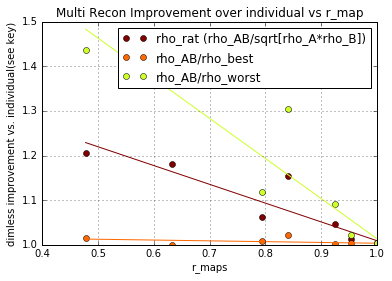

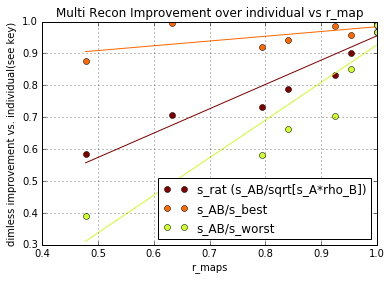

In [175]:
#compare multistats to stats between LSS maps
x_rhoexp = [mrec.rhoexp for mrec in mrs]
x_rho_rat = [mrec.rho_rat for mrec in mrs]
x_sexp = [mrec.sexp for mrec in mrs]
x_s_rat = [mrec.s_rat for mrec in mrs]
x_ssymexp = [mrec.sexp for mrec in mrs]
x_ssym_rat = [mrec.s_rat for mrec in mrs]

x_rpairs = [mrec.rpairs[0] for mrec in mrs]
mlabels2=[mrec.label for mrec in mrs]
    
# labplot_r(x_rpairs,x_rho_rat,labels2,'r_map', 'rho_AB/sqrt(rhoA*rhoB)',show=False)
# plt.plot(x_rpairs_noN,x_rho_rat,'r.',label='No Noise')
rhomod1 = [mrec.rhoexp/np.max(mrec.rho_arr) for mrec in mrs]
rhomod2 = [mrec.rhoexp/np.min(mrec.rho_arr) for mrec in mrs]
labels22 = ['rho_rat (rho_AB/sqrt[rho_A*rho_B])','rho_AB/rho_best','rho_AB/rho_worst']

ytests = [x_rho_rat,rhomod1, rhomod2]
# for i,(yarr,label) in enumerate(zip(ytests,labels22)):
#     xarr = x_rpairs
#     color = cmap(float(i)/len(ytests))
#     plt.plot(xarr,yarr,'o',label=label, color=color)
#     coeffs = np.polyfit(xarr,yarr,deg=1)
#     yfit = np.polyval(coeffs, xarr) #Evaluates the polynomial for each x2 value
#     plt.plot(xarr,yfit,'-',color=color)
plotnfit(x_rpairs,ytests,labels22, deg=1)
plt.legend(loc='best')
# plt.xlim(.55,1.1)
# plt.ylim(.95,1.25)
plt.grid(True)
plt.title('Multi Recon Improvement over individual vs r_map')
plt.xlabel('r_maps')
plt.ylabel('dimless improvement vs. individual(see key)')
plt.show()

#s
smod1 = [mrec.sexp/np.min(mrec.s_arr) for mrec in mrs] #note that i switch min and max here since a low s corresponds to a higher rho, so dividing out same map.
smod2 = [mrec.sexp/np.max(mrec.s_arr) for mrec in mrs]

slabels= ['s_rat (s_AB/sqrt[s_A*rho_B])','s_AB/s_best','s_AB/s_worst']
ytests2 = [x_s_rat,smod1, smod2]
plotnfit(x_rpairs,ytests2,slabels, deg=1)
plt.legend(loc='best')
# plt.xlim(.55,1.1)
# plt.ylim(.95,1.25)
plt.grid(True)
plt.title('Multi Recon Improvement over individual vs r_map')
plt.xlabel('r_maps')
plt.ylabel('dimless improvement vs. individual(see key)')
plt.show()

In [176]:
#this consolidates above plots into a function where can reproduce the plots for any given MRecStats object
def plot_mrslist(mrs, vartypes=['rat'],title=False, fitdeg=0, labplot=False, do_s=False): #vartype one of {'raw', rat', 'rat_best', 'rat_worst'}
    """plot stats of an MRecStats object. vartypes is list that can include {'raw', 'rat','rat_best','rat_worst'},
    where rat is standard ratio of multi recon stat to individual recon stats, rat_best is multi normalized to best individual, etc."""
    irs=[irec for irec in mrs if irec.Nmaps==1]#get the single reconstructions
    mrs=[mrec for mrec in mrs if mrec.Nmaps>1]

    x_rhoexp = [mrec.rhoexp for mrec in mrs]
    x_rho_rat = [mrec.rho_rat for mrec in mrs]
    x_sexp = [mrec.sexp for mrec in mrs]
    x_s_rat = [mrec.s_rat for mrec in mrs]
    x_ssymexp = [mrec.sexp for mrec in mrs]
    x_ssym_rat = [mrec.s_rat for mrec in mrs]

    x_rpairs = [mrec.rpairs[0] for mrec in mrs]
    mlabels2=[mrec.label for mrec in mrs]
    
    ylist=[]
    rhobest = [mrec.rhoexp/np.max(mrec.rho_arr) for mrec in mrs]
    rhoworst = [mrec.rhoexp/np.min(mrec.rho_arr) for mrec in mrs]
    labels22 = []
    
    slist=[]
    sbest = [mrec.sexp/np.max(mrec.s_arr) for mrec in mrs]
    sworst = [mrec.sexp/np.min(mrec.s_arr) for mrec in mrs]
    slabels22 = []
    if type(vartypes) == str: vartypes=[vartypes]
    if 'raw' in vartypes:
        ylist.append(x_rhoexp)
        labels22.append('rho_raw')
        slist.append(x_sexp)
        slabels22.append('s_raw')
    if 'rat' in vartypes:
        ylist.append(x_rho_rat)
        labels22.append('rho_rat')
        slist.append(x_s_rat)
        slabels22.append('s_rat')
    if 'rat_best' in vartypes:
        ylist.append(rhobest)
        labels22.append('rho_AB/rho_best') 
        slist.append(sbest)
        slabels22.append('s_AB/s_best') 
    if 'rat_worst' in vartypes:
        ylist.append(rhoworst)
        labels22.append('rho_AB/rho_worst')
        slist.append(sworst)
        slabels22.append('s_AB/s_worst')
    if labplot:
        N = len(ylist)
        for x,y,mlab,varlab in zip([x_rpairs]*N, ylist, [mlabels2]+['']*(N-1), labels22):
            labplot_r(x,y,mlab,'r_map', 'rho various',ha='left',show=False,seq_label=varlab)
            if title: plt.title(title)
            plt.legend(loc='best')
        plt.xlim(0.95*min(x_rpairs), 1.05*max(x_rpairs))
        plt.grid()
        plt.show()
        
        if do_s:
            for x,y,mlab,varlab in zip([x_rpairs]*N, slist, [mlabels2]+['']*(N-1), slabels22):
                labplot_s(x,y,mlab,'r_map', 's various',ha='right',show=False,seq_label=varlab)
                plt.legend(loc='best')
            plt.xlim(0.95*min(x_rpairs), 1.05*max(x_rpairs))
            plt.grid()
            plt.show()
    else:
        plotnfit(x_rpairs, ylist, labels22, deg=fitdeg)
        plt.xlabel('r_lss')
        if title:
            plt.title(title)
        plt.legend(loc='best')
        plt.show()
        
        if do_s:
            plotnfit(x_rpairs, slist, slabels22, deg=fitdeg)
            plt.xlabel('r_lss')
            if title:
                plt.title(title)
            plt.legend(loc='best')
            plt.show()
    return

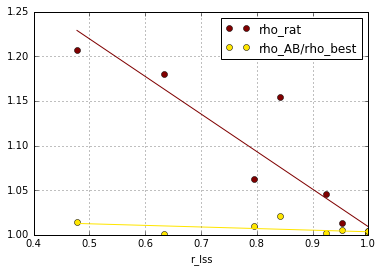

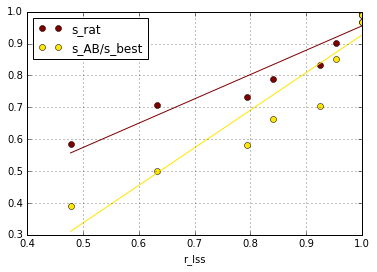

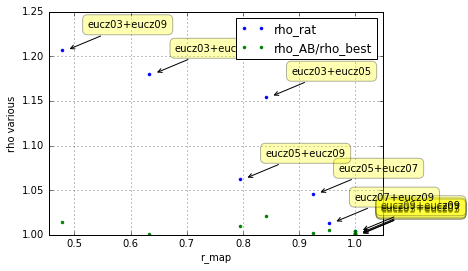

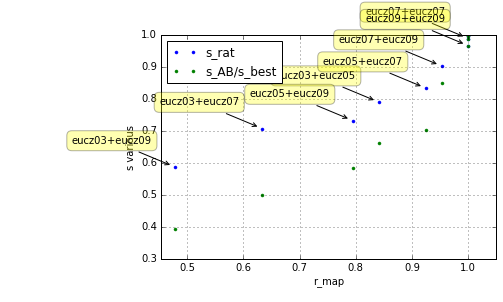

In [177]:
plot_mrslist(mrs, vartypes=['rat', 'rat_best'],title=False, fitdeg=1, labplot=False, do_s=True)
plot_mrslist(mrs, vartypes=['rat', 'rat_best'],title=False, fitdeg=2, labplot=True, do_s=True)

In [178]:
##-------- THIS IS DEPRECIATED. USE M_CALTEST_GET_RHOEXP2 BELOW ------------
def m_caltest_get_rhoexp(fidcl=False, z0_base=0.7, z0_sup=0.7,basevar=0,varlist=[1.e-4],lmax=50,lmin=0,shape='g',width=10.,
                         overwrite=False,doplot=True,saverho=True,varname='rho',filetag='',reclmin=2,
                         plotdir='output/m_caltest_plots/',nolmintag=False,dofidrec=False,nbar='default',outtag='',knowClCal=False, #if knowClCal=True, use recCl = true Cl (including ClCal) instead of fidCl
                         fitbias=True, get_Clfid=False,get_Clmod=False):
    """give z0_base and z0_sup, where the latter is the map to add to the first to see improvement and which gets the list of calib variances
    in varlist applied. basevar defines a calib error to apply to the basemap.
    Set z0_base = 0 to do recon with just one map"""
    #note this makes a parallel track for single map recon with caltest_get_rhoexp,
    #but would prefer not to edit guts of that one to, e.g. pass a Cl, as it also defines an output loc, etc. and don't want to risk
    #messing it up. It should be obvious from calc and output which way it was created, and this will allow comparison of the two methods.
    varlist=varlist[:] #was encountering some accidental changes to varlist outside function scope with fidrec. Make sure to pass a copy.
    dupesuf = '_sup' #if comparing two surveys of same depth, need two sets of Cls. The duplicate will be the "supplemental" map
    single_map=False
    if z0_base == False:
        single_map = True
        z0_vals = [z0_sup] 
    else: z0_vals = [z0_base,z0_sup] #will need to change this is use multiple base bins
            
    fidbins=multi_depthtest_get_binmaps(z0_vals,nbar=nbar) #only need this to get the bin name, but now we're passing those in.
    lssbins=[fb.tag for fb in fidbins[1:]] #ignore the first entry (ISW)
    #fidcl=caltest_get_clfid(z0fid)
    #if z0_base == z0_sup, will use autopower, so pass set(z0_vals). If change to make z0_sup a list, will need to change this implementation
    if not fidcl:
        print 'No Cl object given. Calling multi_get_Cl...'
        fidcl=multi_get_Cl(justread=not(overwrite),z0vals=set(z0_vals), nbar=nbar, outtag=outtag)
        if not single_map:
            assert fidcl.clcomputed_forpair(lssbins[0],lssbins[1])
    else: fidcl=copy.deepcopy(fidcl)
    recdat = au.RecData(includeglm=lssbins,inmaptag=m_binarr_to_labels(lssbins),minl_forrec=reclmin)
    if len(set(z0_vals)) != len(z0_vals): #if there are duplicates, account for for this and change names accordingly
        fidcl,recdat = au.handle_dupes(fidcl, recdat, dupesuf=dupesuf)
        #lssbins[1] = lssbins[1]+dupesuf
        lssbins = recdat.includeglm
        assert [bn in fidcl.bintaglist for bn in lssbins] #verify all newly named lss bins are in bintaglist
    basebins = lssbins[:-1] #last entry is the map we're adding, assuming we already have the others (can't handle more than one base yet)
    supbin = lssbins[-1]

#     if saverho:
#         shapestr=getShapeStr(lmin=lmin,lmax=lmax,width=width,shape=shape)
#         outdir = 'output/'+outtag+'/m_caltest_plots/'
#         if filetag:
#             filetagstr='_'+filetag
#         else:
#             filetagstr=''
#         if not nolmintag: #for compatibility with older, pre-lmintest data
#             reclminstr="-lmin{0:02d}".format(reclmin)
#             filetagstr=filetagstr+reclminstr
#         datfile='m_caltest_'+'z{0:02d}+z{1:02d}_bvar{5:02e}_{2:s}_{3:s}exp{4:s}.dat'.format(z0_base,z0_sup,shapestr,
#                                                                                             varname,filetagstr,basevar)
#         if not overwrite and os.path.isfile(outdir+datfile): #file exists
#             print 'Reading data file:',datfile
#             x=np.loadtxt(outdir+datfile,skiprows=2)
#             invarlist=x[:,0]
#             if not np.all(invarlist==np.array(varlist)):
#                 print "WARNING, invarlist!=varlist, overwriting"
#             else:
#                 rhoarray=x[:,1]
#                 return rhoarray
#         else:
#             print 'Writing to data file:',datfile

    #construct map-mod combos for the variances given
    mapmods_sup=runeuc.caltest_getmapmods_onebin(supbin,varlist,lmax,lmin,shape,width)
#     print 'mapmods_sup:',mapmods_sup
    #generate calibration errors with fixed variance, spread through Cl lmin-lmax
    clmodlist=[]

#     print fidcl.bintaglist
#     print '\nfidcl supbin autopower l=0,5:  {0}, {1}'.format(fidcl.get_cl_from_pair(supbin,supbin,0),fidcl.get_cl_from_pair(supbin,supbin,5))
    if not single_map: #if we are using two or more maps for recon (set z0_base=False for only a single recon)
        assert len(basebins) == 1 #THIS ONLY WORKS FOR ONE MAP AS THE BASE MAP. NEED TO ADJUST IF USING MORE THAN ONE
        if type(basevar)==list: 
            assert len(basevar)==len(varlist), "variance of base map given as list length {0},\
                                                but must be same length as varlist for supplemental map ({1})".format(len(basevar),len(varlist))
            mapmods_base=runeuc.caltest_getmapmods_onebin(basebins[0],basevar,lmax,lmin,shape,width) #vary the basemap variance
            print 'Varying basemap variance along with sup-map variance'
        else: #do all calcs using same basevar
            mapmods_base=runeuc.caltest_getmapmods_onebin(basebins[0],[basevar]*len(varlist),lmax,lmin,shape,width) #mod to z0_base
        #for each variance, get calib error Cl
            #(note, this is an inefficient way to do this, since mm_base will be same everytime)
        for (mm_base, mm_sup) in zip(mapmods_base, mapmods_sup): #add calib errors according to (map, var[c]) for each base and sup maps
#             print 'INRHOEXP---modding Cl---',mm_sup
            clmod=gmc.apply_additive_caliberror_tocl(fidcl,[mm_base, mm_sup])
            clmodlist.append(clmod)
#             print 'clmod basebn autopower l=0,5:  {0}, {1}'.format(clmod.get_cl_from_pair(basebins[0],basebins[0],0),clmod.get_cl_from_pair(basebins[0],basebins[0],5))
#             print 'clmod supbin autopower l=0,5:  {0}, {1}'.format(clmod.get_cl_from_pair(supbin,supbin,0),clmod.get_cl_from_pair(supbin,supbin,5))
            
#         print 'mm_base,mm_sup[:5]=',zip(mapmods_base[:5], mapmods_sup[:5])
    else: #only single map, so only considering z0_sup map in recon
        for mm_sup in mapmods_sup: #add calib errors according to (map, var[c]) for sup maps
#             print 'INRHOEXP---modding Cl---',mm_sup
            clmod=gmc.apply_additive_caliberror_tocl(fidcl,[mm_sup])
#             print 'clmod supbin autopower l=0,4:  {0}, {1}'.format(clmod.get_cl_from_pair(supbin,supbin,0),clmod.get_cl_from_pair(supbin,supbin,4))
#             print 'clmod ISW-supbin crosspower [l=4]:  {0}'.format(clmod.get_cl_from_pair(fidbins[0].tag,supbin,4),)
            clmodlist.append(clmod) #<------ Clmod still good with autopowers, etc. Error must creep in later.
#         print 'mm_sup[::10]=',mapmods_sup[:10]

    # include fidicual cl as last entry
    if varlist[-1]!=0. and dofidrec:
#         print "  appending fiducial case, no calib error"
        varlist.append(0.)
        clmodlist.append(fidcl)
        
    # return array of shape [Nvar,Nell]
    Nrec=len(varlist)
#     rhoarray=np.zeros(Nrec)
    rho_list = [0]*Nrec
    for r in xrange(Nrec):
#         print '\n--ON VAR=',varlist[r],'---------'
        if knowClCal: recCl = clmodlist[r] #we know the calib errors and model them exactly
        else: recCl = fidcl #we don't know calib errors - use fiducial Cl
        if varname=='rell':
            rho_list[r]=au.compute_rell_fromcl(clmodlist[r],recdat,reccldat=recCl,varname=varname,fitbias=fitbias)
        else: rho_list[r]=au.compute_rho_fromcl(clmodlist[r],recdat,reccldat=recCl,varname=varname,fitbias=fitbias)
        if type(rho_list[r])==float:
            rhoarray=np.array(rho_list) #if varname is estop, we're getting the estimator operator instead of rho or s, so not a number and can't set array.
#         print 'fidcl tags:',fidcl.bintaglist
    #if save, write to file
    if saverho:
        f=open(outdir+datfile,'w')
        f.write('Multi calib error test: Clcal shape={0:s}, ell={1:d}-{2:d}, z0_base={3:.2d} (var(c)={4:.2e}), z0_sup={5:.2d}\n'.format(shape,lmin,lmax,z0_base,basevar,z0_sup))
        f.write('sup var(c(nhat))   <{0:s}>\n'.format(varname))
        f.write(''.join(['{0:.2e} {1:8.3f}\n'.format(varlist[i],rhoarray[i]) for i in xrange(Nrec)]))
        f.close()

    if doplot:
        runeuc.caltest_rhoexpplot(varlist,rhoarray,varname=varname,outtag=shapestr,plotdir=plotdir)
    result = [rho_list]
    if get_Clfid: result.append(fidcl)
    if get_Clmod: result.append(clmodlist)
    if len(result) > 1: return result
    else: return result[0] #if only rho_list, return rho_list straight instead of nested in another list
####--------- cell 2

In [179]:
def m_caltest_get_rhoexp2(z0_vals=[], fidcl=False, z0_base=False, z0_sup=False,basevar=0,varlist=[1.e-4],lmax=50,lmin=0,shape='g',width=10.,
                         overwrite=False,doplot=True,saverho=True,varname='rho',filetag='',reclmin=2,
                         plotdir='output/m_caltest_plots/',nolmintag=False,dofidrec=False,nbar='default',outtag='',knowClCal=False, #if knowClCal=True, use recCl = true Cl (including ClCal) instead of fidCl
                         fitbias=True, get_Clfid=False,get_Clmod=False, diffvar=False, norectest=False, f_xcorr=0):
    """generalization of m_caltest_get_rhoexp to arbitrary number of maps. z0_vals is map depths to use in reconstruction and , to which varlist variances are applied.
    z0_base,z0_sup and basevar provided for backcompatibility - use these OR z0_vals.
    If diffvar=True, varlist must be list of sublists (of lengths == len(z0_vals)), with sublists containing the variance to apply to each lssbin (i.e. [[0,0,0],[1e-6,1e-4,1e-4],...] for z0_vals=[0.5,0.7,0.9].
    Otherwise, varlist is used for each map"""
    if diffvar: assert len(z0_vals)==len(varlist[0])
    else: assert type(varlist[0])!=list
    varlist=varlist[:] #was encountering some accidental changes to varlist outside function scope with fidrec. Make sure to pass a copy.
    dupesuf = '_sup' #if comparing two surveys of same depth, need two sets of Cls. The duplicate will be the "supplemental" map
    single_map=False #default
    if len(z0_vals) > 0:
        assert z0_base==False and z0_sup == False and basevar==0, "Error: received both z0_vals list AND individual z0_base, z0_sup or basevar arguments."
        if len(z0_vals)==1:
            single_map=True
    elif z0_base == False:
        single_map = True
        z0_vals=[z0_sup]
    else: z0_vals=[z0_base,z0_sup]
        
    vararr = np.array(varlist)
    
    fidbins=multi_depthtest_get_binmaps(z0_vals,nbar=nbar) #only need this to get the bin name, but now we're passing those in.
    lssbins=[fb.tag for fb in fidbins[1:]] #ignore the first entry (ISW)
    #fidcl=caltest_get_clfid(z0fid)
    #if z0_base == z0_sup, will use autopower, so pass set(z0_vals). If change to make z0_sup a list, will need to change this implementation
    if not fidcl:
        print 'No Cl object given. Calling multi_get_Cl...'
        fidcl=multi_get_Cl(justread=not(overwrite),z0vals=set(z0_vals), nbar=nbar, outtag=outtag)
        if not single_map:
            assert all([fidcl.clcomputed_forpair(lss_b1,lss_b2) for (lss_b1,lss_b2) in getCombos(lssbins, size=2)]) #verify all cls computed
    else: fidcl=copy.deepcopy(fidcl)
    recdat = au.RecData(includeglm=lssbins,inmaptag=m_binarr_to_labels(lssbins),minl_forrec=reclmin)
    if len(set(z0_vals)) != len(z0_vals): #if there are duplicates, account for for this and change names accordingly
        fidcl,recdat = au.handle_dupes(fidcl, recdat, dupesuf=dupesuf)
        #lssbins[1] = lssbins[1]+dupesuf
        lssbins = recdat.includeglm
        assert [bn in fidcl.bintaglist for bn in lssbins] #verify all newly named lss bins are in bintaglist
    basebins = lssbins[:-1] #last entry is the map we're adding, assuming we already have the others (can't handle more than one base yet)
    supbin = lssbins[-1]

    #generate calibration errors with fixed variance, spread through Cl lmin-lmax
    clmodlist=[]
    #construct map-mod combos for the variances given
    mapmods_list = runeuc.caltest_getmapmods_multibin(lssbins, varlist, lmax,lmin,shape,width,diffvar=diffvar)
    #same length as varlist: [[(bintagA, modtag0),(bintagB,modtag0)], [(bintagA,modtag1),(bintagB,modtag1),...]]
    for mapmods in mapmods_list:
        clmod=gmc.apply_additive_caliberror_tocl(fidcl, mapmods, f_xcorr)
        clmodlist.append(clmod)
    #----------

    # include fidicual cl as last entry
    if not diffvar:
        if varlist[-1]!=0. and dofidrec:
    #         print "  appending fiducial case, no calib error"
            varlist.append(0.)
            clmodlist.append(fidcl)
    elif dofidrec: print "dofidrec but diffvar==True -- not appending fiducial case"
    # return array of shape [Nvar,Nell]
    Nrec=len(varlist)
#     rhoarray=np.zeros(Nrec)
    rho_list = [0]*Nrec
    for r in xrange(Nrec):
#         print '\n--ON VAR=',varlist[r],'---------'
        if knowClCal:
            if norectest: recCl = False #this is to compare if passing the reccldat = cldat is the same as leaving blank
            else: recCl = copy.deepcopy(clmodlist[r]) #we know the calib errors and model them exactly
        else: recCl = copy.deepcopy(fidcl) #we don't know calib errors - use fiducial Cl
        if varname=='rell':
            rho_list[r]=au.compute_rell_fromcl(clmodlist[r],recdat,reccldat=recCl,varname=varname,fitbias=fitbias)
        else:
            rho_list[r]=au.compute_rho_fromcl(clmodlist[r],recdat,reccldat=recCl,varname=varname,fitbias=fitbias)
        if type(rho_list[r])==float:
            rhoarray=np.array(rho_list) #if varname is estop or rell, we're getting a list of lists instead of rho or s, so not a number and can't set array.
#         print 'fidcl tags:',fidcl.bintaglist
    #if save, write to file
    if saverho:
        f=open(outdir+datfile,'w')
        f.write('Multi calib error test: Clcal shape={0:s}, ell={1:d}-{2:d}, z0_base={3:.2d} (var(c)={4:.2e}), z0_sup={5:.2d}\n'.format(shape,lmin,lmax,z0_base,basevar,z0_sup))
        f.write('sup var(c(nhat))   <{0:s}>\n'.format(varname))
        f.write(''.join(['{0:.2e} {1:8.3f}\n'.format(varlist[i],rhoarray[i]) for i in xrange(Nrec)]))
        f.close()

    if doplot:
        runeuc.caltest_rhoexpplot(varlist,rhoarray,varname=varname,outtag=shapestr,plotdir=plotdir)
    result = [rho_list]
    if get_Clfid: result.append(fidcl)
    if get_Clmod: result.append(clmodlist)
    if len(result) > 1: return result
    else: return result[0] #if only rho_list, return rho_list straight instead of nested in another list
####--------- cell 2

In [180]:
def calplotsetup(fig=False,size=(7,4), scalar=1):
    """call before calplotform to setup figure and axis. Plot desired lines between the two function calls via ax1.plot(...)."""
    if not fig:
        size = (scalar*size[0],scalar*size[1])
        fig=plt.figure(figsize=size)
        fig.subplots_adjust(bottom=.2)
        fig.subplots_adjust(left=.175)
        fig.subplots_adjust(right=.95)
    ax1 = plt.subplot()
    return (fig,ax1)

def calplotform(axis, varname='rho',show=False, showregions=True, xlabel=r'Var[c]',scalar=1):
    """Pass axis, format like caltest rho and s plots in paper. Plot actual curves explicitly then call this. showregions bool toggles the shaded 'current' and 'future' regions"""
    ax1 = axis
    #--- resume plotting details
#     linelabel='Theory (add. only)'
    for item in ([ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels()
                  + ax1.get_yticklabels()):
        item.set_fontsize(18*scalar)
    for item in ([ax1.yaxis.label]):
        item.set_fontsize(24*scalar)#(22)
    plt.sca(ax1)
    ax1.grid(True)
    ax1.set_xscale('log')
    ax1.set_xlim((10**-8,10**-1.5))#(10**-7.5,10**-1.5))
#     ax1.set_xlabel(r'Variance of calib. error field ${\rm var}[c]$')
    ax1.set_xlabel(xlabel)
    ax1.axhline(0,color='grey',linestyle='-')
    if varname=='rho':
        ax1.set_ylim(0,1)#(-.3,1.3)
        ax1.axhline(1,color='grey',linestyle='-')
        ax1.set_ylabel(r'$\rho$')
    elif varname=='s':
        ax1.set_ylabel(r'$s$')
        ax1.set_ylim((.1,3.))

    if showregions:
        #fill in regions for current/future values
        nowmin=1.e-4
        nowmax=1.e-3
        nowcenter=10**(.5*(np.log10(nowmin)+np.log10(nowmax)))
        nowlabel='current'
        nowcol='#377eb8'
        futuremin=1.e-6
        futuremax=1.e-5
        futurecenter=10**(.5*(np.log10(futuremin)+np.log10(futuremax)))
        futurelabel='future'
        futurecol='#4daf4a'
        ymin,ymax=ax1.get_ylim()
        ##plt.fill_between(varlist[:-1],ymin,ymax, facecolor=nowcol,edgecolor='none',linewidth=2, alpha=0.3)
        ax1.axvspan(nowmin,nowmax,alpha=0.1,color=nowcol)
        plt.annotate(nowlabel,xy=(nowcenter,ymin),horizontalalignment='center',verticalalignment='bottom',fontsize=16*scalar,color=nowcol)
        ax1.axvspan(futuremin,futuremax,alpha=0.1,color=futurecol)
        plt.annotate(futurelabel,xy=(futurecenter,ymin),horizontalalignment='center',verticalalignment='bottom',fontsize=16*scalar,color=futurecol)

    ##data points should just have one entry, but copying whole mess anyway
    # for i in xrange(len(datplot)):
    #     datvar=datplot[i][0]#array
    #     datrho=datplot[i][1]#array
    #     datlabel=datplot[i][2] #string
    #     datNreal=0
    #     datcol=datplot[i][3]
    #     datsig=datplot[i][4]         
    #     datrefmean=datplot[i][5]
    #     if len(datplot[i])>5:
    #         datNreal=datplot[i][6]
    #     if not datcol:
    #         datcol=colorlist[0]
    #     ax1.errorbar(datvar,datrho,yerr=datsig,label=datlabel,color=datcol,linestyle='None',marker='o')    

    plt.sca(ax1)
    if varname=='rho':
        plt.legend(fontsize=12*scalar,loc='upper right',numpoints=1)
    elif varname=='s':
        plt.legend(fontsize=12*scalar,loc='upper left',numpoints=1)

    # print 'Saving plot to ',plotdir+outname
    # plt.savefig(plotdir+outname)
    # plt.close()
    if show: plt.show
    return ax1

In [181]:
class CalibSpecs(object):
    def __init__(self,shape='g', width=10.,lmincal=0,lmaxcal=50):
        self.shape=shape
        self.width=width
        self.lmincal=lmincal
        self.lmaxcal=lmaxcal
    def get_specs(self):
        return (self.shape, self.width, self.lmincal, self.lmaxcal)

In [182]:
def plotEstimators_of_pairs():
    nbar='default'
    z0pairs=[(.3,.5),(.5,.7),(.3,.7)]
    #Cal test Multi:
    #==========================================
    # v v v----- This function (caltest_basic_expplot_forpaper) is from GPFP module. Using to guide mu
    # plots rho exp and data points for one shape and lmin
    #combine stuff from caltest_compare_clcal_shapes with rhoexpplot
    outtag='mCal04_fidz0_bv0'
    colorlist=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']#qualitative
    reclmin=2
    #info about calibration errors
    # calspecs = CalibSpecs(shape='g',width=10.,lmincal=0,lmaxcal=50)
    (shape,width,lmincal,lmaxcal)=('g',10.,0,50)

    #what points to plot
    shortvarlist=[0,1.e-5,1.e-3,1.e-2]#for data points
    varlist=shortvarlist[:]
    basevar=shortvarlist[:]
    cmap = plt.get_cmap('jet_r')
    N_var=len(varlist)
    scalebycl = True
    z0set = set(chain.from_iterable(z0pairs)) #extract unique values from the pairs

    fidcl=multi_get_Cl(justread=True,z0vals=z0set, nbar=nbar, outtag=outtag)
    for fitbias in (True, False):
    #     fig, ax1 = calplotsetup()
        for k,(z0_1,z0_2) in enumerate(z0pairs):
            print '\n-----z0_base={0}, z0_sup={1}-----'.format(z0_1,z0_2)

            (estop_list_temp,fidcl,clmod) = m_caltest_get_rhoexp(fidcl, z0_base=z0_1, z0_sup=z0_2, basevar=basevar[:],varlist = varlist[:],lmax=lmaxcal,lmin=lmincal,
                                    shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname='estop',
                                    reclmin=reclmin,outtag=outtag,fitbias=fitbias,get_Clfid=True,get_Clmod=True)
    #         estop_array = np.array(estop_list_temp)
    #         relweights = np.zeros_like(estop_array) #inprog. For looking at the weights of maps vs l 
            for j,estop_var in enumerate(estop_list_temp):#list of length varlist
                color = cmap(float(j)/((1.1*N_var-1)))
                #estimator operator, shape (NLSS,Nell), where Nell is highest l value i think
                l_x = xrange(estop_var.shape[1])
                for i,R_l_list in enumerate(estop_var): #NLSS is 2 right now, since recdat uses z0_1 and z0_2 as its two input maps
                    if i==0: pt = 'x'
                    else: pt = '.'
                    plt.plot(l_x, R_l_list,pt,color=color, alpha=.8,label='{0:.1}_varc{1:.1e}'.format(z0pairs[k][i],varlist[j]))
        #     ax1=calplotform(ax1,varname=varname) #format like caltest plot
            if basevar==varlist: bvlabel = 'var[c]'
            else: bvlabel='{0}'.format(basevar,)
            # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
            plt.xlabel('Multipole l')
            plt.ylabel('Estimator Operator (R_l)')
            plt.xlim(0,20)
            plt.grid(True)
            plt.legend()
            plt.title('Caltest - z0_base,sup=({0:.1f},{3:.1f}, bvar {1}, fitbias={2}'.format(z0_1,bvlabel,fitbias,z0_2))
            plt.show()
    #         plt.plot(l_x,estop_var/)

    #When fitbias = False, estop is same for all var_c. So look at relative combos
    mrk_list=['.','x','+']
    z0_set=set([])
    for k,(z0_1,z0_2) in enumerate(z0pairs):
        print '\n-----z0_base={0}, z0_sup={1}-----'.format(z0_1,z0_2)
        estop_list_temp = m_caltest_get_rhoexp(fidcl, z0_base=z0_1, z0_sup=z0_2, basevar=0,varlist = [0],lmax=lmaxcal,lmin=lmincal,
                                shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='estop',
                                reclmin=reclmin,outtag=outtag,fitbias=fitbias)
        estop_var=estop_list_temp[0]
        #estimator operator, shape (NLSS,Nell), where Nell is highest l value (pretty sure)
        l_x = xrange(estop_var.shape[1])
        for i,R_l_list in enumerate(estop_var): #NLSS is 2 right now, since recdat uses z0_1 and z0_2 as its two input maps
            color = cmap(z0pairs[k][i]**2) #each z0 has same color, marker dependent on which other map is paired with
            plt.plot(l_x, R_l_list,mrk_list[k],color=color,label='{0:.1}'.format(z0pairs[k][i],))
    #     ax1=calplotform(ax1,varname=varname) #format like caltest plot
        if basevar==varlist: bvlabel = 'var[c]'
        else: bvlabel='{0}'.format(basevar,)
        # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
    plt.xlabel('Multipole l')
    plt.ylabel('Estimator Operator (R_l)')
    plt.xlim(0,20)
    plt.grid(True)
    plt.legend()
    plt.title('Caltest - z0_base,sup=({0:.1f},{3:.1f}, bvar {1}, fitbias={2}'.format(z0_1,bvlabel,fitbias,z0_2))
    plt.show()

if 0: plotEstimators_of_pairs()

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= False
Looking for Cl file: output/depthtest/Cl_output/Cl_depthtest.dat
Reading C_l file: output/depthtest/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


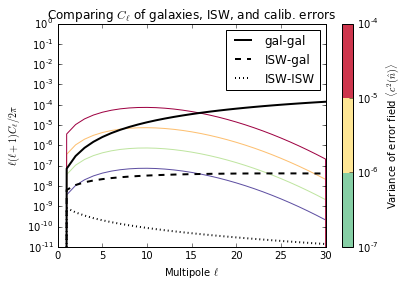

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


/Users/nw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: divide by zero encountered in divide
/Users/nw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in divide


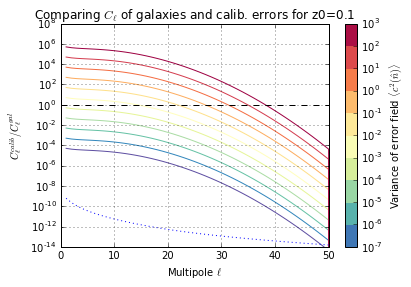

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


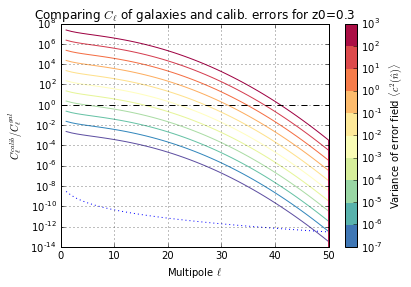

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


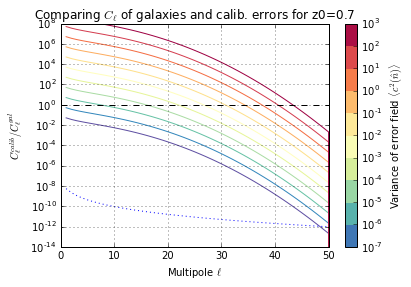

In [183]:
runeuc.caltest_Clcomp()

# this from run_euclid. Adapt to multi, generic z0 to look at noise vs signal Cl.
#---------------------------------------------------------------
# plot comparison bewteen Cl cal and Cl gal or Cl gal-ISW to understand
# why the transition in rho happens where it is
def mcaltest_Clcomp(z0,varlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1,1.e0,1.e1,1.e2,1.e3],shape='g',callmin=0,callmax=50,width=10.,
                    plotdir='output/caltest_plots/',saveplot=False, relative=False, outtag='mCal_full00'):
    Nvar=len(varlist)
    #get Clcal and Cl
    fidbins=runeuc.caltest_get_fidbins(z0)
    iswbin=fidbins[0].tag #will be the isw map
    iswind=0
    lssbin=fidbins[1].tag #will just be the depthtest bin map
    lssind=1
#     fidcl=runeuc.caltest_get_clfid(z0)
    fidcl=multi_get_Cl(justread=True, z0vals=[z0], outtag=outtag)
    l=np.arange(fidcl.Nell)
    
    #construct map-mod combos for the variances given
    mapmods=runeuc.caltest_getmapmods_onebin(lssbin,varlist,callmax,callmin,shape,width)
    clcal=np.zeros((Nvar,fidcl.Nell))
    for i in xrange(Nvar):
        ctag=mapmods[i][1]
        if ctag[:2]=='l2':#power law
            var,maxl,minl=gmc.parsemodtag_fixedvar_l2(ctag)
            thiscalcl=gmc.gen_error_cl_fixedvar_l2(var,maxl,minl)
        elif ctag[:1]=='g':#gaussian
            var,maxl,minl,width=gmc.parsemodtag_fixedvar_gauss(ctag)
            thiscalcl=gmc.gen_error_cl_fixedvar_gauss(var,maxl,minl,width=width)
        clcal[i,:callmax+1]=thiscalcl
        
    #plot Cl cal for various variance values in color gradient
    # http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
    cm=plt.get_cmap('Spectral_r')
    cNorm=runeuc.colors.LogNorm()#max and min numbers colors need to span
    scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm)
    varcols=scalarMap.to_rgba(varlist)
    clscaling=l*(l+1.)/(2*np.pi)
    #to get colorbar key, need ot set up a throw-away map
    dummyz=[[0,0],[0,0]]
    dummylevels=varlist
    dummyplot=plt.contourf(dummyz,dummylevels,cmap=cm,norm=cNorm)
    plt.clf()
    fig=plt.gcf()
    
    fig=plt.figure(0)
    ax=plt.subplot()

    if relative:
        plt.ylabel(r'$C_{{\ell}}^{calib}/C_{{\ell}}^{gal}$')
    else: plt.ylabel(r'$\ell(\ell+1)C_{{\ell}}/2\pi$')
             
    #plto fid cl
    #overlay Clgal, Clgal-isw in bolded lines
    lssauto=fidcl.crossinds[lssind,lssind]
    lssisw=fidcl.crossinds[iswind,lssind]
    iswauto=fidcl.crossinds[iswind,iswind]

    if not relative:
        line1,=plt.plot(l,np.fabs(fidcl.cl[lssauto,:])*clscaling,color='black',linestyle='-',linewidth=2,label='gal-gal')
        line2,=plt.plot(l,np.fabs(fidcl.cl[lssisw,:])*clscaling,color='black',linestyle='--',linewidth=2,label='ISW-gal')
        line3,=plt.plot(l,np.fabs(fidcl.cl[iswauto,:])*clscaling,color='black',linestyle=':',linewidth=2,label='ISW-ISW')
        for i in xrange(Nvar):
            plt.plot(l,np.fabs(clcal[i,:])*clscaling,color=varcols[i])
        plt.legend(handles=[line1,line2,line3])
        
        plt.title(r'Comparing $C_{{\ell}}$ of galaxies, ISW, and calib. errors')
        plt.ylim((1.e-11,1.))
    else:
        for i in xrange(Nvar):
            plt.plot(l,clcal[i,:]/fidcl.cl[lssauto,:],color=varcols[i])
#             print fidcl.cl[lssauto,:]
        plt.plot(l,[1]*len(l),'k--')
        plt.plot(l, fidcl.cl[lssisw,:]**2/fidcl.cl[lssauto,:]*(2.*l+1),':')
        plt.title(r'Comparing $C_{{\ell}}$ of galaxies and calib. errors for z0={0}'.format(z0,))
    plt.xlabel(r'Multipole $\ell$')
    plt.xlim((0,callmax))
    plt.yscale('log')
#     plt.ylim((10**-12,10**4))
    plt.ylim((10**-14,10**8))
    #set up colorbar
    logminvar=int(np.log10(min(varlist)))
    logmaxvar=int(np.log10(max(varlist)))+1
    Nlog=logmaxvar-logminvar
    varticks=[10**(logminvar+n) for n in xrange(Nlog)]
    #cbaxes=fig.add_axes([.8,.1,.03,.8])#controls location of colorbar
    colbar=fig.colorbar(dummyplot,ticks=varticks)
    colbar.set_label(r'Variance of error field $\langle c^2(\hat{{n}})\rangle$')
    plt.grid(True)
    #get legend entry for Clcal
    #cal_patch = mpatches.Patch( color='red',label='cal. error')
    plt.show()
    
    plotname='caltest_cl_compare'
    outname=plotdir+plotname+'.pdf'
    if saveplot:
        print 'saving',outname
        plt.savefig(outname)
        plt.close()
    return fig
f1=mcaltest_Clcomp(.1,relative=True)
f1=mcaltest_Clcomp(.3,relative=True)
f2=mcaltest_Clcomp(.7,relative=True)


No Cl object given. Calling multi_get_Cl...
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= False
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
No Cl object given. Calling multi_get_Cl...
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= False
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
No Cl object given. Calling multi_get_Cl...
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= False
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
No Cl object given. Calling multi_get_Cl...
km

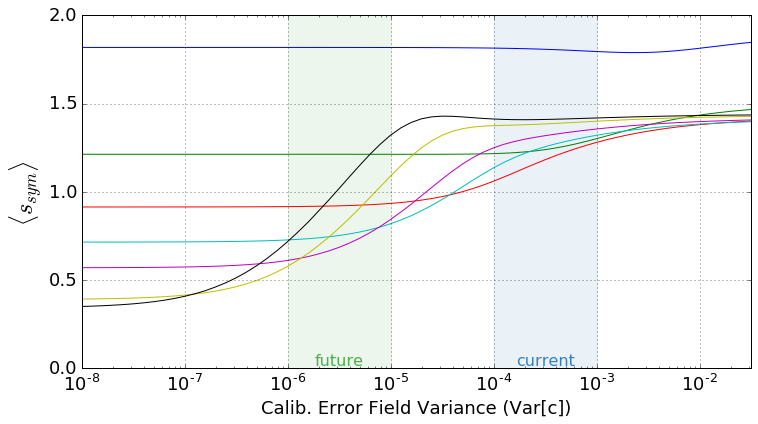

In [184]:
#Create plots similar to JM's varying calibration error plot in paper.
#Change these parameters as desired
z0_base=0.7
fibias=True
z0_sup = 0.7
nbar='default'
z0list_toplot=[.1,.2,.3,.4,.5,.7,.9]#,1.3,1.5]#[.3,.4,.5,.6,.7,.8,.9]
outtag='mCal_full00'
varname = 'ssym'
#what points to plot
varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))
basevar=varlist[:]
fitbiaslist = [True]
reclminlist=[2]

(shape,width,lmincal,lmaxcal)=('g',10.,0,50) #calib error info
#do plotting! TOGGLE FROM 0 TO 1 IN ORDER TO MAKE THAT PLOT
#assuming last entry in varlist, rhoarray is fiducial (var=0)

for fitbias in fitbiaslist:
    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
    ltypes=('-','--',':')
    for i,reclmin in enumerate(reclminlist):
        lt = ltypes[i]
        #theory line
        # ax1.plot(varlist[:-1],rhoexplist[:-1],'--',label='Base+Sup')#linelabel,color=colorlist[1])
        # ax1.plot(varlist[:-1],rhoexplist2[:-1],'--',label='Base+Sup, vary Basevar')#linelabel,color=colorlist[1])
        # ax1.plot(varlist[:-1],rhoexplist[:-1],'--',label='Base+Sup')#linelabel,color=colorlist[1])
        # ax1.plot(varlist[:-1],rhoexplist2[:-1],'--',label='Base+Sup, vary Basevar')#linelabel,color=colorlist[1])

        #double z0 vs var[c] plot
        if 0:
            print '\n----- double z0 vs var[c]'
            for z0 in z0list_toplot:
                rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0, z0_sup=z0, basevar=varlist[:],varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag,fitbias=fitbias)
                ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',alpha=0.8,label='{0} + {1}'.format(z0,z0))
        # z0_base + many z0_sup vs var[c]
        if 0:
            print 'z0 vs var[c]'
            for z0 in z0list_toplot:
                rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0, basevar=basevar,varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag,fitbias=fitbias)
                ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',alpha=0.8,label='{0} + {1}'.format(z0,z0_base))


    #    single z0 vs var[c] for many z0
        if 1:
            for z0 in z0list_toplot:
                rhoexp_temp = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag)
                ax1.plot(varlist[:-1],rhoexp_temp[:-1],lt,label='$z_0={0},lmin={1}$'.format(z0,reclmin))

    #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))
    

        if 0: #single z0 vs var[c] for just z0_base
            print '\n----SINGLE, vary z0_base by var[c]'
            rhoexplist_indiv_base = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_base, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag, fitbias=fibias)
            ax1.plot(varlist[:-1],rhoexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,))#,color=colorlist[2])
        # #two sup maps, each with var[c]
        if 0:
            rhoexplist_2sup=m_caltest_get_rhoexp(z0_base=z0_sup, z0_sup=z0_sup, basevar=varlist[:],varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                        shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                        reclmin=reclmin,outtag=outtag)
            ax1.plot(varlist[:-1],rhoexplist_2sup[:-1],'--',label='{0}_double'.format(z0_sup,),alpha=.5)#,color=colorlist[0])

        # #two base maps, each with var[c]
        if 0:
            rhoexplist_2base=m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0_base, basevar=varlist,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag, fitbias=fitbias)
            ax1.plot(varlist[:-1],rhoexplist_2base[:-1],'--',label='{0}_double'.format(z0_base,),alpha=.5)#,color=colorlist[0])
            # ax1.plot(varlist[:-1],rhoexplist_2base[:-1],'.-',label='base_dubs',color=colorlist[2])

        # ax1.plot(varlist[:-1],rhoexplist_indiv_sup[:-1],'--',label='{0} single'.format(z0_sup,))#,color=colorlist[0])
        # ax1.plot(varlist[:-1],[rhoexplist[-1]]*len(varlist[:-1]),'--',label='Sup_fid',color=colorlist[0])

    #     ax1.plot(varlist[:-1],rhoexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,))#,color=colorlist[2])
        # ax1.plot(varlist[:-1],[rhoexplist_indiv_base[-1]]*len(varlist[:-1]),'--',label='Base_fid',color=colorlist[2])

    ax1=calplotform(ax1,varname=varname) #format like caltest plot
    if varname=='rho':
        ax1.set_ylabel(r'$\langle\rho\rangle$')
    elif varname=='s':
        ax1.set_ylabel(r'$\langle s\rangle$')
    elif varname=='ssym':
        ax1.set_ylabel(r'$\langle s_{sym}\rangle$')
    ax1.set_xlabel(r'Calib. Error Field Variance (Var[c])')
    if basevar==varlist: bvlabel = 'var[c]'
    else: bvlabel='{0}'.format(basevar,)
    # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
#     plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))
#     plt.xlim(10.e-8,1e-2)
#     plt.ylim(-1,1)
    plotdir="/Users/nw/Desktop/plots/"#output/"+outtag+"/plots_forpaper/"
    dt = datetime.datetime.now()
    ts = '{0}{1:02d}{2:02d}_{3:02d}{4:02d}{5:02d}'.format(dt.year%2000,dt.month,dt.day,dt.hour,dt.minute,dt.second) #YYMMDDHHMM
    outname=ts+'_cal_{0}.pdf'.format(varname,)
#     print 'Saving plot to ',plotdir+outname
#     plt.savefig(plotdir+outname,dpi=300)
    plt.show()

    # # plot s
    # #plot 2 map recons
    # fig, ax1 = calplotsetup()

    # #double z0 vs var[c]
    # for z0 in z0list_toplot:
    #     rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0, basevar=basevar,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
    #                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='s',
    #                                 reclmin=reclmin,outtag=outtag)
    #     ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',label='{0}'.format(z0))

    # ax1.plot(varlist[:-1],sexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,),alpha=.5)#,color=colorlist[0])
    # ax1=calplotform(ax1,varname='s') #format like caltest plot
    # plt.title('Caltest - z0_base {0:.1f}, bvar {1}'.format(z0_base,bvlabel))
    # plt.show()

In [185]:
#plot recons for various pairs of euc maps with diff depths
if 0:
    reclmin=2
    nbar='default'
    z0pairs=[(.3,.5),(.5,.5),(.7,.5)]
    outtag='mCal04_fidz0_bv0'
    plotdir='output/'+outtag+'/plots_forpaper/'

    #def caltest_basic_expplot_forpaper(varname='rho',plotdir='output/plots_forpaper/'):

    #outname='caltest_'+varname+'_exp_test.pdf'
    colorlist=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']#qualitative
    reclmin=2
    #info about calibration errors
    (shape,width,lmincal,lmaxcal)=('g',10.,0,50)

    #what points to plot
    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))
    shortvarlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2]#for data points
    basevar=varlist[:]
    rhoexplist=[]#will be 1D; [variance ] 
    # knowClCal = True

    z0set = set(chain.from_iterable(z0pairs))
    z0max = max(z0set)
    fidcl=multi_get_Cl(justread=True,z0vals=z0set, nbar=nbar, outtag=outtag)
    cm=plt.get_cmap('brg')#Spectral_r')
    cNorm=runeuc.colors.Normalize()#max and min numbers colors need to span
    scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
    z0cols=scalarMap.to_rgba(list(z0set)) #need to do this, even though don't call z0cols, else they all turn out the same color

    for varname in ['rho','s']:
        outname='caltest_'+varname+'_exp_basic.pdf'
        fitbias=True
    #     for fitbias in (True, False):
        for knowClCal in (False, True): #print for both cases of knowing the magnitude of Cl_cal and Not (assuming no calib errors)
            fig, ax1 = calplotsetup(size=(12,7))
            for (z0_1,z0_2) in z0pairs:
                print '\n-----z0_base={0}, z0_sup={1}-----'.format(z0_1,z0_2)
                exp_temp = m_caltest_get_rhoexp(fidcl, z0_base=z0_1, z0_sup=z0_2, basevar=basevar,varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)  
                exp_temp_sing1 = m_caltest_get_rhoexp(fidcl, z0_base=False, z0_sup=z0_1, basevar=False,varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
                exp_temp_sing2 = m_caltest_get_rhoexp(fidcl, z0_base=False, z0_sup=z0_2, basevar=False,varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
    #             print z0_1
                my1col=scalarMap.to_rgba(z0_1)
    #             print my1col
                my2col=scalarMap.to_rgba((z0_1+z0_2)/2.) #get color in between the two z0
                ax1.plot(varlist[:-1],exp_temp_sing1[:-1],'-',c=my1col, label='{0:.1} Single'.format(z0_1,))
    #             ax1.plot(varlist[:-1],exp_temp_sing2[:-1],'-',label='{0:.1} Single'.format(z0_2,))
                ax1.plot(varlist[:-1],exp_temp[:-1],'--',c=my2col,label='{0:.1}+{1:.1} Multi'.format(min(z0_1,z0_2),max(z0_1,z0_2)))
            ax1=calplotform(ax1,varname=varname) #format like caltest plot
            if basevar==varlist: bvlabel = 'var[c]'
            else: bvlabel='{0}'.format(basevar,)
            # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
            plt.title('Caltest_2 maps, bvar {1}, fitbias={2}, reclmin={4}, knowClCal={3}'.format(z0_1,bvlabel,fitbias, knowClCal,reclmin))
            plt.show()

In [186]:
def z0list2str(z0list):
    """ [0.5, 0.2] --> '0.5+0.2' 
    Note, will fail if 'False' is in the middle of the list as opposed to the beginning or end"""
    return '+'.join(map(str, z0list)).strip('+False').strip('False+')

#this was the original functional form, now superceded by mcal_plot_many_z0_2 which can take combos of z0.
def mcal_plot_many_z0(z0list=[.3,.5,.7,.9], z0baselist=None, varnamelist=['rho','s'], reclminlist=[2],
                             nbar='default', fitbias=True, scaleToVarGal=False, doCross=0, knowClCallist=[False,True],
                            show=False):
    """create plot of rho or s vs var[c] (or var[c]/var[gal]) for z0list paired with z0baselist (must be same length).
    If z0baselist=None, then single map recon plots using z0list."""
    Nz0 = len(z0list)
    if z0baselist==None:
        z0baselist=[False]*Nz0
    else: assert len(z0baselist)==Nz0
    z0list_toplot=z0list[:]#[.1,.2,.3,.4,.5,.7,.9]#,1.3,1.5]#[.3,.4,.5,.6,.7,.8,.9]
    outtag='mCal_full00'
    #what points to plot
    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))
    varlist.append(0) #append fiducial case
    basevar=varlist[:]
    lmincal=0#min ell for calib error
    lmaxcal=50#max ell for caliberror

    z0set = set(z0list_toplot + z0baselist).difference({False})
#     print {z0list_toplot + z0baselist}
    fidcl=multi_get_Cl(justread=True,z0vals=z0set, nbar=nbar, outtag=outtag) #calculate the fiducial Cl's for all possible combos outside the loop
    # print fidcl.bintaglist
    # for fitbias in [True, False]:
#     for (fitbias, varname) in [(True, 'rho'),(True, 's'),(False, 's')]: #fitbias tends to change rho little
    #colormap jazz for coordinating plot colors
    cm=plt.get_cmap('Dark2')#Spectral_r')
    cNorm=runeuc.colors.Normalize()#max and min numbers colors need to span
    scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
    z0cols=scalarMap.to_rgba(z0list_toplot)
    
    for varname in varnamelist:
        if varname == 's':
            fitbiaslist=[True, False]
        else: fitbiaslist=[fitbias] #fitbias doesn't change rho usually (at all?) since only amplitude
        for fitbias in fitbiaslist:
            for i,reclmin in enumerate(reclminlist): #if tossing out the lower l values
                #plotting is on this level, so everything at this indent or past is on same plot
                fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
                ltypes=('-','--',':')
                for k,knowClCal in enumerate(knowClCallist):
                    lt = ltypes[k] #[i]
                    
                    for j,(z0b,z0s) in enumerate(zip(z0baselist,z0list_toplot)):
                        print 'Doing z0={0}...'.format(z0list2str([z0b,z0s]))
#                         print (z0b,z0s)
                        rhoexp_temp = m_caltest_get_rhoexp(fidcl,z0_base=z0b, z0_sup=z0s, basevar=varlist,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                                    shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                                    reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
                        if knowClCal==False:
                            mylabel = '$z_0={0},lmin={1}$'.format(z0list2str([z0s,z0b]),reclmin)
                        else: mylabel = None
                        if not scaleToVarGal: #    single z0 vs var[c] for many z0
                            ax1.plot(varlist[:-1],rhoexp_temp[:-1],lt,color=z0cols[j],label=mylabel) #color=z0cols[j]
                            xlabel=r'Var[c]'
                #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))
                        
                        else: #    single z0 vs var[c]/var[gal] for many z0    
            #                 print fidcl.bintaglist
                            if z0b!=False and z0b!=z0s:
                                print "\n WARNING: Combining two maps of different depths ({0} and {1}). Scaling Var[c] to Var[gal] of z0={0}; may not be useful...".format(z0s,z0b)
                            Nvar=len(varlist)
                            #get Clcal and Cl
                            fidbins=runeuc.caltest_get_fidbins(z0s)
                            iswbin=fidbins[0].tag #will be the isw map
                            lssbin=fidbins[1].tag #will just be the depthtest bin map
            #                 fidcl=multi_get_Cl(justread=True,z0vals=[z0], nbar=nbar, outtag=outtag)#runeuc.caltest_get_clfid(z0)
                            ell=np.arange(fidcl.Nell)
            #                 clscaling=ell*(ell+1.)/(2*np.pi)
                            clscaling=(2.*ell+1)
                            galpow = np.sum(fidcl.get_cl_from_pair(lssbin, lssbin)[reclmin:]*clscaling[reclmin:])/(4*np.pi)
                            xpow = np.sum(fidcl.get_cl_from_pair(lssbin, iswbin)[reclmin:]*clscaling[reclmin:])/(4*np.pi)
                            iswpow = np.sum(fidcl.get_cl_from_pair(iswbin, iswbin)[reclmin:]*clscaling[reclmin:])/(4*np.pi)
            #                 rhoexp_temp=rhoexp_temp/rhoexp_temp[-1] #rho_cal/rho
                            if doCross==0: #normalize to galaxy autopower
                                ax1.plot(np.array(varlist[:-1])/galpow, rhoexp_temp[:-1],lt,color=z0cols[j], label=mylabel)
                                xlabel = 'Var[c]/Var[gal]'
                            elif doCross==1: #normalize to galaxy crosspower
                                ax1.plot(np.array(varlist[:-1])/xpow, rhoexp_temp[:-1],lt,color=z0cols[j], label=mylabel)#IS THIS REALLY WHAT WE SHOULD BE PLOTTING, OR SHOULD WE SCALE VARLIST DEPENDING ON RECLMIN TO REMOVE CALIB ERRORS FROM UNUSED L?
                                xlabel = 'Var[c]/Covar[isw-gal]'
                            elif doCross==2: #custom hardcoded scaling for exploration
                                exponent = 1.6
                                ax1.plot(np.array(varlist[:-1])/galpow**exponent, rhoexp_temp[:-1],lt,color=z0cols[j], label=mylabel)
                                xlabel=r'Var[c]/Var[gal]^{0}'.format(exponent,)
                #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))

                
                if len(knowClCallist)>1: #if plotting both accounted and unaccounted for errors on same plot
                    ax1.plot(np.array([]),np.array([]),linestyle='--',color='black',label='Calib. errors accounted for')
                ax1=calplotform(ax1,varname=varname, showregions=(not scaleToVarGal), xlabel=xlabel) #format like caltest plot
                if varname=='rho':
                    ax1.set_ylabel(r'$\langle\rho\rangle$')
                elif varname=='s':
                    ax1.set_ylabel(r'$\langle s\rangle$')
                if basevar==varlist: bvlabel = 'var[c]'
                else: bvlabel='{0}'.format(basevar,)
                # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
#                 plt.title('Caltest - z0_base {0:.1f}, bvar {1}, fitbias={2}, lmin={3}, knowClCallist: {4}'.format(z0_base,bvlabel,fitbias,reclmin,knowClCallist))
                plt.title('Caltest - bvar {0}, fitbias={1}, knowClCallist: {3}'.format(bvlabel,fitbias,reclmin,knowClCallist))
                if doCross==1:
                    plt.xlim(1.e-2,1.e6)
                elif doCross==0:
                    plt.xlim(1.e-7,1.e1)
                elif doCross==2:
                    plt.xlim(1.e-3,1.e3)
            #     plt.ylim(-1,1)
                ax1.set_ylabel(r'<{0}>'.format(varname,))
                plotdir="/Users/nw/Desktop/plots/"#output/"+outtag+"/plots_forpaper/"
                dt = datetime.datetime.now()
                ts = '{0}{1:02d}{2:02d}_{3:02d}{4:02d}{5:02d}'.format(dt.year%2000,dt.month,dt.day,dt.hour,dt.minute,dt.second) #YYMMDDHHMM
                outname=ts+'_cal_{0}.pdf'.format(varname,)
            #     print 'Saving plot to ',plotdir+outname
            #     plt.savefig(plotdir+outname,dpi=300)
                if show: plt.show()

                # # plot s
                # #plot 2 map recons
                # fig, ax1 = calplotsetup()

                # #double z0 vs var[c]
                # for z0 in z0list_toplot:
                #     rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0, basevar=basevar,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                #                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='s',
                #                                 reclmin=reclmin,outtag=outtag)
                #     ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',label='{0}'.format(z0))

                # ax1.plot(varlist[:-1],sexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,),alpha=.5)#,color=colorlist[0])
                # ax1=calplotform(ax1,varname='s') #format like caltest plot
                # plt.title('Caltest - z0_base {0:.1f}, bvar {1}'.format(z0_base,bvlabel))
                # plt.show()

In [187]:
#look at rho and s for several z0 surveys, with Cl_cal known and unknown.
if 0:
    z0toplot=[.2,.3,.5,.7,.9]
    print "\n-------single z0plots"
    mcal_plot_many_z0(z0list=z0toplot,z0baselist=None, varnamelist=['rho','s'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
    print "\n-------plot paired with a fiducial z0=0.7 map"
    mcal_plot_many_z0(z0list=z0toplot, z0baselist=[.7]*len(z0toplot), varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
    print "\n-------plot paired with a fiducial z0=0.3 map"
    mcal_plot_many_z0(z0list=z0toplot, z0baselist=[.3]*len(z0toplot), varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
    print "\n-------plot double maps"
    mcal_plot_many_z0(z0list=z0toplot, z0baselist=z0toplot, varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
    print "\n-------plot double maps"
    mcal_plot_many_z0(z0list=z0toplot, z0baselist=z0toplot, varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=True, doCross=0)

In [188]:
def mcal_plot_many_z0_2(z0combolist=False, varnamelist=['rho','s'], reclminlist=[2], nbar='default', fitbias=True,
                        scaleToVarGal=False, doCross=0, knowClCallist=[False,True], show=False, verbose=False):
    """create plot of rho or s vs var[c] (or var[c]/var[gal]) for the combos of z0list with z0baselist. If z0baselist=None, then single survey plots."""
    if z0combolist==False: z0combolist= getCombos([.3,.5,.7,.9])
    else: z0combolist = [(z0,) if type(z0)!=tuple else z0 for z0 in z0combolist] #convert any single z0 values to tuples so can be read by next line
    z0set = set(chain.from_iterable(z0combolist)) #get set of unique z0's from z0combolist
    Nz0 = len(z0set)
    outtag='mCal_full00'
    #what points to plot
    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))
    varlist.append(0) #append fiducial case
    basevar=varlist[:]
    (shape,width,lmincal,lmaxcal)=('g',10.,0,50)

    fidcl=multi_get_Cl(justread=True,z0vals=z0set, nbar=nbar, outtag=outtag) #calculate the fiducial Cl's for all possible combos outside the loop
    # print fidcl.bintaglist
    # for fitbias in [True, False]:
#     for (fitbias, varname) in [(True, 'rho'),(True, 's'),(False, 's')]: #fitbias tends to change rho little
#colormap jazz for coordinating plot colors
    cm=plt.get_cmap('hsv')#Spectral') #Dark2')#
    cNorm=runeuc.colors.Normalize(vmin=0, vmax=max(z0set)) #max and min numbers colors need to span
    scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
#     z0cols=scalarMap.to_rgba(list(z0set))

#     cm=plt.get_cmap('Dark2')#Spectral_r')
#     cNorm=runeuc.colors.Normalize()#max and min numbers colors need to span
#     scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
#     z0cols=scalarMap.to_rgba(z0list_toplot)
    dashlist = [(None,None)]+[[8,4]+[2,4]*i for i in xrange(10)] #for dashes argument. First is solid line, then dashed, then dash dot, dash dot dot, dash dot dot dot, etc.
    for varname in varnamelist:
        if varname == 's':
            fitbiaslist=[True, False]
        else: fitbiaslist=[fitbias] #fitbias doesn't change rho usually (at all?) since only amplitude
        for fitbias in fitbiaslist:
            for i,reclmin in enumerate(reclminlist): #if tossing out the lower l values
                #plotting is on this level, so everything at this indent or past is on same plot
                fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
                ltypes=('-','--',':')
                for k,knowClCal in enumerate(knowClCallist):
                    lt = ltypes[k] #[i]
#                     print (k, lt)
                    for j,z0bins in enumerate(z0combolist):
                        if type(z0bins)!=list: z0bins=list(z0bins) #z0bins will either be a tuple or float (possibly integer)
                        if verbose: print 'Doing z0={0}...'.format(z0list2str(z0bins))
#                         print (z0b,z0s)
                        
                        rhoexp_temp = m_caltest_get_rhoexp2(z0_vals=z0bins,fidcl=fidcl,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                                    shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname=varname,
                                                    reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
#                         my1col=scalarMap.to_rgba(z0bins[0])
            #             print my1col
                        if j%2==0: sf = -1
                        else: sf = +1
                        mscalar = np.mean(z0bins)+np.std(z0bins)/10.7
                        mycol=scalarMap.to_rgba(mscalar) #get color in between the two z0
#                         print (mscalar, mycol)
                        if len(knowClCallist)==1 or knowClCal==False:
                            mylabel = '$z_0={0},lmin={1}$'.format(z0list2str(list(z0bins)),reclmin)
                        else: mylabel = None
                        if not scaleToVarGal: #    single z0 vs var[c] for many z0
                            if len(knowClCallist)>1:
                                ax1.plot(varlist[:-1],rhoexp_temp[:-1],lt, color=mycol,label=mylabel) #color=z0cols[j] #set dashes based on knowClCal
                            else: #set dashes based on number of maps in recon
                                ax1.plot(varlist[:-1],rhoexp_temp[:-1], dashes=dashlist[len(z0bins)-1], color=mycol,label=mylabel) #color=z0cols[j] 
                            xlabel=r'Var[c]'
                #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))
                        
                        else: #    single z0 vs var[c]/var[gal] for many z0    
            #                 print fidcl.bintaglist
                            if len(z0bins)>1 and len(set(z0bins))>1:
                                print "\n WARNING: Combining two maps of different depths ({0}). Scaling Var[c] to Var[gal] of z0={1}; may not be useful...".format(z0bins,z0bins[0])
                            Nvar=len(varlist)
                            #get Clcal and Cl
                            fidbins=runeuc.caltest_get_fidbins(z0bins[0])
                            iswbin=fidbins[0].tag #will be the isw map
                            lssbin=fidbins[1].tag #will just be the depthtest bin map
            #                 fidcl=multi_get_Cl(justread=True,z0vals=[z0], nbar=nbar, outtag=outtag)#runeuc.caltest_get_clfid(z0)
                            ell=np.arange(fidcl.Nell)
            #                 clscaling=ell*(ell+1.)/(2*np.pi)
                            clscaling=(2.*ell+1)
                            galpow = np.sum(fidcl.get_cl_from_pair(lssbin, lssbin)[reclmin:]*clscaling[reclmin:])/(4*np.pi)
                            xpow = np.sum(fidcl.get_cl_from_pair(lssbin, iswbin)[reclmin:]*clscaling[reclmin:])/(4*np.pi)
                            iswpow = np.sum(fidcl.get_cl_from_pair(iswbin, iswbin)[reclmin:]*clscaling[reclmin:])/(4*np.pi)
            #                 rhoexp_temp=rhoexp_temp/rhoexp_temp[-1] #rho_cal/rho
                            if doCross==0: #normalize to galaxy autopower
                                ax1.plot(np.array(varlist[:-1])/galpow, rhoexp_temp[:-1],lt,color=z0cols[j], label=mylabel)
                                xlabel = 'Var[c]/Var[gal]'
                            elif doCross==1: #normalize to galaxy crosspower
                                ax1.plot(np.array(varlist[:-1])/xpow, rhoexp_temp[:-1],lt,color=z0cols[j], label=mylabel)
                                xlabel = 'Var[c]/Covar[isw-gal]'
                            elif doCross==2: #custom hardcoded scaling for exploration
                                exponent = 1.6
                                ax1.plot(np.array(varlist[:-1])/galpow**exponent, rhoexp_temp[:-1],lt,color=z0cols[j], label=mylabel)
                                xlabel=r'Var[c]/Var[gal]^{0}'.format(exponent,)
                #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))

                if len(knowClCallist)>1: #if plotting both accounted and unaccounted for errors on same plot
                    ax1.plot(np.array([]),np.array([]),linestyle='--',color='black',label='Calib. errors accounted for')
                ax1=calplotform(ax1,varname=varname, showregions=(not scaleToVarGal), xlabel=xlabel) #format like caltest plot
                if varname=='rho':
                    ax1.set_ylabel(r'$\langle\rho\rangle$')
                elif varname=='s':
                    ax1.set_ylabel(r'$\langle s\rangle$')
                if basevar==varlist: bvlabel = 'var[c]'
                else: bvlabel='{0}'.format(basevar,)
                # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
#                 plt.title('Caltest - z0_base {0:.1f}, bvar {1}, fitbias={2}, lmin={3}, knowClCallist: {4}'.format(z0_base,bvlabel,fitbias,reclmin,knowClCallist))
                plt.title('Caltest - bvar {0}, fitbias={1}, knowClCallist: {3}'.format(bvlabel,fitbias,reclmin,knowClCallist))
                if doCross==1:
                    plt.xlim(1.e-2,1.e6)
                elif doCross==0:
                    plt.xlim(1.e-7,1.e1)
                elif doCross==2:
                    plt.xlim(1.e-3,1.e3)
            #     plt.ylim(-1,1)
                ax1.set_ylabel(r'<{0}>'.format(varname,))
                plotdir="/Users/nw/Desktop/plots/"#output/"+outtag+"/plots_forpaper/"
                dt = datetime.datetime.now()
                ts = '{0}{1:02d}{2:02d}_{3:02d}{4:02d}{5:02d}'.format(dt.year%2000,dt.month,dt.day,dt.hour,dt.minute,dt.second) #YYMMDDHHMM
                outname=ts+'_cal_{0}.pdf'.format(varname,)
                plt.plot(varlist,[.5]*len(varlist),'k:')
            #     print 'Saving plot to ',plotdir+outname
            #     plt.savefig(plotdir+outname,dpi=300)
                if show: plt.show()

In [189]:
z0toplot=[.2,.3,.5,.7,.9]
if 0:
    mcal_plot_many_z0_2(z0combolist=z0toplot, varnamelist=['rho'], reclminlist=[2,3,4,5,6,7,8,9,10,11,12], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0,show=False)
    plt.show()

In [190]:
#vary l_min of reconstruction
if 0:
    z0toplot=[.2,.3,.5,.7,.9]
    print "\n-------single z0plots"
    mcal_plot_many_z0_2(z0combolist=z0toplot, varnamelist=['rho'], reclminlist=[2,5,7,10,20,30,80], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0,show=True)
    print "\n-------plot paired with a fiducial z0=0.7 map"
    mcal_plot_many_z0_2(z0combolist=getCombos(z0toplot,contains=0.7,size=2)+[.7],varnamelist=['rho'], reclminlist=[2,5,7,10,20,30,80], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0,show=True)
    # print "\n-------plot paired with a fiducial z0=0.3 map"
    # mcal_plot_many_z0(z0list=z0toplot, z0baselist=[.3]*len(z0toplot), varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
    # print "\n-------plot double maps"
    # mcal_plot_many_z0(z0list=z0toplot, z0baselist=z0toplot, varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
    # print "\n-------plot double maps"
    # mcal_plot_many_z0(z0list=z0toplot, z0baselist=z0toplot, varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=True, doCross=0)

121542199.389 Mpc3


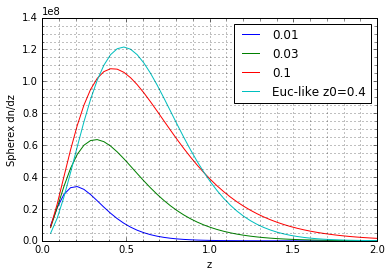

In [191]:
import astropy as ap
from astropy.cosmology import Planck15
from math import gamma
import astropy.constants as const
from scipy.optimize import curve_fit
cosmo=Planck15
def vol2proj(z):
    r_z = cosmo.comoving_distance(z) #Mpc
    return const.c.to('km/s') * r_z*r_z / cosmo.H(z)

def sx_dens_est(sigz, z):
    """volume density estimate from spherex paper (hand approximated)"""
    if sigz ==.01:
        return 0.0729 * np.exp(-9.016*z)
    elif sigz==0.03:
        return 0.0517*np.exp(-5.15*z)
    elif sigz==0.1:
        return 0.0499*np.exp(-3.603*z)
    else:
        print 'Please enter valid dz! {0.01, 0.03, 0.1}'
        return

def sx_dndz(sigz, z):
    return vol2proj(z)*sx_dens_est(sigz,z)

def expzdist(zx, z0, m, beta, a0):
    """return beta*z^m/[gamma((m+1)/beta)*z0^(m+1)] exp(-(z/z0)^beta), where beta=1.5, m=2, z0=0.7 is Euclid-like.
    This general form comes from Planck ISW paper where they fit a SDSS data to this generic dist. Generalization of Euclid dist."""
    return a0*beta*np.power(zx, m)/(z0**(m+1)*gamma((m+1.)/beta))*np.exp(-np.power((zx/z0),beta)) #euclid shape for given z0
    
def sx_euc_fit(zx, z0, a0):
    """return a0 * 1.5*z^2/z0^3 exp(-(z/z0)^1.5), where z0=0.7 is Euclid-like.
    This general form comes from Planck ISW paper where they fit a SDSS data to this generic dist. Generalization of Euclid dist."""
    return a0*1.5*np.power(zx, 1.5)/(z0**3)*np.exp(-np.power((zx/z0),1.5)) #euclid shape for given z0

def get_sx_dndz_pts(sigz, zcut=np.inf):
    """more presice extraction of points using engauge digitizer. Fit these volume pts to generic form. Estimated error of 10% per pt."""
    if sigz ==.003:
        zx=[0.10247,0.29579,0.44499,0.58486,0.66646]
        dens = [6.08E-03,1.56E-03,1.26E-04,1.14E-05,2.55E-06]
    elif sigz ==.01:
        zx=[0.10007,0.30033,0.42731,0.9107,1.13901]
        dens = [1.46E-02,6.20E-03,1.64E-03,2.16E-05,2.47E-06]
    elif sigz==0.03:
        zx=[0.10236,0.3026,0.49825,0.90576,1.29706,1.9025,2.49377,2.55668]
        dens = [2.24E-02,1.24E-02,3.19E-03,6.68E-04,4.29E-05,4.07E-06,4.07E-06,2.17E-06]
    elif sigz==0.1:
        zx=[0.09766,0.29556,0.49585,0.89865,1.29921,1.89764,2.49826,3.04072]
        dens = [3.64E-02,2.35E-02,7.49E-03,2.83E-03,3.57E-04,4.65E-05,2.91E-05,1.16E-05]
    elif sigz==0.2:
        zx=[0.10229,0.3002,0.49815,0.90093,1.30147,1.90916,2.49581,3.03127]
        dens = [4.72E-02,2.99E-02,1.05E-02,5.24E-03,8.57E-04,1.93E-04,1.23E-04,6.20E-05]
    else:
        print 'Please enter valid dz! {0.003, 0.01, 0.03, 0.1, 0.2}'
        zx,dens = (None,None)
    if zx != None:
        zx = np.asarray(zx)
        dens = np.asarray(dens)
        mask = zx<zcut
#         print mask
        dens = dens[mask]
        zx = zx[mask]
        dndz = vol2proj(zx) * dens
#         print zx
    return (np.asarray(zx), np.asarray(dndz))

def sx_dens_fit(sigz, zx = False, zcut=np.inf, fitfunc=expzdist):
    zdat, dndz_dat = get_sx_dndz_pts(sigz, zcut=zcut)
    pfit, pcov = curve_fit(fitfunc, zdat, dndz_dat, sigma=0.1*dndz_dat, p0=[0.5, 2, 1.5, 3e7],bounds=([0]*4,[2,5,5,np.inf]))
    if type(zx)==bool:
        zx = np.linspace(0.05,2,50)
    y = fitfunc(zx, *pfit) #fitted data for given zx
    return y

def get_sx_dndz_params(sigz, zcut=np.inf, getcov=False,geterrs=False, fitfunc=expzdist):
    """fit Spherex dndz data, return params of fit (z0, m, beta)"""
    zdat, dndz_dat = get_sx_dndz_pts(sigz, zcut=zcut)
    if fitfunc==expzdist:
        p0=[0.5, 2, 1.5, 3e7]
        bounds=([0]*4,[2,5,5,np.inf])
    elif fitfunc==sx_euc_fit:
        p0=[0.5, 3e7]
        bounds=([0]*2,[2,np.inf])
    pfit, pcov = curve_fit(fitfunc, zdat, dndz_dat, sigma=0.1*dndz_dat, p0=p0,bounds=bounds)
    if getcov:
        return pfit,pcov
    elif geterrs:
        perr = get_errs(pcov)
        print("\nFit parameters and parameter errors from curve_fit method :")
        print("pfit = ", pfit)
        print("perr = ", perr)
        return pfit, perr 
    else: return pfit

def get_errs(pcov):
    """get errors from diag of cov matrix of curve fit params"""
    err = [] 
    for i in xrange(len(pcov)):
        try:
          err.append(np.absolute(pcov[i][i])**0.5)
        except:
          err.append( 0.00 )
    return np.asarray(err) 
    
def SphereXPlot(sigz=0.1, z0=0.4):
    zx = np.linspace(.05,2,50)
    for sigz in [0.01, 0.03, 0.1]:
        plt.plot(zx, sx_dndz(sigz, zx), label=sigz)
# plt.yscale("log")
#     euclike=zx*zx*np.exp(-np.power((zx/z0),1.5))
    euclike = expzdist(zx=zx, z0=z0, m=2, beta=1.5,a0=1) #euclid-like dist for z0
    euclike = euclike/sum(euclike) #normalize
    a0=sum(sx_dndz(sigz, zx)) #number of galaxies with this sigz in spherex
    euclike= a0*euclike #scale euc to the same # of galaxies as spherex dist of sigz
#     fitted = expzdist(zx, .3, 2, 1.5, a0)
    print max(euclike)
    plt.plot(zx, euclike,label='Euc-like z0={0}'.format(z0))
#     plt.plot(zx, fitted,label='fitted')
    plt.xlabel('z')
    plt.ylabel('Spherex dn/dz')
    plt.legend()
    plt.minorticks_on()
    plt.grid(True,which='both')
    plt.show()
SphereXPlot(sigz=0.1)

Please enter valid dz! {0.01, 0.03, 0.1}
Please enter valid dz! {0.01, 0.03, 0.1}


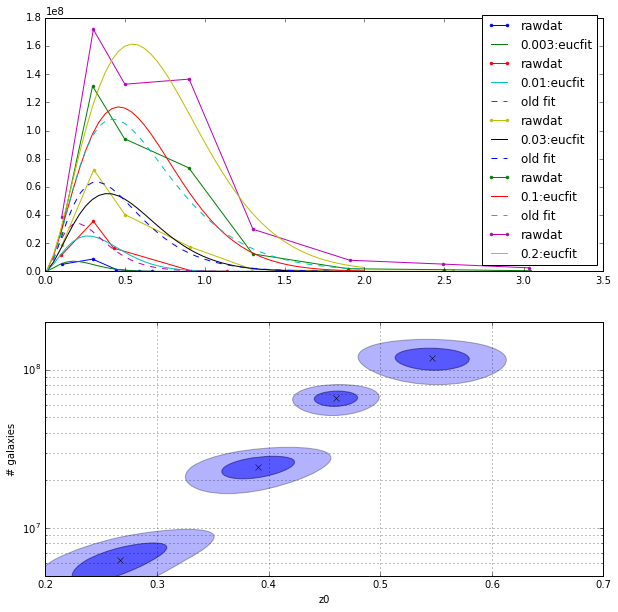

sigz,   z0,   a0/10^6
0.003,  0.178,  1
0.010,  0.266,  6
0.030,  0.391,  24
0.100,  0.460,  66
0.200,  0.547,  118
Sum =  215.977725829


In [192]:
def get_all_SX_params(plot=False, geterrs=False, zcutoff=True):
    this_zx = np.linspace(0.01,2,50)
    z0s=[]
    covs=[]
    a0s=[]
    sigzs=[.003,.01,.03,.1,.2]
    if zcutoff: zcuts = [.5,.75,1,1.5,2] #don't be beholden to far-out z points -- less impactful
    else: zcuts = [np.inf]*5 
    if plot: 
        fig, ax = plt.subplots(2,1, figsize=((10,10)))
    for i,my_sigz in enumerate(sigzs):
        eucpfit, euccov = get_sx_dndz_params(sigz=my_sigz, getcov=True, zcut=zcuts[i], fitfunc=sx_euc_fit)
        z0s.append(eucpfit[0])
        a0s.append(eucpfit[1])
        covs.append(euccov)
        if plot:
            xraw,yraw = get_sx_dndz_pts(my_sigz)
            ax[0].plot(xraw,yraw,'.-', label='rawdat')
            ax[0].plot(this_zx, sx_euc_fit(this_zx, *eucpfit),label='{0}:eucfit'.format(my_sigz))
            try:
                ax[0].plot(this_zx,sx_dndz(my_sigz, this_zx),'--',label='old fit')
            except: pass
            plt.grid(True)
            plt.legend(loc='best')
#             plt.show()
#             for i, sigz in enumerate(sigzs):
    #             ee.plot_cov_ellipse(covs[i], pos=(z0s[i], a0s[i]), ax=ax[1], alpha=.5, label=sigz)
            ee.plot_cov_ellipse(euccov, pos=(eucpfit[0], eucpfit[1]), ax=ax[1], nstd=1, alpha=.5, label=my_sigz)
            ee.plot_cov_ellipse(euccov, pos=(eucpfit[0], eucpfit[1]), ax=ax[1], nstd=2, alpha=.3, label=my_sigz)
            ax[1].plot(eucpfit[0], eucpfit[1], 'xk')
            #     print (covs[1], (z0s[1], a0s[1]))
        #     ee.plot_cov_ellipse(covs[1], pos=[z0s[1], a0s[1]],alpha=.5)
            ax[1].set_xlim(0.2,.7)

            ax[1].set_yscale('log')
            ax[1].set_ylim(5e6,2e8)
            ax[1].minorticks_on
            plt.grid(True, which='both')
            ax[1].set_xlabel('z0')
            ax[1].set_ylabel('# galaxies')
            ax[0].legend(loc='best')
            ax[1].legend(loc='best')
    if plot:plt.show()
    return (np.array(z0s), np.array(a0s))

z0s,a0s = get_all_SX_params(True)
print 'sigz,   z0,   a0/10^6'
for sigz,z0,a0 in zip([.003,.01,.03,.1,.2],z0s,a0s):
    print '{0:.3f},  {1:.3f},  {2:.0f}'.format(sigz, z0, a0/10**6)

print 'Sum = ',sum(a0s)/10**6 #SphereX paper says they get over 500M galaxies, but from fits they all sum to 200M.
                #And presumably the higher accuracy samples are subsets of the lower accuracy, so total would actually be just a0_sigz =

#     plt.errorbar(sigzs, z0s, [err[0] for err in errs])
#     plt.xlabel('sigz')
#     plt.ylabel('z0')

if 0:
    my_sigz=0.1
    my_z0=0.4
    myx,myy = get_sx_dndz_pts(my_sigz)
    this_zx = np.linspace(0.05,2.5,50)
    plt.plot(myx,myy,'.-', label='rawdat')
    plt.plot(this_zx,sx_dndz(my_sigz, this_zx),'.-',label='{0}:old fit'.format(my_sigz))
#     plt.plot(this_zx,expzdist(this_zx, z0=my_z0, beta=2, m=10, a0=3e7), label='custom')
#     plt.plot(this_zx, 3e7*1.5/.3**3*this_zx*this_zx*np.exp(-np.power((this_zx/0.3),1.5)), label='old dist')

    pfit, perrs = get_sx_dndz_params(sigz=my_sigz, geterrs=True, zcut=2)
    print zip(pfit, perrs)
#     my_a0 = expzdist(this_zx, *pfit)/
    plt.plot(this_zx, expzdist(this_zx, *pfit),label='new_fit')
    eucpfit, eucperrs = get_sx_dndz_params(sigz=my_sigz, geterrs=True, zcut=2, fitfunc=sx_euc_fit)
    plt.plot(this_zx, sx_euc_fit(this_zx, *eucpfit),label='euc_fit')
#     sx_fit = expzdist(this_zx, z0=my_z0, beta=1.5, m=2, a0=pfit[3])
#     plt.plot(this_zx,sx_fit, label='euclid 0.3')
    print zip(eucpfit, eucperrs)
#     plt.plot(this_zx, sx_dens_fit(my_sigz, this_zx),label='new_fit')
    plt.legend()
    plt.xlim(0,2)
    plt.grid(True)
    plt.show()
    

Looks like euc-fit of 0.5 

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


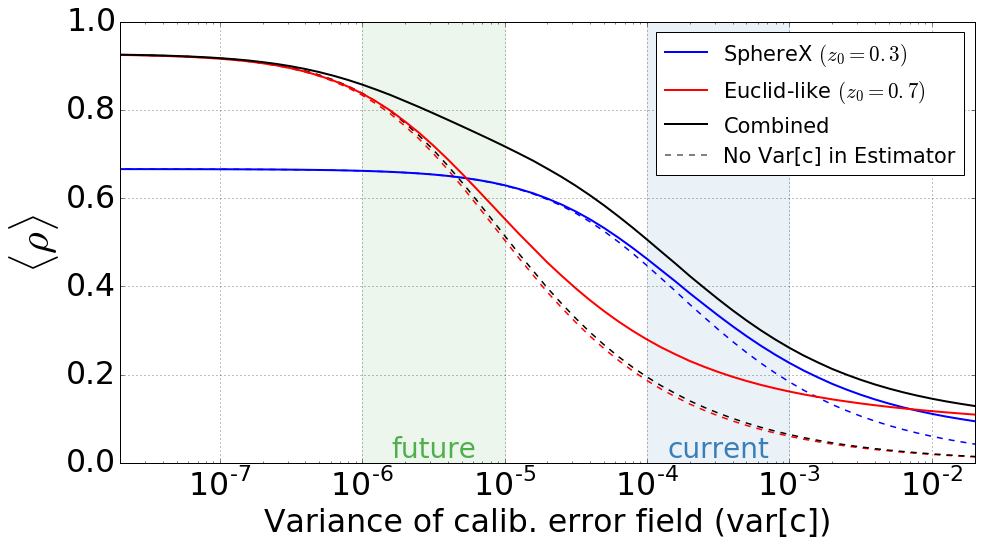

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


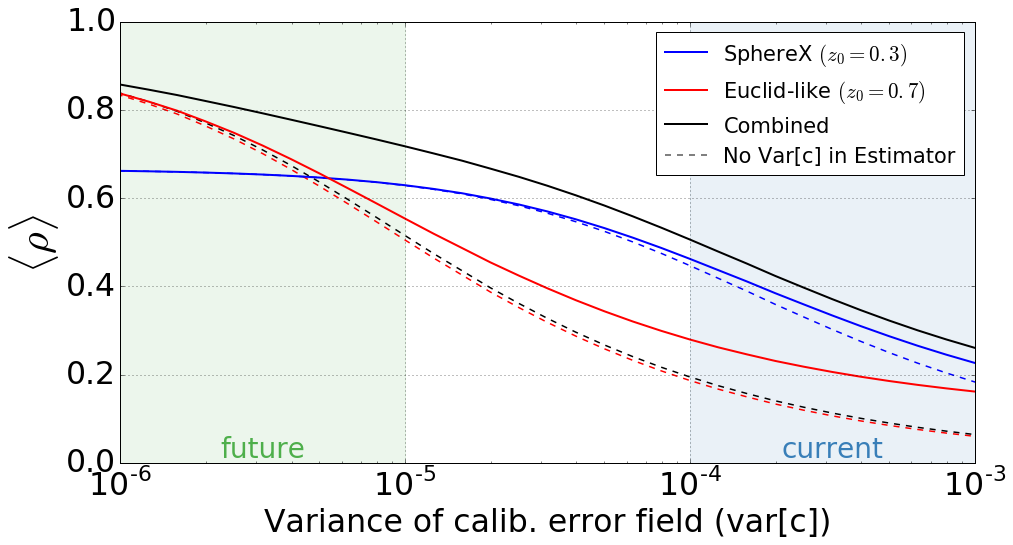

In [193]:

# def plot_sX(z0combolist=False, varname='rho', reclmin=2, nbar='default', fitbias=True, doCross=0, knowClCallist=[False,True], show=False,
#                  verbose=False,xlim=[2.e-8,2.e-2], title=False, pltscale=1.75):
#     """create plot of rho or s vs var[c] (or var[c]/var[gal]) for the combos of z0list with z0baselist. If z0baselist=None, then single survey plots."""
#     if z0combolist==False: z0combolist= getCombos([.3,.7])
#     else: z0combolist = [(z0,) if type(z0)!=tuple else z0 for z0 in z0combolist] #convert any single z0 values to tuples so can be read by next line
#     z0set = set(chain.from_iterable(z0combolist)) #get set of unique z0's from z0combolist
#     Nz0 = len(z0set)
#     outtag='mCal_full00'
#     #what points to plot
#     varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))

#     basevar=varlist[:]
#     (shape,width,lmincal,lmaxcal)=('g',10.,0,50)

#     fidcl=multi_get_Cl(justread=True, z0vals=z0set, nbar=nbar, outtag=outtag) #calculate the fiducial Cl's for all possible combos outside the loop
#     # print fidcl.bintaglist
#     # for fitbias in [True, False]:
# #     for (fitbias, varname) in [(True, 'rho'),(True, 's'),(False, 's')]: #fitbias tends to change rho little
# #colormap jazz for coordinating plot colors

#     fig, ax1 = calplotsetup(size=(8.75,5),scalar=pltscale)#size=(17,10))#(8.5,5))

#     cm=plt.get_cmap('hsv')#Spectral') #Dark2')#
#     cNorm=runeuc.colors.Normalize(vmin=0, vmax=max(z0set)) #max and min numbers colors need to span
#     scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
# #     z0cols=scalarMap.to_rgba(list(z0set))

# #     cm=plt.get_cmap('Dark2')#Spectral_r')
# #     cNorm=runeuc.colors.Normalize()#max and min numbers colors need to span
# #     scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
# #     z0cols=scalarMap.to_rgba(z0list_toplot)
# #     dashlist = [(None,None)]+[[8,4]+[2,4]*i for i in xrange(10)] #for dashes argument. First is solid line, then dashed, then dash dot, dash dot dot, dash dot dot dot, etc.

#     ltypes=('--','-',':')
#     for k,knowClCal in enumerate(knowClCallist):
#             lt = ltypes[k] #[i]

#             rho_sphrx = m_caltest_get_rhoexp2(z0_vals=(0.3,),fidcl=fidcl,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                         shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname=varname,
#                                         reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
    
#             rho_euc = m_caltest_get_rhoexp2(z0_vals=(0.7,),fidcl=fidcl,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                         shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname=varname,
#                                         reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
    
#             rho_combo = m_caltest_get_rhoexp2(z0_vals=(0.3,0.7),fidcl=fidcl,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                         shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname=varname,
#                                         reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
#             if not knowClCal: #don't give labels
#                 ax1.plot(varlist,rho_sphrx,lt,color='b',linewidth=1.5,label=None) #color=z0cols[j] #set dashes based on knowClCal
#                 ax1.plot(varlist,rho_euc,lt, color='r',linewidth=1.5,label=None) #color=z0cols[j] #set dashes based on knowClCal
#                 ax1.plot(varlist,rho_combo,lt, color='k',linewidth=1.5,label=None) #color=z0cols[j] #set dashes based on knowClCal
#             else:
#                 ax1.plot(varlist,rho_sphrx,lt,color='b',linewidth=2,label='SphereX $(z_0=0.3)$') #color=z0cols[j] #set dashes based on knowClCal
#                 ax1.plot(varlist,rho_euc,lt, color='r',linewidth=2,label='Euclid-like $(z_0=0.7)$') #color=z0cols[j] #set dashes based on knowClCal
#                 ax1.plot(varlist,rho_combo,lt, color='k',linewidth=2,label='Combined') #color=z0cols[j] #set dashes based on knowClCal
#             xlabel=r'Variance of calib. error field (var[c])'
#     #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))


#     if len(knowClCallist)>1: #if plotting both accounted and unaccounted for errors on same plot
#         ax1.plot(np.array([]),np.array([]),linestyle='--',linewidth=2,color='gray',label='No Var[c] in Estimator')
#     ax1=calplotform(ax1,varname=varname, showregions=True, xlabel=xlabel,scalar=pltscale) #format like caltest plot
#     if varname=='rho':
#         ax1.set_ylabel(r'$\langle \rho \rangle$')
#     elif varname=='s':
#         ax1.set_ylabel(r'$\langle s\rangle$')
#     if basevar==varlist: bvlabel = 'var[c]'
#     else: bvlabel='{0}'.format(basevar,)
#     # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
# #                 plt.title('Caltest - z0_base {0:.1f}, bvar {1}, fitbias={2}, lmin={3}, knowClCallist: {4}'.format(z0_base,bvlabel,fitbias,reclmin,knowClCallist))
#     if title:
#         plt.title(title)
#     else: plt.title('Caltest - bvar {0}, fitbias={1}, knowClCallist: {3}'.format(bvlabel,fitbias,reclmin,knowClCallist))
    
#     plt.xlim(xlim[0],xlim[1])
# #     plt.ylim(-1,1)
# #     ax1.set_ylabel(r'<{0}>'.format(varname,))
#     plotdir="/Users/nw/Desktop/plots/"#output/"+outtag+"/plots_forpaper/"
#     dt = datetime.datetime.now()
#     ts = '{0}{1:02d}{2:02d}_{3:02d}{4:02d}{5:02d}'.format(dt.year%2000,dt.month,dt.day,dt.hour,dt.minute,dt.second) #YYMMDDHHMM
#     outname=ts+'_cal_{0}.pdf'.format(varname,)
# #     plt.plot(varlist,[.5]*len(varlist),'k:')#line at rho=0.5
# #     print 'Saving plot to ',plotdir+outname
# #     plt.savefig(plotdir+outname,dpi=300)
#     if show: plt.show()
      
    

# mcal_plot_many_z0_2(z0combolist=[(0.3,),(0.7,),(0.3,0.7)],varnamelist=['rho'],
#                     reclminlist=[2], knowClCallist=[False], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0,show=True)
# mcal_plot_many_z0_2(z0combolist=[(0.3,),(0.7,),(0.3,0.7)],varnamelist=['rho'],
#                     reclminlist=[2], knowClCallist=[True], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0,show=True)

def plot_2z0s_DH(z0combolist=False, varname='rho', reclmin=2, nbar='default', fitbias=True, doCross=0, knowClCallist=[False,True], show=False,
                 verbose=False,xlim=[2.e-8,2.e-2], title=False, pltscale=1.75):
    """create plot of rho or s vs var[c] (or var[c]/var[gal]) for the combos of z0list with z0baselist. If z0baselist=None, then single survey plots."""
    if z0combolist==False: z0combolist= getCombos([.3,.7])
    else: z0combolist = [(z0,) if type(z0)!=tuple else z0 for z0 in z0combolist] #convert any single z0 values to tuples so can be read by next line
    z0set = set(chain.from_iterable(z0combolist)) #get set of unique z0's from z0combolist
    Nz0 = len(z0set)
    outtag='mCal_full00'
    #what points to plot
    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))

    basevar=varlist[:]
    (shape,width,lmincal,lmaxcal)=('g',10.,0,50)

    fidcl=multi_get_Cl(justread=True,z0vals=z0set, nbar=nbar, outtag=outtag) #calculate the fiducial Cl's for all possible combos outside the loop
    # print fidcl.bintaglist
    # for fitbias in [True, False]:
#     for (fitbias, varname) in [(True, 'rho'),(True, 's'),(False, 's')]: #fitbias tends to change rho little
#colormap jazz for coordinating plot colors

    fig, ax1 = calplotsetup(size=(8.75,5),scalar=pltscale)#size=(17,10))#(8.5,5))

    cm=plt.get_cmap('hsv')#Spectral') #Dark2')#
    cNorm=runeuc.colors.Normalize(vmin=0, vmax=max(z0set)) #max and min numbers colors need to span
    scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
#     z0cols=scalarMap.to_rgba(list(z0set))

#     cm=plt.get_cmap('Dark2')#Spectral_r')
#     cNorm=runeuc.colors.Normalize()#max and min numbers colors need to span
#     scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
#     z0cols=scalarMap.to_rgba(z0list_toplot)
#     dashlist = [(None,None)]+[[8,4]+[2,4]*i for i in xrange(10)] #for dashes argument. First is solid line, then dashed, then dash dot, dash dot dot, dash dot dot dot, etc.

    ltypes=('--','-',':')
    for k,knowClCal in enumerate(knowClCallist):
            lt = ltypes[k] #[i]

            rho_sphrx = m_caltest_get_rhoexp2(z0_vals=(0.3,),fidcl=fidcl,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                        shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname=varname,
                                        reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
    
            rho_euc = m_caltest_get_rhoexp2(z0_vals=(0.7,),fidcl=fidcl,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                        shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname=varname,
                                        reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
    
            rho_combo = m_caltest_get_rhoexp2(z0_vals=(0.3,0.7),fidcl=fidcl,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                        shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname=varname,
                                        reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
            if not knowClCal: #don't give labels
                ax1.plot(varlist,rho_sphrx,lt,color='b',linewidth=1.5,label=None) #color=z0cols[j] #set dashes based on knowClCal
                ax1.plot(varlist,rho_euc,lt, color='r',linewidth=1.5,label=None) #color=z0cols[j] #set dashes based on knowClCal
                ax1.plot(varlist,rho_combo,lt, color='k',linewidth=1.5,label=None) #color=z0cols[j] #set dashes based on knowClCal
            else:
                ax1.plot(varlist,rho_sphrx,lt,color='b',linewidth=2,label='SphereX $(z_0=0.3)$') #color=z0cols[j] #set dashes based on knowClCal
                ax1.plot(varlist,rho_euc,lt, color='r',linewidth=2,label='Euclid-like $(z_0=0.7)$') #color=z0cols[j] #set dashes based on knowClCal
                ax1.plot(varlist,rho_combo,lt, color='k',linewidth=2,label='Combined') #color=z0cols[j] #set dashes based on knowClCal
            xlabel=r'Variance of calib. error field (var[c])'
    #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))


    if len(knowClCallist)>1: #if plotting both accounted and unaccounted for errors on same plot
        ax1.plot(np.array([]),np.array([]),linestyle='--',linewidth=2,color='gray',label='No Var[c] in Estimator')
    ax1=calplotform(ax1,varname=varname, showregions=True, xlabel=xlabel,scalar=pltscale) #format like caltest plot
    if varname=='rho':
        ax1.set_ylabel(r'$\langle \rho \rangle$')
    elif varname=='s':
        ax1.set_ylabel(r'$\langle s\rangle$')
    if basevar==varlist: bvlabel = 'var[c]'
    else: bvlabel='{0}'.format(basevar,)
    # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
#                 plt.title('Caltest - z0_base {0:.1f}, bvar {1}, fitbias={2}, lmin={3}, knowClCallist: {4}'.format(z0_base,bvlabel,fitbias,reclmin,knowClCallist))
    if title:
        plt.title(title)
    else: plt.title('Caltest - bvar {0}, fitbias={1}, knowClCallist: {3}'.format(bvlabel,fitbias,reclmin,knowClCallist))
    
    plt.xlim(xlim[0],xlim[1])
#     plt.ylim(-1,1)
#     ax1.set_ylabel(r'<{0}>'.format(varname,))
    plotdir="/Users/nw/Desktop/plots/"#output/"+outtag+"/plots_forpaper/"
    dt = datetime.datetime.now()
    ts = '{0}{1:02d}{2:02d}_{3:02d}{4:02d}{5:02d}'.format(dt.year%2000,dt.month,dt.day,dt.hour,dt.minute,dt.second) #YYMMDDHHMM
    outname=ts+'_cal_{0}.pdf'.format(varname,)
#     plt.plot(varlist,[.5]*len(varlist),'k:')#line at rho=0.5
#     print 'Saving plot to ',plotdir+outname
#     plt.savefig(plotdir+outname,dpi=300)
    if show: plt.show()
        
        
# plot_2z0s_DH(varname='rho', reclmin=2, nbar='default', fitbias=False, knowClCallist=[False,True], show=True, verbose=False,title=' ')
plot_2z0s_DH(varname='rho', reclmin=2, nbar='default', fitbias=True, knowClCallist=[False,True], show=True, verbose=False,title=' ')
plot_2z0s_DH(varname='rho', reclmin=2, nbar='default', fitbias=True, knowClCallist=[False,True], show=True, verbose=False, xlim=[1e-6,1e-3],title=' ')

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


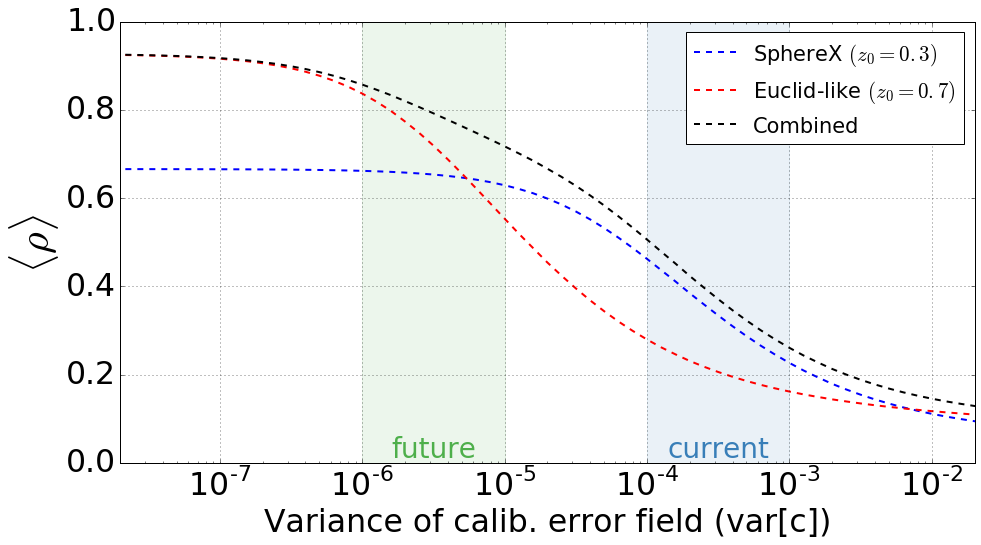

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


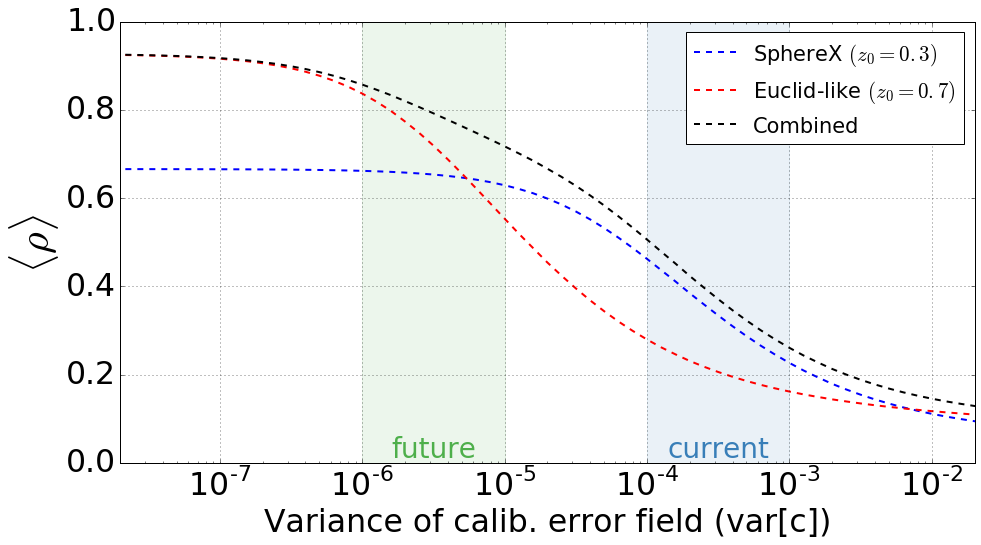

In [194]:
plot_2z0s_DH(varname='rho', reclmin=2, nbar='default', fitbias=True, knowClCallist=[True], show=True, verbose=False,title=' ')
plot_2z0s_DH(varname='rho', reclmin=2, nbar='default', fitbias=False, knowClCallist=[True], show=True, verbose=False,title=' ')

In [195]:
print getCombos(z0toplot,size=1)

[(0.2,), (0.3,), (0.5,), (0.7,), (0.9,)]


kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


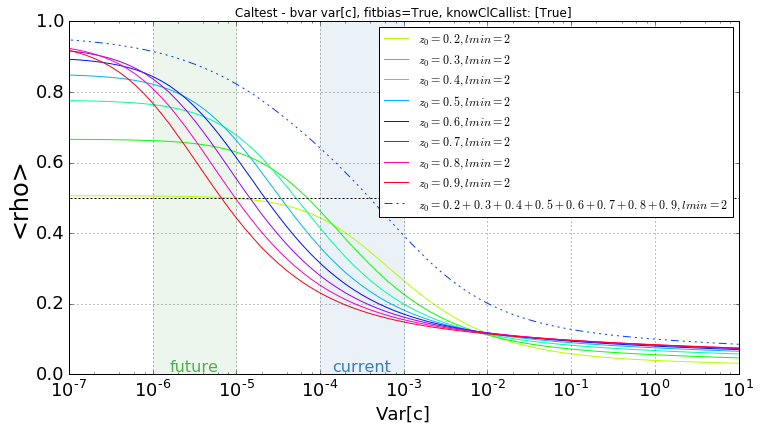

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal_full00/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


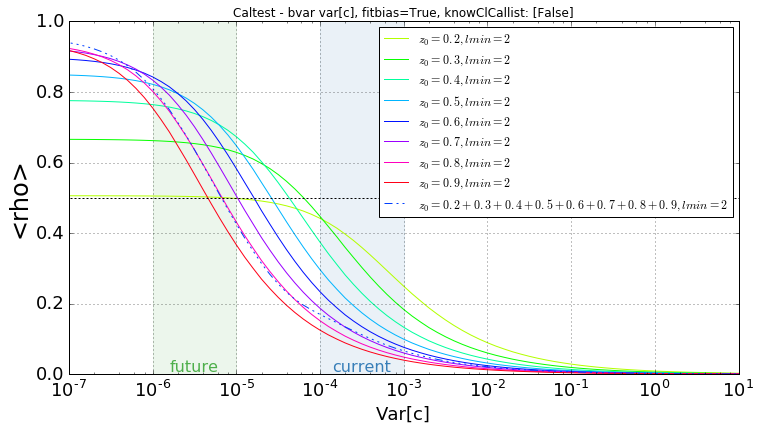

In [196]:
#Ultimate plot!
z0toplot=[.2,.3,.4,.5,.6,.7,.8,.9]
for knowClCal in [True,False]:
    mcal_plot_many_z0_2(z0combolist=getCombos(z0toplot,size=1)
                    +[tuple(z0toplot)],varnamelist=['rho'], reclminlist=[2], knowClCallist=[knowClCal], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0,show=True)


In [197]:
#look at 3 map combinations vs total combo
if 0:
    z0list=[.2,.3,.5,.7,.9]
    # z0toplot=getCombos(z0list,size=2,contains=0.7)+[(z0,) for z0 in z0list]
    z0toplot=getCombos(z0list,size=3,contains=0.7)+[tuple(z0list)]
    print z0toplot
    # z0toplot=[(.2,),(.3,),(.5,),(.7,),(.9,),(.2,.7),(.(.2,.3,.5,.7,.9)]
    print "\n-------single z0plots"
    mcal_plot_many_z0_2(z0combolist=z0toplot,varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0,knowClCallist=[True],show=True)
    mcal_plot_many_z0_2(z0combolist=z0toplot,varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0,knowClCallist=[False],show=True)


In [198]:
#heatmap of r_ell vs l vs var[c]
def rell_varc_heatmap(z0_vals=[.7], varlist=[], rell_list=[], Nell=95, title='',show=True):
    outtag='mCal_full00'
    (shape,width,lmincal,lmaxcal)=('g',10.,0,50)
    knowClCal=False
    fitbias=True
    if len(varlist)==0:
        varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=.1,Nperlog=10))

    if len(rell_list)==0:
        rell_list = m_caltest_get_rhoexp2(z0_vals=z0_vals[:],varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname='rell',
                                reclmin=2,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal, norectest=True)
    
    y = np.array(varlist)
    x = np.arange(0,Nell+1)
    X,Y=np.meshgrid(x,y)
#     plt.plot(rell_list[-1])
#     plt.show()
#     plt.imshow(rell_list, interpolation='none', extent=[0,95,minvar,maxvar])
#     plt.colorbar()
#     plt.show()
    plt.pcolor(X,Y,rell_list, vmin=0,vmax=1.) #vmin and vmax set scale of colorbar
    plt.colorbar()
    plt.plot(range(96),[10**-4]*96,'k--',label='Current')
    plt.plot(range(96),[10**-6]*96,'k-.',label='Future')
    plt.ylabel('var[c]')
    plt.xlabel('Multipole (ell)')
    if not title:
        title = 'Correlation by multipole b/n true and recon ISW, z0={0}, knowCl={1}, fitbias={2}'.format(z0_vals,knowClCal,fitbias)
    plt.title(title)
    plt.yscale('log')
    if show: plt.show()
    return 
#     print rell_list

In [199]:
#heatmaps
def compare_cal_rells():
    outtag='mCal_full00'
    knowClCal=False
    fitbias=False
    rell_varc_heatmap([.7])
    rell_varc_heatmap([.3])
    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=.1,Nperlog=10))
    rell_pred_depth=runeuc.depthtest_get_expected_rell(z0vals=np.array([.3]))[0]
    rell_pred_cal2=m_caltest_get_rhoexp2(z0_vals=[.3],varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                    shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname='rell',
                                    reclmin=2,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
    plt.plot(rell_pred_depth,label='depthtest no cal')
    plt.plot(rell_pred_cal2[0],'r--',label='caltest2 no cal')
    plt.plot(rell_pred_cal2[-1],'k--',label='caltest2 high cal')
    plt.legend()
    plt.show()
    rell_varc_heatmap([.5])
    rell_varc_heatmap([.7])
    plt.plot(m_caltest_get_rhoexp2(z0_vals=[.7],varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                    shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname='rell',
                                    reclmin=2,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)[-1])
    plt.show()

if 0:
    compare_cal_rells()

In [200]:
#compare impact of knowing Cl_vals for many z0.
#check how fitbias step changes behavior
if 0:
    z0toplot=[.2,.3,.5,.7,.9]
    print "\n-------single z0plots"
    mcal_plot_many_z0(z0list=z0toplot,z0baselist=None, varnamelist=['s'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
    mcal_plot_many_z0(z0list=z0toplot,z0baselist=None, varnamelist=['s'], reclminlist=[2], nbar='default', fitbias=False, scaleToVarGal=False, doCross=0)

varlist
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= False
Looking for Cl file: output/depthtest/Cl_output/Cl_depthtest.dat
Reading C_l file: output/depthtest/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  appending fiducial case, no calib error


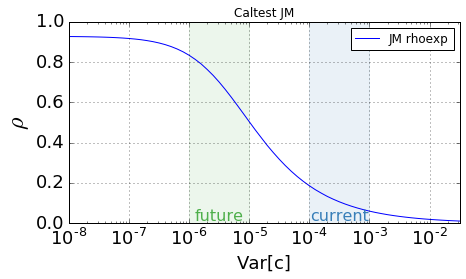

In [201]:
# print varlist
fig, ax1 = calplotsetup()
#test JM caltest to see if map crosspowers are being treated as correlated as well (seeing Cl_XY change with increasing var[c] even when X!=y for the multi tests)
#was doing this with print statements. Turns out it's due to the epsilon scaling, which becomes significant for very large var[c]
rhoexplist=[]#will be 1D; [variance ] 
rhoexplist=runeuc.caltest_get_rhoexp(varlist=varlist,lmax=50,lmin=1,shape='g',width=10,overwrite=True,doplot=False,
                              saverho=False,varname='rho',reclmin=reclmin)
ax1.plot(varlist[:-1],rhoexplist[:-1],'-',label='JM rhoexp')
ax1=calplotform(ax1,varname='rho') #format like caltest plot
plt.title('Caltest JM'.format(z0_base,bvlabel))
plt.show()

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/mCal02/Cl_output/Cl_depthtest.dat
Reading C_l file: output/mCal02/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


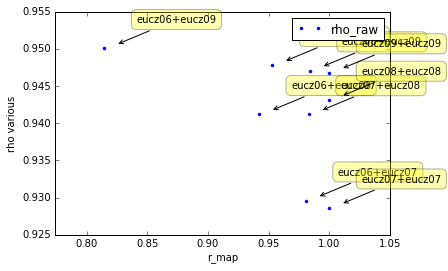


Nmaps: [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Maps to include:
[['eucz03_bin0'], ['eucz06_bin0'], ['eucz07_bin0'], ['eucz08_bin0'], ['eucz09_bin0'], ['eucz06_bin0', 'eucz07_bin0'], ['eucz06_bin0', 'eucz08_bin0'], ['eucz06_bin0', 'eucz09_bin0'], ['eucz07_bin0', 'eucz07_bin0'], ['eucz07_bin0', 'eucz08_bin0'], ['eucz07_bin0', 'eucz09_bin0'], ['eucz08_bin0', 'eucz08_bin0'], ['eucz08_bin0', 'eucz09_bin0'], ['eucz09_bin0', 'eucz09_bin0']]
['isw_bin0', 'eucz03_bin0', 'eucz05_bin0', 'eucz06_bin0', 'eucz07_bin0', 'eucz08_bin0', 'eucz09_bin0']


In [202]:
def m_z0toid(multi_list, z0_list):
    """convert a multi_list containing z0 values into one with indices of those values in z0_list, for input into multi_depthtest_get_reclist.
    e.g. m_z0toid([0.5,0.6,(.5,.6)], [0.3,0.4,0.5,0.6]) --> [2, 3, (2,3)]"""
    z0_list=list(z0_list)
    id_mult=[]
    for m in multi_list:
        if type(m)==tuple or type(m)==list:
            rtup=[]
            for z in m:
                rtup.append(z0_list.index(z))
            id_mult.append(tuple(rtup))
        else: id_mult.append(z0_list.index(m))
    return id_mult
            
depthtestz0=np.array([.3,.5,.6,.7,.8,.9])
nbar = 'default'
outtag='mCal02'
#rho_AB/(rho_a*rho_b) vs. r_AB
cldat=multi_get_Cl(justread=True,z0vals=depthtestz0, nbar=nbar, outtag=outtag)
#doMulti = getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
multi_z = [.3,.6,.7,.8,.9,(.6,.7),(.6,.8),(.6,.9),(.7,.7),(.7,.8),(.7,.9),(.8,.8),(.8,.9),(.9,.9)] #getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
reclist = multi_depthtest_get_reclist(depthtestz0, multi=m_z0toid(multi_z,depthtestz0), nbar=nbar)
mrs = [MRecStats(cldat, rec, use_nbar_in_r=True) for rec in reclist]

plot_mrslist(mrs, vartypes=['raw'],title=False, fitdeg=0, labplot=True)

print "\nNmaps:",[recdat.Nmap for recdat in reclist]
print "\nMaps to include:\n",[recdat.includeglm for recdat in reclist]
# rhopred = multi_depthtest_get_expected_rho(cldat=cldat,reclist=reclist,varname='rho')
print cldat.bintaglist

In [203]:
if 0: #generate MULTI depthhtest maps (don't want togr)
    Nreal=100
    simmaps=True #do you want to simulate maps, or just do reconstructions (on maps that already exist?
    z0vals=depthtestz0

    doMulti = range(len(depthtestz0)) + [(0,1),(0,2),(2,3),(0,1,2),(0,1,2,3)] #list of z0val maps to combine for reconstruction.

    #z0vals=np.array([0.7])
    if simmaps: #generate maps and do reconstructions
        multi_depthtest_get_glm_and_rec(Nreal=Nreal,z0vals=z0vals,justgetrho=False,minreal=0,dorho=1,dos=True,dochisq=False,dorell=0,dochisqell=False, multi=doMulti, outtag=outtag)
    else: #do recs based on existing galaxy maps
        runeuc.depthtest_iswrec(Nreal,z0vals=z0vals,minreal=0,dorho=1,dos=1,domaps=True, multi=doMulti, outtag=outtag)
        #note, if you just want t compute rho but don't want to redo isw recs
        # change domaps to False

if 0: #plot info about depthtest maps, assumes you've already done isw recs
    for r in xrange(10,20):
         #depthtest_TTscatter(r,depthtestz0,savepngmaps=False)
         pass
    for N in 1000*np.arange(1,10): #how much do results change with Nreal
        #depthtest_plot_rhohist(depthtestz0,varname='rho',firstNreal=1000,startrealat=N)
        pass
    depthtest_plot_rhohist(depthtestz0,varname='rho')
    depthtest_plot_rhohist(depthtestz0,varname='s')
    depthtest_TTscatter(13,depthtestz0,savepngmaps=True)

In [204]:
class SurvSpecs(object):
    """object containing survey specs, including z0, sigz, nbar, outtag, and finestN. This gives enough info to spec a Cl Data object file"""
    def __init__(self, survtype, z0, sigz, nbar, outtag, finestN):
        (self.survtype, self.z0, self.sigz, self.nbar, self.outtag, self.finestN) = (survtype, z0, sigz, nbar, outtag, finestN)
    def get_specs(self):
        return (self.survtype, self.z0, self.sigz, self.nbar, self.outtag, self.finestN)
    def print_specs(self):
        print "{0} type, z0= {1}, sigz= {2}, nbar= {3}, outtag= {4}, finestN= {5}".format(self.survtype, self.z0, self.sigz, self.nbar, self.outtag, self.finestN)

def testSX(sigz=0.1):
    """Plot SphereX recons varying f_xcorr"""
    cl_sx100 = getCl_sx(sigz=0.1)
    cl_sx030 = getCl_sx(sigz=0.03)
    print sigz
    allbincal_vary_f_xcorr(cl_in=cl_sx030, finestN=6,z0=.39,sigz=0.03,nbar=2.4e7, outtag='spx_6bin_00',survtype='spx',f_cl_obs=1)
    allbincal_vary_f_xcorr(cl_in=cl_sx100, finestN=6,z0=.46,sigz=0.1,nbar=6.6e7, outtag='spx_bintest_6bin_00',survtype='spx',f_cl_obs=1)
    allbincal_vary_f_xcorr(finestN=6,z0=0.7,nbar='default',f_cl_obs=1) #default euc 0.7

def specs2cl(survspecs, div=['111111'], justread=True):
    """take SurvSpecs object and binning div and return Cl data object for it"""
    this_cl = m_bintest_get_combo_Clvals(getdivs=div, justread=justread,
                                        finestN=survspecs.finestN, z0=survspecs.z0, sigz=survspecs.sigz, nbar=survspecs.nbar,
                                         outtag=survspecs.outtag, survtype=survspecs.survtype) 
    return this_cl

def specs2recdat(survspecs, div=[], reclmin=2):
    """take SurvSpecs object and binning div and return recdat object for it with given reclmin"""
    if len(div)==0: div=['1'*survspecs.finestN]
    else: assert div[0]!='all' and div[0]!='equal',div #only handle single binning scheme
    my_recdat=m_bintest_get_reclist(getdivs=div, finestN=survspecs.finestN, z0=survspecs.z0, sigz=survspecs.sigz, nbar=survspecs.nbar, survtype=survspecs.survtype,
                                        minl_forrec=reclmin)[0] #this should only be a list of length 1 anyways
    return my_recdat
 

def getsurv_euc(nbar=3.5e8):
    return SurvSpecs(survtype='euc', z0=0.7, sigz=0.05, nbar=nbar, outtag='m_btcaltest00', finestN=6)

def getRecDat_euc(div=['111111'],reclmin=2):
    return m_bintest_get_reclist(getdivs=div, minl_forrec=reclmin)[0] #default

def getCl_euc(div=['111111']):
    """get precomputed cl data object for spherex survey"""
    my_survspecs = getsurv_euc(nbar=nbar)
    my_cl = specs2cl(my_survspecs, div=div)
    return my_cl

def getsurv_spx(sigz, nbar='default'):
    """get survey specs for spx of given sigz, nbar, and binned according to div. Return SurvSpecs object. """
    if sigz==0.1:        
        if nbar=='default':
            nbar=6.6e7
        survspec = SurvSpecs(survtype='spx', z0=0.46, sigz=0.1, nbar=nbar, outtag='spx_bintest_6bin_00', finestN=6)
    elif sigz==0.03:
        if nbar=='default':
            nbar=2.4e7
        survspec = SurvSpecs(survtype='spx', z0=0.39, sigz=0.03, nbar=nbar, outtag='spx_6bin_00', finestN=6)
    return survspec

def getRecDat_sx(sigz, div=[], nbar='default', reclmin=2, calspecs=None):
    """return recdat for sphereX survey with given sigz, nbar, and reclmin"""
    my_survspecs = getsurv_spx(sigz=sigz, nbar=nbar)
    my_recdat = specs2recdat(my_survspecs, div=div, reclmin=reclmin)
    return my_recdat

def getCl_sx(sigz, div=['111111'], nbar='default'):
    """get precomputed cl data object for spherex survey"""
    my_survspecs = getsurv_spx(sigz=sigz, nbar=nbar)
    my_cl = specs2cl(my_survspecs, div=div)
    return my_cl

def makeSX_cls():
    """Plot SphereX recons varying f_xcorr"""
    z0 = 0.39
    sigz=0.03
    nbar=2.4e7
    finestN=6
    outtag='spx_6bin_00'
    
# testSX()


# cl_sx1 = m_bintest_get_baseClvals(finestN=6,z0=z0,sigz=sigz,nbar=nbar,justread=False,outtag=outtag,survtype='spx') #get fiducial Cl's for even-split bins
# makeSX_cls()

In [205]:
# --------- BINTEST -----------

def m_bintest_get_binmaps(finestN=6,getdivs=['all'],z0=0.7,sigz=0.05,nbar=3.5e8,includeisw=True,justfinest=True, survtype='euc',
                          getMaptypes=False):
    if justfinest:
        getdivs=['1'*finestN]
    maptypes=runeuc.bintest_get_maptypelist(finestN=finestN,getdivs=getdivs,z0=z0,sigz=sigz,nbar=nbar,includeisw=includeisw, survtype=survtype)
    binmaps,bintags = mp.get_binmaplist(maptypes)
    print '\n nbar = ',[bm.nbar for bm in binmaps]
    if getMaptypes:
        return (binmaps,maptypes)
    else:
        return binmaps

# Get/generate Cl for 6 (or largest number of) bins
def m_bintest_get_baseClvals(finestN=6,z0=0.7,sigz=0.05,nbar=3.5e8,justread=True, outtag='',survtype='euc'):
    binmaps=m_bintest_get_binmaps(finestN,z0=z0,sigz=sigz,nbar=nbar,justfinest=True,survtype=survtype)
    zmax=max(m.zmax for m in binmaps)
    rundat = clu.ClRunData(tag='{2}bintest{0:d}s{1:03d}'.format(finestN,int(1000*sigz),survtype),iswilktag='{0}bintest'.format(survtype),
                           rundir='output/'+outtag+'_m_{0}bintest/'.format(survtype),lmax=95,zmax=zmax)
    return gcc.getCl(binmaps,rundat,dopairs=['all'],DoNotOverwrite=justread)

# 161219: NEED TO FINISH THIS. CHECKING BINNING FIRST
# Get/generate Cl for 6 (or largest number of) bins
def get_sx_and_euc_cls(finestN=6,z0=0.7,sigz=0.05,nbar=3.5e8,justread=True, outtag='',survtype='euc'):
    binmaps=m_bintest_get_binmaps(finestN,z0=z0,sigz=sigz,nbar=nbar,justfinest=True,survtype=survtype)
    zmax=max(m.zmax for m in binmaps)
    rundat = clu.ClRunData(tag='{2}bintest{0:d}s{1:03d}'.format(finestN,int(1000*sigz),survtype),iswilktag='{0}bintest'.format(survtype),
                           rundir='output/'+outtag+'_m_{0}bintest/'.format(survtype),lmax=95,zmax=zmax)
    return gcc.getCl(binmaps,rundat,dopairs=['all'],DoNotOverwrite=justread)

# if base cls are calcualted (the ones for finest bin divisions)
#      iterate through divisions, combining bins and save results
# if base cls not calcualated, computes them, then does bin combos
# if both already done, or justread, just reads in existing data 
#this doesn't actually work to read in external data as far as I can tell. If justread, then it only reads in the baseCls,
# with the base binmaps. Since I think combining bins is pretty quick, I changed it to take a "getdivs" argument and it will
#read in the base cls and combine bins as determined by getdivs, returning that cl. Justread then just determines whether it will
#write the cls to file. [160825 NJW]
def m_bintest_get_combo_Clvals(finestN=6,z0=0.7,sigz=0.05,getdivs=['all'],nbar=3.5e8,justread=True,outtag='',survtype='euc', reduced=False):
    """get info for isw and finest binned division, calculate cls, then compute combined bins per getdivs specification"""
#     if not justread:
    basecl=m_bintest_get_baseClvals(finestN=finestN,z0=z0,sigz=sigz,nbar=nbar,justread=justread,outtag=outtag,survtype=survtype)
    if getdivs==['1'*finestN]:
        return basecl
#     print '\n get Combo Clvals. finestN=',finestN
#     print basecl.bintaglist
    basemaptype=runeuc.bintest_get_maptypelist(finestN,['1'*finestN],z0,sigz=sigz,nbar=nbar,includeisw=False,survtype=survtype)[0]
    basemaptag=basemaptype.tag
#         maptypes=runeuc.bintest_get_maptypelist(finestN,['all'],z0,sigz,includeisw=False,survtype=survtype)  
    maptypes=runeuc.bintest_get_maptypelist(finestN,getdivs,z0,sigz=sigz,nbar=nbar,includeisw=False,survtype=survtype)  
#         print maptypes
    # combine bins to get Cl for other divisions
    FIRST=True
    allcombotaglist=[]
    for mt in maptypes:
        t=mt.tag
        print 'on maptype',t,'------'
        if t!=basemaptag: #if it's not the base map type
            divstr=runeuc.bintest_divstr_from_maptag(t)
            combinebins=runeuc.bintest_combinewhich(divstr,finestN)
#                 print ' combinebins=',combinebins
#                 print 'combinebins',combinebins
            for i in xrange(len(combinebins)):
                combolist=combinebins[i]
                intags=[''.join([basemaptag,'_bin',str(x)]) for x in combolist]
                combotag=''.join([t,'_bin',str(i)]) #note that this is called "outtag" in the original bintest_get_Clvals, but NW has been using outtag as a passed output tag
#                     print '   combining',intags
#                     print '      to get',combotag
                allcombotaglist.append(combotag)
                if FIRST:
#                     nextcl=gcc.combineCl_binlist(basecl,intags,combotag=combotag,newruntag=basecl.rundat.tag+'all',renamesingle=True)
                    nextcl=gcc.combineCl_binlist(basecl,intags,combotag=combotag,newruntag=basecl.rundat.tag+getdivs[0],renamesingle=True)
                    FIRST=False
                else:
                    nextcl=gcc.combineCl_binlist(nextcl,intags,combotag=combotag,renamesingle=True)
#                     print '   nextcl.Nmap',nextcl.Nmap,'nextcl.Ncross',nextcl.Ncross
#                     print '   len(nextcl.docross)',len(nextcl.docross)
        #write to file
    if not justread:
        gcc.writeCl_file(nextcl)
#     else:
#         #read in data that has already been combined
#         binmaps=m_bintest_get_binmaps(finestN,z0=z0,sigz=sigz,survtype=survtype)
#         zmax=max(m.zmax for m in binmaps)
# #         rundat = clu.ClRunData(tag='{2}bintest{0:d}s{1:03d}'.format(finestN,int(1000*sigz),survtype),iswilktag='{0}bintest'.format(survtype),
# #                                rundir='output/'+outtag+'_m_{0}bintest/'.format(survtype),lmax=95,zmax=zmax)
#         runtag = '{2}bintest{0:d}s{1:03d}all'.format(finestN,int(1000*sigz),survtype) #added 'all' to end, since combo cl has this appended, so if we want to open it need this in there [NJW 160824]
#         rundat = clu.ClRunData(tag=runtag,iswilktag='{0}bintest'.format(survtype),
#                                 rundir='output/'+outtag+'_m_{0}bintest/'.format(survtype),lmax=95,zmax=zmax)
#         nextcl= gcc.getCl(binmaps,rundat,dopairs=['all'],DoNotOverwrite=True)
        #it may actually be quicker to recalc the combos since the all file for finestN=6 is ~15MB, but we'll see.
#         print 'nextcl.Ncross',nextcl.Ncross
#         print 'nextcl.docross.size',len(nextcl.docross)
#         print 'bintaglist: ',nextcl.bintaglist
    if reduced and getdivs!=['all']:
        nextcl = gcc.get_reduced_cldata(nextcl,dothesemaps=allcombotaglist) #drop columns not associated with our getdivs (I think it will drop the base ones then? Mainly for calbin map reconstruction 170116)
    return nextcl

def m_bintest_get_reclist(finestN=6,z0=0.7,sigz=0.05,getdivs=['all'],nbar=3.5e8,justfinest=False,survtype='euc',minl_forrec=2):
    """Return list of RecData objects, one per binning scheme. If using maps with calib error, requires varlist object"""
    #get binmaps
    if justfinest:
        getdivs=['1'*finestN]
    maptypes= runeuc.bintest_get_maptypelist(finestN,getdivs,z0,sigz,nbar=nbar,includeisw=False, survtype=survtype)
    Nmaps=len(maptypes)
#     print 'Nmaps = ',Nmaps
    reclist=[]
    for i in xrange(Nmaps):
        mtype=maptypes[i]
        inmaptag=mtype.tag #label in output glmdat
        includeglm=[b.tag for b in mtype.binmaps]
#         print 'include glm',includeglm
        recdat = au.RecData(includeglm=includeglm,inmaptag=inmaptag,minl_forrec=minl_forrec)
        reclist.append(recdat)
    return reclist

#Adapted from runeuc.bintest_get_rhoexp function
def m_bintest_get_rhoexp(finestN=6,z0=0.7,sigz=0.05,overwrite=False,doplot=True,getdivs=['all'],saverho=False,varname='rho',outtag='',survtype='euc'):
    if saverho:
        outdir = 'output/'+outtag+'_m_eucbintest/plots/'
        datfile='m_{2}bintest{0:03d}_{1:s}exp.dat'.format(int(1000*sigz),varname,survtype)
    
        print datfile
        if not overwrite and os.path.isfile(outdir+datfile): #file exists #[added "import os" statement NJW 160606]
            x=np.loadtxt(outdir+datfile)
            divstr=[str(int(x[i,0])) for i in xrange(x.shape[0])]
            rhoarray=x[:,1]
        else:
            #get cl
            cldat=m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=getdivs,justread=not overwrite,outtag=outtag,survtype=survtype) 
            #set up recdata objects for each bin combo
            reclist=m_bintest_get_reclist(finestN,z0,sigz,getdivs,survtype='euc') 
            Nrec=len(reclist)
#             print reclist
            rhoarray=np.zeros(Nrec)
            if getdivs==['all']:
                divstr=runeuc.bintest_get_divstr_all(finestN) #string div labels
            elif getdivs==['equal']:
                divstr=runeuc.bintest_get_divstr_equal(finestN)
            else:
                divstr=getdivs
            for r in xrange(Nrec):
                rhoarray[r]=au.compute_rho_fromcl(cldat,reclist[r],varname=varname)
            #write rhoarray to file
            f=open(outdir+datfile,'w')
            f.write(''.join(['{0:8s} {1:8.3f}\n'.format(divstr[i],rhoarray[i]) for i in xrange(Nrec)]))
            f.close()
    else: #don't interact with files, just compute

        #set up recdata objects for each bin combo
        if getdivs==['all']:
            divstr=runeuc.bintest_get_divstr_all(finestN) #string div labels
        elif getdivs==['equal']:
            divstr=runeuc.bintest_get_divstr_equal(finestN)
        else:
            divstr=getdivs
        #get cl
        cldat=m_bintest_get_combo_Clvals(finestN=finestN,z0=z0,sigz=sigz,getdivs=divstr,justread=not overwrite,outtag=outtag,survtype=survtype)
        reclist=m_bintest_get_reclist(finestN=finestN,z0=z0,sigz=sigz,getdivs=divstr,survtype=survtype) 
        Nrec=len(reclist)
        rhoarray=np.zeros(Nrec)
        for r in xrange(Nrec):
            rhoarray[r]=au.compute_rho_fromcl(cldat,reclist[r],varname=varname)
#     print rhoarray
    if doplot:
        zedges0=runeuc.bintest_get_finest_zedges(finestN,z0)
        allzedges=runeuc.bintest_get_zedgeslist(zedges0,['all'],False)
#         print divstr
        runeuc.bintest_rhoexpplot(allzedges,divstr,rhoarraylist=[rhoarray],varname=varname,saveplot=False)
#     print varname
    return divstr,rhoarray


def multi_get_maptypelists(surv_in_list):
    """surv_in_list = [(survspecs1, div1), (survspecs2, div2), ...].
        Get maptypes for each survey combo passed. Return [maptype1, maptype2, ...]"""
    survmaps=[]
    for (myss, mydiv) in surv_in_list:
        mtype = runeuc.bintest_get_maptypelist(finestN=myss.finestN, getdivs=mydiv, z0=myss.z0, sigz=myss.sigz,
                                               nbar=myss.nbar, includeisw=False, survtype=myss.survtype) #list with maptype for each bin
        survmaps.append(mtype)
        print 'multi_get_maptypelists, tags: ',[b.tag for b in mtype]
#         inmaptag=mtype.tag #label in output glmdat
#         includeglm=[b.tag for b in mtype.binmaps]
    return survmaps

def multi_get_binmaps(surv_in_list):
    """surv_in_list = [(survspecs1, div1), (survspecs2, div2), ...].
        Combines all survey bins of all surveys, returns binmap list."""
    survmaps_list = multi_get_maptypelists(surv_in_list)
    allbinmaps=[]
    for surv in survmaps_list:
        binmaps, bintags = mp.get_binmaplist(surv)
        allbinmaps = allbinmaps + binmaps #aggregate all the binmaps
        print bintags
    print 'tot binmaps= ',allbinmaps
    return binmaps

def multi_reduce_Cl(surv_in_list, cl_dat):
    """drop the Cl entries that we don't want (e.g. drop base ones if doing div=['222']. modeled off runeuc.bintest_get_glm_and_rec()"""
    taglist=['isw_bin0'] #don't drop isw. Will need to also add CMB if doing that.
    survmaps = multi_get_maptypelists(surv_in_list)
    for sm in survmaps: #for each survey
        taglist = taglist + [mt.tag for mt in sm] #mt for each bin
    print taglist
    print cl_dat.bintaglist
    print 'reducing Cl...'
    red_cldat=gcc.get_reduced_cldata(cl_dat, dothesemaps=taglist)
    return red_cldat
    
def MDtest_get_binmaps(includeisw=True,Ndesbins=[2,3],nvss=True):
    surveys=MDtest_get_maptypelist(Ndesbins=Ndesbins,nvss=nvss)
    bins=[]
    for survey in surveys:
        bins=bins+survey.binmaps
    if includeisw:
        iswmaptype = mu.get_fullISW_MapType(zmax=15)
        iswbins = iswmaptype.binmaps
        bins=iswbins+bins
    return bins

def MDtest_get_Cl(justread=True,Ndesbins=[2,3],nvss=True): #do a survey splitting DES into 2 bins and one splitting into 3 bins. NVSS is just one bin
    surveys = MDtest_get_maptypelist(Ndesbins=Ndesbins,nvss=nvss) #each 
    bins = MDtest_get_binmaps(Ndesbins=Ndesbins,nvss=nvss) #each redshift bin for each bin is its own map
    zmax = max(m.zmax for m in bins) #make sure integrate out to highest z of all the maps
    rundat = clu.ClRunData(tag='MDtest',rundir='output/MDchecks/',lmax=95,zmax=zmax,iswilktag='fidisw',noilktag=True)
    #this object holds a bunch of info needed to do the integrals ^^
    pairs=['all']
    #pair up isw and each LSS maps, but not lss maps together 
    # for s in surveys:
    #     pairs.append((s.tag,'isw'))
    #     pairs.append((s.tag,s.tag))
    cldat=gcc.getCl(bins,rundat,dopairs=pairs,DoNotOverwrite=justread)
    #pass binobjject, rundata object, computer all crosspairs, if already have Cls, best to have DNO = True. Rundata will tell it where the output file is.
    #can pass specific bins (which must be in the output). So don't need to recompute all the time. So this function mostly gets used to just read them in.
    return cldat



def m_calbin_get_reclist(cldat, surv_info_list, calspecs, varlist, recminelllist=np.array([2]), useObsCl=False, addfiducial=True):
    """list with recdat for each rec_ell_min, for each variance in varlist. using all maps of cldat (so pass cl_reduced). Add fiducial to end by default.
    e.g. [recdat_var0_lmin1, recdat_var0_lmin2, recdat_var1_lmin1, recdat_var1_lmin2, ..., recdat_varN_lmin0, recdat_varN_lmin1]"""
#     shape='g',width=10.,lmin=0,lmax=30,
#     cl_reduced = get
    cl_red = cldat #assume passed cl_reduced already
    reclist=[]
    # get glmdata object with fiducial (no calib error) bin and isw info
    #   is a dummy glmdata object; no data or realizations, just map names
    fidglm=gmc.get_glm(cl_red,Nreal=0,matchClruntag=True) #dummy glm for filepath and map info.
    allfidbins = multi_get_binmaps(surv_info_list) #does not include isw
    
# #     lssbin=fidbins[1].tag #will just be the depthtest bin map
    lssbins = [fidbin.tag for fidbin in allfidbins] 
    assert len(set([fidbin.typetag for fidbin in allfidbins]))==1, [fidbin.typetag for fidbin in allfidbins] #ensure all have same typetag
    typetag = allfidbins[0].typetag
    
#     fidbins=caltest_get_fidbins() #(includes isw map, unlike multi_get_binmaps, hence index difference)
#     lssbin=fidbins[1].tag #will just be the depthtest bin map 
#     lsstype=fidbins[1].typetag
#     includecl=[lssbin]
#     inmaptype=lsstype
    for var in varlist: #do in groups to simplify -- all these maps and modtags will be used together
        #will add calib errors to all maps that contain mapstr, so would be more efficient if had a mapstr that encompassed all maps wanted...
        calinfolist=[(mapstr,var,calspecs.lmaxcal,calspecs.shape,calspecs.width,calspecs.lmincal) for mapstr in lssbins] ##     calinfolist=[(lssbin,v,lmax,shape,width,lmin) for v in varlist]

#     fidglm=caltest_get_fidglm()
        modsforrec=gmc.get_fixedvar_errors_formaps(fidglm,calinfolist,overwrite=False,Nreal=0) #returns [(maptag,modtag,masktag)]list
        # ^^ all these have the same modtag, only map changing map
        assert len(set([tup[1] for tup in modsforrec]))==1, modsforrec #ensure all have same modtag
        rectag = modsforrec[0][1] #modtag
#         if useObs:
#             rectag = modsforrec[0][1]+'-obs' #modtag
#         else:
#             rectag = modsforrec[0][1]+'-fid'
    #put fidicual in
#         for m in dothesemods:
#         includeglm=[m] #set this to be a list of tuples with the maps to use for recon. E.g. one var, tuple for each bin.
#         rectag=modsforrec[1]#modtag
        maps_for_thry = [tup[0] for tup in modsforrec] #maptags
        for recminell in recminelllist:
        #not sure what should put for includecl. If don't include, equates to includeglm but sets rectag to 'fid' so it uses cl_model.
        #I think that's actually what we want, so that it uses the modified maps as data (includeglm) but theory cl.
        #When use useObsCl, substitutes Cl from maps for LSS entries.
            reclist.append(au.RecData(includeglm=modsforrec,includecl=maps_for_thry,inmaptag=typetag,rectag=rectag,minl_forrec=recminell,
                                      useObsCl=useObsCl, userectags_fortrueisw=True))
# add fiducial case
    if addfiducial:
        for recminell in recminelllist:
#         reclist.append(au.RecData(includecl,includecl,inmaptype,'unmod',recminell))
            reclist.append(au.RecData(includeglm=lssbins,includecl=lssbins,inmaptag=typetag,rectag='unmod',minl_forrec=recminell, useObsCl=useObsCl)) #list of strings instead of tuples for includeglm results in modtag=fid and fullsky by default

    return reclist #includes fiducial case as first entry


In [268]:
# 170203 -- THIS IS DEPRECIATED. NOW CREATING MAPS FROM CL DIRECTLY
def applyCal_toMaps(doRec=True, useObsCl=True):
#     my_cldat = getCl_euc(div=['6'])
#     my_recdat = getRecDat_euc(div=['6']) #only use recdat for lssbins to add calib to
#     recminelllist=np.array([2])
    shortvarlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2] #var[c] value to simulate
#     shortreclminlist=np.array([2,3,5,10])#1,3,10])
    shortreclminlist=np.array([2])#1,3,10])
    
    mydiv=['6']
    calspecs = CalibSpecs(shape='g',width=10.,lmincal=0,lmaxcal=50)
    (my_cldat,surv_info_list) = getcalbin_fidcl_survinfo(div=mydiv)# getcalbin_fidcl(div=mydiv) # getCl_sx(sigz=0.1, div=mydiv)
    print 'cl bintaglist:',my_cldat.bintaglist
    my_reclist = m_calbin_get_reclist(my_cldat, surv_info_list, calspecs, varlist=shortvarlist, recminelllist=np.array([2]), useObsCl=useObsCl)
#     my_reclist = [getcalbin_fidrec(reclmin=recl) for recl in shortreclminlist]##[getRecDat_sx(sigz=0.1, div=mydiv, reclmin=recl) for recl in shortreclminlist]#
    
    
#     mapstoaddcal= my_reclist[0].includeglm #list(set([recdat.includeglm for recdat in reclist])) 
    mapstoaddcal = get_maps_from_reclist(my_reclist) #add calib to all maps that will need reconstruction.

#     print [mmtup[0] for my_recdat in my_reclist for mmtup in my_recdat.includeglm if type(mmtup)==tuple else ] #includeglm is list of tuples of (map,mod,mask) to read from
#     print [my_recdat.includeglm for my_recdat in my_reclist] #includeglm is list of tuples of (map,mod,mask) to read from
    print 'ayo'
#     print np.concatenate(tuple([my_recdat.includeglm for my_recdat in my_reclist]))
#     mapstoaddcal= list(set(np.hstack([my_recdat.includeglm for my_recdat in my_reclist]))) #list(set([recdat.includeglm for recdat in reclist])) #add calib to all maps that will need reconstruction.
#     print mapstoaddcal
#     assert set([recdat.includeglm for recdat in reclist])==mapstoaddcal #ensure all recdats in reclist have same mapname lists, else need to do 

    Nreal = 10
    
    m_caltest_apply_caliberrors(cldat=my_cldat, mapstoaddcal=mapstoaddcal, calspecs=calspecs, Nreal=Nreal,
                                varlist=shortvarlist,overwritecalibmap=False,scaletovar=1.e-3) #only do once    
    if doRec:
        m_caltest_iswrec(cldat=my_cldat,reclist=my_reclist,Nreal=Nreal,calspecs=calspecs,varlist=shortvarlist,
                         scaletovar=1.e-3,domaps=True) #set domaps=False if you just want to calculate rho, s
    return


def getcalbin_fidrec(reclmin=2):
    return getRecDat_euc()

    
    ## 161221 you are here working on seeing how to generate base maps, then read those in to apply calib errors and write rho files,
    # then read those for the datplot in order to get errorbars. Verify this works for a generic survey (right now Runeuc.caltest_getrhodat_fromfiles
    # has mapdir and filename hardcoded in). 

def getcalbin_fidcl_survinfo(div=['6']):
    '''get (fid_cl, surv_info_list) for multi-calib-bin test. surv_in_list = [(survspecs1, div1), (survspecs2, div2), ...].
    Reduces fid_cl to bins in surv_info_list by default.'''
    surv_info_list = [(getsurv_euc(),div)]#,(getsurv_spx(sigz=0.1), calspecs, div)] #use default params
    my_cl = getCl_euc(div=div)
    #WILL NEED TO CHANGE THESE FOR REAL CL
    print 'unreduced taglist:',my_cl.bintaglist
    print type(my_cl.bintaglist)
    cl_red = multi_reduce_Cl(surv_info_list, my_cl)
    return (cl_red, surv_info_list)

#---------------------------------------------------------------
# generate maps, do reconstructions
#---------------------------------------------------------------
# generate reference maps with variance of say, 1.e-2
# rescale approrpiately when doing recs
# If Nreal==0, does no map making, just returns dummyglm containing mapnames

#170201 -- actually not taking this route. Think it's easier to just mod the cldat object with cl_cal and then create map from that, instead of creating separate calib error maps and then adding them to LSS maps as needed.
# Will take longer, since create cl_cal for each variance, but then don't have to deal with getting correct calib maps and dealing with cross-correlation between them.
def m_caltest_apply_caliberrors(cldat, mapstoaddcal, varlist,calspecs, Nreal=0,overwritecalibmap=False,scaletovar=False,redofits=True):
    """Create maps with calib errors. Uses cldat for filepaths, adds calib error for each variance in varlist to each map in mapstoaddcal.
    scaletovar is for if want to define the base variance. Otherwise just uses the default (1.e-3?). Can set Nreal=0 to just get mapnames of the calib maps (e.g. for reconstruction functions)
    difference from runeuc.caltest_apply_caliberrors is input compactified and binnames are gotten differently"""
    print 'IN m_caltest_apply_caliberrors with NREAL=',Nreal
    outglm_list = []
    print 'varlist',varlist
    refvar,refind=runeuc.caltest_get_scaleinfo(varlist,scaletovar) #gets reference variance and its index in varlist (since gen c(n) for one var and then scale it for other vars)
    #print 'refvar,refind',refvar,refind
    #get fid glmdat; no data needed, just mapnames, et
#         fidbins=caltest_get_fidbins()
#         lssbin=fidbins[1].tag #will just be the depthtest bin map

    #print 'lssbin',lssbin
#     glmdat=caltest_get_fidglm()
    # get glmdata object with fiducial (no calib error) bin and isw info
    #   is a dummy glmdata object; no data or realizations, just map names
    glmdat=gmc.get_glm(cldat,Nreal=0,matchClruntag=True) #dummy glm for filepath and map info.
    #170111: ok, so gmc.get_fixevar_errors[...] will apply calib errors to all maps in glmdat.maptaglist. We only want dummy glmdat to pass in here.
    # but getting it from the Cldat uses all of the cldat bins, which could be a lot (and we don't need all of them). So either just let it be, or
    # can we just bypass the glm_from_cl function and create our own glmdat (similar to this next line). Not sure if this will all work out kosher...
    #defaults are get_glm(cldata='',rundir='output/',filetag='',runtag='',Nreal=1,rlzns=np.array([]),overwrite=False,matchClruntag=False,masktaglist=[])
#     mapstoaddcal = recdat.includeglm
    #170113 OK think solved. Pass in mapstoaddcal list
#     glmdat = glmData(glm=np.array([]), lmax=cldat.rundat.lmax, maptaglist=mapstodo, masktaglist=[],
#                      runtag=cldat.rundat.tag,rundir=cldat.rundat.rundir,filetags=[''],nbarlist=cldat.nbar)

    #set up calibration error maps
    #first entry in tuple for 
#         calinfolist=[(lssbin,refvar,lmax,shape,width,lmin)] #only for max var  #NEED TO CHANGE THIS TO USE CALSPECS
    #give the lssbins we're going to apply calib errors to. Note that if we want to reconstruct maps with diff variances, might do here? -> No, do in reconstruction step.
    calinfolist=[(lssbin,refvar,calspecs.lmaxcal,calspecs.shape,calspecs.width,calspecs.lmincal) for lssbin in mapstoaddcal] #only for max var  
    if Nreal and overwritecalibmap:
        print 'Generating calibration error maps.'
    #generate calibration error maps, returns [(maptag,modtag,masktag)]list, with reference variance (refvar) for each map in mapstoaddcal
    dothesemods=gmc.get_fixedvar_errors_formaps(glmdat,calinfolist,overwrite=overwritecalibmap,Nreal=Nreal) #this does for all maps in glmdat
    outglmdatlist=[]
    # expand from reference variance to all the other variances in varlist. It's done this goofy way with scaling since the infastructure was already in place
    #apply calibration errors
    for v in varlist:
        scaling=np.sqrt(1.*v/refvar)
#         print 'scaling=',scaling
        # Here we get the new calib tag corresponding to v. Make a list mapstoaddcal in length so it applies it to all maps. 
        newcaltag_list=[gmc.getmodtag_fixedvar(v,calspecs.shape,calspecs.lmincal,calspecs.lmaxcal)]*len(dothesemods)
#         print 'Applying calibration errors, newcaltag',newcaltag_list[0] #not actually. Just building glmdatlist using variances to get filenames
        #here we get the filenames and dummy glmdata corresponding to the new variance. 
        # it's set up to take a refvar and scaling (for historical reasons), so that's why we pass it dothesemods (based on refvar), plus "scaling" and the newcaltag_list.
        outglmdatlist.append(gmc.apply_caliberror_to_manymaps(glmdat,dothesemods,Nreal=Nreal,calmap_scaling=scaling,
                                                              newmodtags=newcaltag_list,overwritefits=redofits)) #returns dummyglmdat
    #at this pt, outglmdatlist is a list of glmdat objects, each with the lssbins and a variance. So each entry has a diff variance.
    outglmdat=glmdat.copy(Nreal=0)
    for n in xrange(len(outglmdatlist)):
#         print 'n, glmdat.maptags = ',(n, outglmdatlist[n].maptaglist)
#         print 'n, glmdat.maptags = ',(n, outglmdatlist[n].maptaglist)
        outglmdat=outglmdat+outglmdatlist[n] #170201 here we combine along the map axis, so we have lots of repeated map names, though different modtags.
                                            # in au.calc_isw_est(), we pass it this massive dummyglm and it uses the modtags to identify the necessary glm data.
    
    return outglmdat#outglmdat #includes, isw, fiduical, and cal error map names

def m_caltest_iswrec(cldat,reclist,Nreal,calspecs,varlist,overwritecalibmap=False,scaletovar=False,domaps=True, Nglm=5):
    """modified from run_euc function caltest_iswrec
    having already generated maps for reconstructions with calib errors,
    do isw reconstructions from the maps, computing rho and s stats
    set domaps to False if you just want to recalculate states like rho,s 
    """
#     shape='g',width=10.,callmin=0,callmax=50
#     my_cldat = getCl_euc(div=['6'])
#     fidcl=caltest_get_clfid()
    #get filepaths/objects of precreated maps with calib errors
    mapswithcalib= get_maps_from_reclist(reclist)
    mapswithcalib = ['isw_bin0'] + mapswithcalib #add isw, since isw filename will include var now too.
    print '\nmapstoaddcal: ',mapswithcalib
    
    #get the calib map filepaths and info (Nreal=0, so doesn't create maps)
    dummyglm=m_caltest_apply_caliberrors(cldat=cldat,mapstoaddcal=mapswithcalib,varlist=varlist,Nreal=0,calspecs=calspecs,
                                         overwritecalibmap=overwritecalibmap,scaletovar=scaletovar,redofits=False)#includes fidicual case
    
#     reclist=caltest_get_reclist(varlist,shape,width,callmin,callmax,recminelllist=recminelllist)
#     reclist=[recdat] #should I instead make this reclist to get recons across varlist? probably... N170113
    #if no recdat from reclist, uses all maps in Cl. 
    print 'type(dummyglm): ',type(dummyglm)
    au.doiswrec_formaps(dummyglm,cldat=cldat,Nreal=Nreal,reclist=reclist,domaps=domaps,Nglm=Nglm) 
    
def get_maps_from_reclist(reclist,filterDupes=True):
    """return names of all maps in the includeglm for each recdata object in reclist. if filterDupes=True, convert filter out duplicates"""
    mapset=[]
    for my_recdat in reclist:
        for entry in my_recdat.includeglm:
            if type(entry)==tuple:
                mapset.append(entry[0])
            elif type(entry)==str:
                mapset.append(entry)
    if filterDupes:
        mapset = list(set(mapset))
    return mapset

def testMakeMaps(dofid=True, dorecs=True, useObsCl=False):
    mydiv = ['6']
    my_fxcorr=0
    my_cl_fid,survinfol = getcalbin_fidcl_survinfo(div=mydiv) #get fiducial cl and surv_info_list describing surveys in the fidcl
    Nreal = 100
    mycalspecs = CalibSpecs()
    # for calib errors:
    if 1: #make maps with calib errors
        shortvarlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2] #var[c] value to simulate
#         shortvarlist=[1.e-7,1.e-2] #var[c] value to simulate
        for var in shortvarlist:
            my_recdat=m_calbin_get_reclist(my_cl_fid, survinfol, mycalspecs, varlist=[var], recminelllist=np.array([2]), useObsCl=useObsCl)[0]
            lssbins = get_maps_from_reclist([my_recdat])#my_recdat.includeglm
            print '\nrectag = ',my_recdat.rectag
            print 'lssbins= ',lssbins
            print my_recdat.useObsCl
            print my_recdat.modtaglist
            mapmods = runeuc.caltest_getmapmods_multibin(lssbins, [var], mycalspecs.lmaxcal,mycalspecs.lmincal,mycalspecs.shape,mycalspecs.width)[0]
            print mapmods
            #[(bintagA, modtag0),(bintagB,modtag0),...]
            myclmod=gmc.apply_additive_caliberror_tocl(my_cl_fid, mapmods, f_xcorr=my_fxcorr, insert_isw_modtag=True)
            print 'mapmodslist',myclmod.mapmodslist
            print '(clfid, clmod) for l=3: isw-isw, isw-gal, gal-gal :'
            print (my_cl_fid.cl[my_cl_fid.crossinds[0,0],3], myclmod.cl[myclmod.crossinds[0,0],3]) #print isw autopower for l=3
            print (my_cl_fid.cl[my_cl_fid.crossinds[0,1],3], myclmod.cl[myclmod.crossinds[0,1],3]) #isw-gal xpower for l=3
            print (my_cl_fid.cl[my_cl_fid.crossinds[1,1],3], myclmod.cl[myclmod.crossinds[1,1],3]) #gal-gal autopower for l=3
#         varlist, clcal_list = m_get_modCl(recdat=my_recdat, fidcl=my_cl, calspecs = mycalspecs, f_xcorr=0) #varlist and modified Cl = Cl_fid + cal_cal
            #will do isw_recs if has reclist.
            if dorecs:
                au.getmaps_fromCl(myclmod, rec_cldat=my_cl_fid, reclist=[my_recdat], Nreal=Nreal, Nglm=5, rhofiletag='') # create the maps
            else:
                au.getmaps_fromCl(myclmod, reclist=[], Nreal=Nreal, Nglm=5, rhofiletag='') # create the maps
    #for fid maps:
    if dofid: # make fiducial maps
        my_recdat=m_calbin_get_reclist(my_cl_fid, survinfol, mycalspecs, varlist=[], recminelllist=np.array([2]), useObsCl=useObsCl, addfiducial=True)[0] #should only be fiducial
        if dorecs:
            au.getmaps_fromCl(my_cl_fid, reclist=[my_recdat], Nreal=Nreal, Nglm=5, rhofiletag='') #make maps for cl_fid. no reclist, so don't do reconstructions.
        else:
            au.getmaps_fromCl(my_cl_fid, Nreal=Nreal, Nglm=5, rhofiletag='') #make maps for cl_fid. no reclist, so don't do reconstructions.
    plt.show()
    print 'Done!'
    
def m_do_isw_map_recs(useObsCl=False):
    shortvarlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2] #var[c] value to simulate
    shortreclminlist=np.array([2])#1,3,10])
    Nreal = 100
    mydiv=['6']
    calspecs = CalibSpecs()
    (fid_cldat,surv_info_list) = getcalbin_fidcl_survinfo(div=mydiv)# getcalbin_fidcl(div=mydiv) # getCl_sx(sigz=0.1, div=mydiv)
    print 'cl bintaglist:',fid_cldat.bintaglist
    my_reclist = m_calbin_get_reclist(fid_cldat, surv_info_list, calspecs, varlist=shortvarlist, recminelllist=np.array([2]), useObsCl=useObsCl, addfiducial=True)
#     my_reclist = [getcalbin_fidrec(reclmin=recl) for recl in shortreclminlist]##[getRecDat_sx(sigz=0.1, div=mydiv, reclmin=recl) for recl in shortreclminlist]#
#     mapstoaddcal= my_reclist[0].includeglm #list(set([recdat.includeglm for recdat in reclist])) 
#     mapstoaddcal = get_maps_from_reclist(my_reclist) #add calib to all maps that will need reconstruction.

##I think this is obsolete if we're going to make maps from the modified Cl data, right? Need to verify this writes out the maps correctly.
#     m_caltest_apply_caliberrors(cldat=my_cldat, mapstoaddcal=mapstoaddcal, calspecs=calspecs, Nreal=Nreal,
#                                 varlist=shortvarlist,overwritecalibmap=False,scaletovar=1.e-3) #only do once    
#     if doRec:
    m_caltest_iswrec(cldat=fid_cldat,reclist=my_reclist,Nreal=Nreal,calspecs=calspecs,varlist=shortvarlist,domaps=True) 
#                         scaletovar=1.e-3,domaps=True) #set domaps=False if you just want to calculate rho, s
    return

# applyCal_toMaps(doRec=True) #depreciated

# testMakeMaps(dofid=True, dorecs=True, useObsCl=False)
# m_do_isw_map_recs(useObsCl=True)
print 'donnne'

### 170114 -- YOU ARE HERE. IT'S ONLY DOING THE FIDUCIAL REC FOR SOME REASON.
#NEED TO ENSURE GLM DATA OBJECTS ARE GETTING CREATED AND PASSED CORRECTLY. ALSO HAVE A "MAPTAGLIST != NMAPS" PRINTOUT FOR ONLY ONE OF THE RECS...


 
 nbar =  [-1.0, 26395462.811431073, 95862078.89982273, 107004072.64930773, 70214550.79201755, 33124608.32500751, 17263733.293995567]
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/m_btcaltest00_m_eucbintest/Cl_output/Cl_eucbintest6s050.dat
Reading C_l file: output/m_btcaltest00_m_eucbintest/Cl_output/Cl_eucbintest6s050.dat
    Using previously computed auto-corr.
on maptype euc6bins050div6 ------
unreduced taglist: ['isw_bin0', 'euc6bins050div111111_bin0', 'euc6bins050div111111_bin1', 'euc6bins050div111111_bin2', 'euc6bins050div111111_bin3', 'euc6bins050div111111_bin4', 'euc6bins050div111111_bin5', 'euc6bins050div6_bin0']
<type 'list'>
multi_get_maptypelists, tags:  ['euc6bins050div6']
['isw_bin0', 'euc6bins050div6']
['isw_bin0', 'euc6bins050div111111_bin0', 'euc6bins050div111111_bin1', 'euc6bins050div111111_bin2', 'euc6bins050div111111_bin3', 'euc6bins050div111111_bin4', 'euc6bins050div111111_bin5', 'e

Done!

 nbar =  [-1.0, 26395462.811431073, 95862078.89982273, 107004072.64930773, 70214550.79201755, 33124608.32500751, 17263733.293995567]
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/m_btcaltest00_m_eucbintest/Cl_output/Cl_eucbintest6s050.dat
Reading C_l file: output/m_btcaltest00_m_eucbintest/Cl_output/Cl_eucbintest6s050.dat
    Using previously computed auto-corr.
on maptype euc6bins050div6 ------
unreduced taglist: ['isw_bin0', 'euc6bins050div111111_bin0', 'euc6bins050div111111_bin1', 'euc6bins050div111111_bin2', 'euc6bins050div111111_bin3', 'euc6bins050div111111_bin4', 'euc6bins050div111111_bin5', 'euc6bins050div6_bin0']
<type 'list'>
multi_get_maptypelists, tags:  ['euc6bins050div6']
['isw_bin0', 'euc6bins050div6']
['isw_bin0', 'euc6bins050div111111_bin0', 'euc6bins050div111111_bin1', 'euc6bins050div111111_bin2', 'euc6bins050div111111_bin3', 'euc6bins050div111111_bin4', 'euc6bins050div111111_bin5


 nbar =  [-1.0, 26395462.811431073, 95862078.89982273, 107004072.64930773, 70214550.79201755, 33124608.32500751, 17263733.293995567]
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Looking for Cl file: output/m_btcaltest00_m_eucbintest/Cl_output/Cl_eucbintest6s050.dat
Reading C_l file: output/m_btcaltest00_m_eucbintest/Cl_output/Cl_eucbintest6s050.dat
    Using previously computed auto-corr.
on maptype euc6bins050div6 ------
unreduced taglist: ['isw_bin0', 'euc6bins050div111111_bin0', 'euc6bins050div111111_bin1', 'euc6bins050div111111_bin2', 'euc6bins050div111111_bin3', 'euc6bins050div111111_bin4', 'euc6bins050div111111_bin5', 'euc6bins050div6_bin0']
<type 'list'>
multi_get_maptypelists, tags:  ['euc6bins050div6']
['isw_bin0', 'euc6bins050div6']
['isw_bin0', 'euc6bins050div111111_bin0', 'euc6bins050div111111_bin1', 'euc6bins050div111111_bin2', 'euc6bins050div111111_bin3', 'euc6bins050div111111_bin4', 'euc6bins050div111111_bin5', 'eu

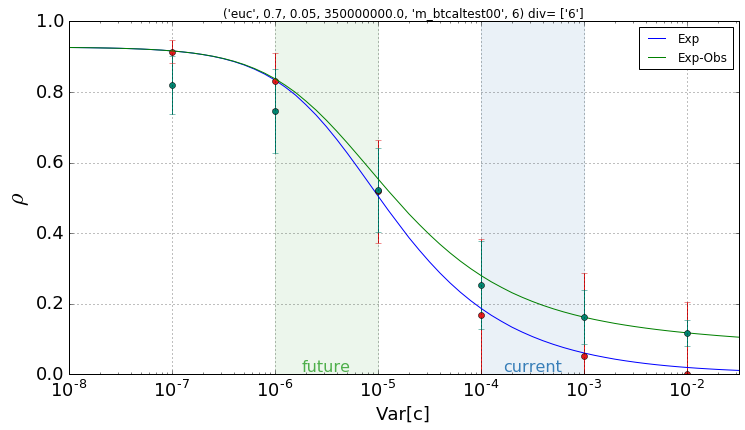

In [270]:
#assuming many realizations of maps have been run, read in the rho data
# and return an array which can be used to add those points to a plot
#for compatibility with pre-lmintest data, if recminelllist.size==1, no lmin tag
def m_caltest_getrhodat_fromfiles(varlist,shape='g',width=10.,lmin=0,lmax=50,recminelllist=np.array([2]),varname='rho',
                                  fromObs=False, getunmod=True, div=['33'], testdir='m_btcaltest00_m_eucbintest'):
    Nvar=len(varlist)
    #read in rho values
    modnames=[gmc.getmodtag_fixedvar(v,shape,lmin,lmax,width) for v in varlist if v!=0]
    #this was shifting the data to the right in the plot. Not sure best way to address unmod...
    if getunmod:
        modnames = modnames + ['unmod']
    mapdir='output/'+testdir+'/map_output/'
    outrho=[]
    counter=0
    if fromObs:
        fromObsStr = '-fromObs'
    else:
        fromObsStr = ''
    for recminell in recminelllist:
        reclminstr="-lmin{0:02d}".format(recminell)
#         iswREC.euc6bins050div33.g10_var1.00e-03_0l50-fromObs.fullsky-lmin02.eucbintest6s05033.s.dat
        files=['iswREC.euc6bins050div{4}.{0:s}{3:s}.fullsky{2:s}.eucbintest6s050{4}.{1:s}.dat'.format(modname,varname,reclminstr,fromObsStr,div[0]) for modname in modnames] 
#         files=['iswREC.eucz07.{0:s}.fullsky{2:s}.depthtest.{1:s}.dat'.format(modname,varname,reclminstr) for modname in modnames]
        #append fiducial case (no cal error) for that lmin
#         if getunmod:
#             files.append('iswREC.eucz07.unmod.fullsky{1:s}.depthtest.{0:s}.dat'.format(varname,reclminstr))
        rhogrid=np.array([au.read_rhodat_wfile(mapdir+f) for f in files])#filesxrho
        outrho.append(rhogrid)
    outrho=np.array(outrho)
    return outrho #[lmin,calerror,realization]
# /Users/nw/Codes/git_test/isw_recon/output/m_btcaltest00_m_eucbintest/map_output/iswREC.euc6bins050div33.g10_var1.00e-07_0l50.fullsky-lmin02.eucbintest6s05033.rho.dat

def m_caltest_getdataplot_forshapecompare(varname='rho',varlist=[],shapelist=['g'],widthlist=[10.],lminlist=[0],lmaxlist=[50],labellist=[''],
                                          cleanplot=False,recminelllist=np.array([2]),colorlist=['#e41a1c'],getlabels=False,getunmod=True,fromObs=False,
                                          div=['33'],testdir='m_btcaltest00_m_eucbintest'):
    """ get dataplotarray (rho of many realizations of many variances of many shapes)
        duplicated from runeuc.caltest_getdataplot_forshapecompare.
        ----
        will return rho data needed for plotting datapoints on caltest plots
        will return 1d list of tuples, in order first of shape, then lminlist
        note that caltest_compare_clcal_shapes functions assumes just one
        or the other of shape and reclmin are varied
        ----
        usage ex from caltest_compare_lmin:
            if dodataplot:
                print 'shortrecminelllist',shortrecminelllist
                datlabellist=[r'$\ell_{{\rm min}}={0:d}$'.format(l) for l in shortrecminelllist]
                dataplot=caltest_getdataplot_forshapecompare(varname,shortvarlist,cleanplot=cleanplot,recminelllist=shortrecminelllist,labellist=datlabellist,colorlist=shortcolorlist,getlabels=justdat)
    """
    print "Reading in rho data"
    #just hard coding these in, since they depend on what realizations
    # I've run, so I don't expect a ton of variation here
    if not varlist:
        varlist=[1.e-6,1.e-5,1.e-4,1.e-3] #for testing datapoints
    if getunmod and 0 not in varlist:
        varlist.append(0.)
    Nvar=len(varlist)
    plotdatalist=[]
    #loop through lists, for each set up a tuple, add to list
    for i in xrange(len(shapelist)):
        shape=shapelist[i]
        caliblmin=lminlist[i]
        caliblmax=lmaxlist[i]
        col=colorlist[i]
        if shape=='g':
            #shapetag=r'Gaussian $C_{{\ell}}^{{\rm cal}}$' 
            shapetag=r'$C_{{\ell}}^{{\rm cal}}\propto e^{{-(\ell/{0:.0f})^2}}$'.format(widthlist[i],caliblmin,caliblmax)
            #shapetag='g{0:d}_{2:d}l{1:d}'.format(int(widthlist[i]),caliblmax,caliblmin)
        elif shape=='l2':
            #shapetag=r'Gaussian $C_{{\ell}}^{{\rm cal}}$' 
            shapetag=r'$C_{{\ell}}^{{\rm cal}}\propto e^{{-(\ell/{0:.0f})^2}}$'.format(widthlist[i],caliblmin,caliblmax)
            #shapetag='l2_{1:d}l{0:d}'.format(caliblmax,caliblmin)
        rhogrid=m_caltest_getrhodat_fromfiles(varlist,shape,widthlist[i],caliblmin,caliblmax,recminelllist,varname,getunmod=getunmod,fromObs=fromObs,div=div,testdir=testdir)#3D: [lmin,calerror,realization]
#         rhogrid=runeuc.caltest_getrhodat_fromfiles(varlist,shape,widthlist[i],caliblmin,caliblmax,recminelllist,varname,getunmod=getunmod)#3D: [lmin,calerror,realization]
        #if getunmod last entry in calerror dimension is value for no calibration error
        print 'shape: ',rhogrid.shape
#         print rhogrid
        Nreal=rhogrid.shape[2]
        Nlmin=rhogrid.shape[0]
        if getlabels and (not labellist[i] and len(recminelllist)==1):
            if cleanplot:
                label='Simulation'
            else:
                label=shapetag+' Nreal={0:d}'.format(Nreal)
        elif len(recminelllist)==1:
            label=labellist[i]
        else:
            label=''
        #find mean, sigmas for each lmin
        means=np.zeros((Nlmin,Nvar))
        refmeans=np.zeros(Nlmin)
        sigs=np.zeros((Nlmin,Nvar))
        for k in xrange(Nlmin):
            if Nlmin!=1:
                label=labellist[k]
            if len(shapelist)==1: #colors not being used for shapes, just lmin
                col=colorlist[k%len(colorlist)]
            means[k,:]=np.array([np.mean(rhogrid[k,j,:]) for j in xrange(Nvar)])
            print zip(varlist, means[k,:])
            print varlist[1]
            print (max(rhogrid[k,1,:]), min(rhogrid[k,1,:]))
            print rhogrid[k,1,:]
            if getunmod:
                refmeans[k]=np.mean(rhogrid[k,-1,:])
            else:
                refmeans[k]=-100 #nonsense value so we don't use it by mistake
            sigs[k,:]=np.array([np.std(rhogrid[k,j,:]) for j in xrange(Nvar)])
            plotdatalist.append((varlist,means[k,:],label,col,sigs[k,:],refmeans[k],Nreal))
    #(datvar,datrho,datlabel,datcol,datsig),...]

    return plotdatalist

def m_plot_datafiles(varname='rho', plotExpected=True):
        
#         mylabel='o:{0}, f_obs={1}'.format(myw_obs,f_cl_obs)
#             ax1.plot(varlist,this_bcal_rholist,label=mylabel)
    #         print fidcl.nbar
    #     print this_bcal_rholist[0]
    #         if plotbaseline:
    #             base_rho_list = m_calbin_get_rhoexp(fidcl=fidcl,finestN=finestN,div=div,survtype=survtype, varlist=varlist,
    #                                                     lmax=50,lmin=0,shape=calshape_obs, width=myw_obs, calspecs_model=calspecs_model,
    #                                                     overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
    #                                                     nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
    #                                                      fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=0)
    #         ax1.plot(varlist,base_rho_list,'--',label='o:{0}, Unmodeled'.format(myw_obs))
    
    
#     Obs_datplot = m_caltest_getdataplot_forshapecompare(varname=varname) # WILL NEED TO INPUT PARAMETERS HERE
    shortvarlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2] #var[c] value to simulate
    varlist = list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=.1,Nperlog=10))
    mydiv=['6']
    my_fxcorr=0 #NOTE THIS IS NOT YET CODED INTO THE NAME OF FILES SO DON'T CHANGE FROM 0 UNTIL THAT'S DONE 170209 NJW
    mycalspecs = CalibSpecs()     
        
    my_cl_fid,survinfol = getcalbin_fidcl_survinfo(div=mydiv) #get fiducial cl and surv_info_list describing surveys in the fidcl  

    colorlist=['black','#018571','#80cdc1','#a6611a']
    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
    for fromObs in [False,True]:
        
        if plotExpected:
            # DON'T THINK THIS CAN HANDLE MORE THAN ONE ENTRY IN RECMINELLLIST RIGHT NOW [170216 NJW]
            my_reclist=m_calbin_get_reclist(my_cl_fid, survinfol, mycalspecs, varlist=varlist, recminelllist=np.array([2]), useObsCl=fromObs, addfiducial=False) #len = len(varlist)*len(recminelllist)
            lssbins = get_maps_from_reclist(my_reclist)#my_recdat.includeglm
            print '\nrectag = ',my_reclist[0].rectag
            print 'lssbins= ',lssbins

            #construct map-mod combos for the variances given
            mapmods_list = runeuc.caltest_getmapmods_multibin(lssbins, varlist, mycalspecs.lmaxcal,mycalspecs.lmincal,mycalspecs.shape,mycalspecs.width)
            assert len(mapmods_list)==len(my_reclist), (len(mapmods_list),len(my_reclist))
        #     mapmods = runeuc.caltest_getmapmods_multibin(lssbins, [var], mycalspecs.lmaxcal,mycalspecs.lmincal,mycalspecs.shape,mycalspecs.width)
            #[(bintagA, modtag0),(bintagB,modtag0),...]
            print '\nmapmods_list = ',mapmods_list
#             myclmod=gmc.apply_additive_caliberror_tocl(my_cl_fid, mapmods_list, f_xcorr=my_fxcorr)#, insert_isw_modtag=True) #i think leave out isw_modtag, yes?

    #         recdat = au.RecData(includeglm=lssbins,inmaptag=m_binarr_to_labels(lssbins),minl_forrec=reclmin)
            #generate calibration errors with fixed variance, spread through Cl lmin-lmax
            clmodlist=[]
            #same length as varlist: [[(bintagA, modtag0),(bintagB,modtag0)], [(bintagA,modtag1),(bintagB,modtag1),...]]
            for mapmods in mapmods_list:
                clmod=gmc.apply_additive_caliberror_tocl(my_cl_fid, mapmods, f_xcorr=my_fxcorr)#, insert_isw_modtag=True) #i think leave out isw_modtag, yes?
                clmodlist.append(clmod)
#               print 'mapmodslist ',myclmod.mapmodslist

    #         # include fidicual cl as last entry
    #         if varlist[-1]!=0. and dofidrec:
    #     #         print "  appending fiducial case, no calib error"
    #             varlist.append(0.)
    #             clmodlist.append(fidcl)
#             Nrec=len(mapmods_list)
            Nrec=len(my_reclist)
            rho_list = [0]*Nrec
            for r,recdat in enumerate(my_reclist):
                if fromObs:
                    recCl = copy.deepcopy(clmodlist[r]) #we know the calib errors and model them exactly
                else: recCl = copy.deepcopy(my_cl_fid) #we don't know calib errors - use fiducial Cl
                if varname=='rell':
                    rho_list[r]=au.compute_rell_fromcl(clmodlist[r],recdat,reccldat=recCl,varname=varname,fitbias=fitbias)
                else:
                    rho_list[r]=au.compute_rho_fromcl(clmodlist[r],recdat,reccldat=recCl,varname=varname,fitbias=fitbias)
                if type(rho_list[r])==float:
                    rhoarray=np.array(rho_list) #if varname is estop or rell, we're getting a list of lists instead of rho or s, so not a number and can't set array.
#                 else: print type(rho_list[r])
    #         #if save, write to file
    #         if saverho:
    #             f=open(outdir+datfile,'w')
    #             f.write('Multi calib error test: Clcal shape={0:s}, ell={1:d}-{2:d}, z0_base={3:.2d} (var(c)={4:.2e}), z0_sup={5:.2d}\n'.format(shape,lmin,lmax,z0_base,basevar,z0_sup))
    #             f.write('sup var(c(nhat))   <{0:s}>\n'.format(varname))
    #             f.write(''.join(['{0:.2e} {1:8.3f}\n'.format(varlist[i],rhoarray[i]) for i in xrange(Nrec)]))
    #             f.close()
            mylab = 'Exp'
            if fromObs:
                mylab += '-Obs'
            ax1.plot(varlist, rho_list, label=mylab)

#         my_short_reclist = m_calbin_get_reclist(my_cldat, surv_info_list, mycalspecs, varlist=shortvarlist, recminelllist=np.array([2]), useObsCl=fromObs, addfiducial=True)
        print fromObs
        datplot = m_caltest_getdataplot_forshapecompare(varname=varname, varlist=shortvarlist, fromObs=fromObs, div=mydiv) # WILL NEED TO INPUT PARAMETERS HERE
        for i in xrange(len(datplot)):
            datvar=datplot[i][0]#array
            datrho=datplot[i][1]#array
            datlabel=datplot[i][2] #string
            datNreal=0
            datcol=datplot[i][3]
            datsig=datplot[i][4]         
            datrefmean=datplot[i][5]
            if len(datplot[i])>5:
                datNreal=datplot[i][6]
            if not datcol:
                datcol=colorlist[0]
            if fromObs:
                datalabel = datlabel + '-fromObs'
                datcol=colorlist[1]
            print (datvar, datplot)
            ax1.errorbar(datvar,datrho,yerr=datsig,label=datlabel,color=datcol,linestyle='None',marker='o')   
    ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
#         plt.show()
    ax1.legend(loc='best')
#     ax1.set_xlim(min(varlist),max(varlist))
#     plt.title('CalShape tests for {0} survey. Shapes: O:{4}, M:{5}. fitbias={2}, f_x={1}, f_0={3}, div={6}'.format(survtype,f_xcorr,fitbias,f_cl_obs,calshape_obs,calshape_mod,div[0]))
#     print survinfol #of form [(SurvSpecs, ['divstring']), (SurvSpecs, ['divstring'])]
#     print survinfol[0][0].print_specs()
    survtitles = [str(surv.get_specs()) + ' div= {0}'.format(dv) for (surv, dv) in survinfol]
    plt.title(''.join(survtitles))
    plt.show()
    return
    
# print m_caltest_getrhodat_fromfiles(varlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2])
m_plot_datafiles()

In [ ]:
divstrrr,rhoarrayyy = m_bintest_get_rhoexp(finestN=6,z0=0.7,sigz=0.05,overwrite=False,doplot=True,getdivs=['all'],saverho=False,varname='rho',outtag='m_bt_full',survtype='euc')

In [ ]:
divstrrr,rhoarrayyy = m_bintest_get_rhoexp(finestN=6,z0=0.7,sigz=0.05,overwrite=False,doplot=True,getdivs=['222'],saverho=False,varname='rho',outtag='m_bt_full',survtype='euc')

In [ ]:
def f_e_slope(z):
    """faint-end slope of luminosity function. dN/N = c(n) = ln(10)*s(z)*d(mag_lim). This form from Huterer et al (2012) calib errors unleashed.
    Survey dep, but captures that higher redshift higher errors for same mag limit.
    Can apply this to diff bins."""
    return 0.094 + 0.155*z + 0.165*z*z
def maglim_to_varc(dmag_lim, z):
    """dN/N = c(n) = ln(10)*s(z)*d(mag_lim)
    var[c] = <c(n)^2>
    Then scaling of var[c](z=2.25)/var[c](z=0.3) = 8.2, or ~10 between closest and furthest bins in a 6bin euclid survey."""
    cn = dmag_lim * f_e_slope(z) * 2.302585 #ln(10) = 2.302585
    return cn*cn #var[c] = <c(n)^2>

In [ ]:
f_e_slope(.75)

In [ ]:

def m_get_modCl(recdat=False, fidcl=False, varlist=[], calspecs=False, f_xcorr=0):
    """add calib error Cls to fidcl, by map in recdat.includeglm. Does list, with variances specified
    by varlist and shape defined by calspecs_model object.
    Return: (varlist, clmodlist) """
#     print '\nIn calbin_get_rhoexp. finestN = ',finestN
    plotdir='output/m_caltest_plots/'
    if len(varlist)==0:
        varlist = list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=.1,Nperlog=10))
    else: varlist=varlist[:] #was encountering some accidental changes to varlist outside function scope with fidrec. Make sure to pass a copy.
    lssbins=recdat.includeglm
#     print '\nin get_rhoexp, recdat.inlcudeglm== ',lssbins
#     if calspecs_model==False: #what model we're assuming Cl_cal takes
#         calspecs_model = CalibSpecs(shape=shape, width=width,lmaxcal=lmax,lmincal=lmin)
    fidcl=copy.deepcopy(fidcl)    
    #generate calibration errors with fixed variance, spread through Cl lmin-lmax
    clmodlist=[]
    #construct map-mod combos for the variances given
    mapmods_list = runeuc.caltest_getmapmods_multibin(lssbins, varlist, calspecs.lmaxcal,calspecs.lmincal,calspecs.shape,calspecs.width)
    #same length as varlist: [[(bintagA, modtag0),(bintagB,modtag0)], [(bintagA,modtag1),(bintagB,modtag1),...]]
    for mapmods in mapmods_list:
        clmod=gmc.apply_additive_caliberror_tocl(fidcl, mapmods, f_xcorr)
        clmodlist.append(clmod)
    return (varlist, clmodlist)


def m_calbin_get_rhoexp(recdat=False, fidcl=False, z0=0.7,sigz=0.05,finestN=6,div=[],survtype='euc', varlist=[],
                        lmax=50,lmin=1,shape='g',width=10., calspecs_model=False,
                         overwrite=False,doplot=True,saverho=True,varname='rho',filetag='',reclmin=2,
                        nolmintag=False,dofidrec=False,nbar='default',outtag='', #if knowClCal=True, use recCl = true Cl (including ClCal) instead of fidCl
                         fitbias=True, get_Clfid=False,get_Clmod=False, f_xcorr=0, f_cl_obs=0):
    """get <rho> as a list corresponding to calib errors contained in varlist applied to lss maps passed in lssbins.
    If lssbins undefined, uses z0, sigz and survtype to create survey and split into finestN evenly spaced bins.
    Note that f_xcorr controls how much cross correlation between bins (=1 corresponds to sqrt of product of calib errors in each bin).
    f_cl_obs is what fraction of varlist (which goes in Cl_obs) is assumed in Cl_model"""
#     print '\nIn calbin_get_rhoexp. finestN = ',finestN
    plotdir='output/m_caltest_plots/'
    if len(varlist)==0:
        varlist = list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=.1,Nperlog=10))
    else: varlist=varlist[:] #was encountering some accidental changes to varlist outside function scope with fidrec. Make sure to pass a copy.
    
    if not recdat: #compute for the bins split according to div
        assert len(div)==1 and div!=['all']#can only handle one binning scheme
#         if div==['all']: div=['1'*finestN] #if passed all for get_rhoexp, convert to just getting finest number of bins 
#         print 'Creating recdat for div={0}'.format(div)
        print(finestN, z0, sigz, div, survtype, reclmin)
        recdat=m_bintest_get_reclist(finestN, z0, sigz, getdivs=div, survtype=survtype, minl_forrec=reclmin)[0]
        
    else: assert len(div)==0 #make sure not passing division thinking it will use it
    lssbins=recdat.includeglm

#     print '\nin get_rhoexp, recdat.inlcudeglm== ',lssbins
    if calspecs_model==False: #what model we're assuming Cl_cal takes
        calspecs_model = CalibSpecs(shape=shape, width=width,lmaxcal=lmax,lmincal=lmin)
    
#     print calspecs_model.get_specs()
    if not fidcl:
        assert z0!=0
        if len(div)==0 or div==['1'*finestN]:
            print 'No Cl object given. Calling multi_get_Cl...'
    #         fidcl=multi_get_Cl(justread=not(overwrite),z0vals=set(z0_vals), nbar=nbar, outtag=outtag)
            fidcl = m_bintest_get_baseClvals(finestN,z0,sigz,justread=not overwrite,outtag=outtag,survtype=survtype,nbar=nbar)
        else:
            #manually toggle this to true if we don't already have them calc'd since take a very long time
            print 'Calling get Combo Clvals...'
            fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=not overwrite,outtag=outtag,survtype=survtype)
#         if not single_map:
#             assert all([fidcl.clcomputed_forpair(lss_b1,lss_b2) for (lss_b1,lss_b2) in getCombos(lssbins, size=2)]) #verify all cls computed
    else: fidcl=copy.deepcopy(fidcl)    

    #generate calibration errors with fixed variance, spread through Cl lmin-lmax
    clmodlist=[]
    #construct map-mod combos for the variances given

    mapmods_list = runeuc.caltest_getmapmods_multibin(lssbins, varlist, lmax,lmin,shape,width)
    #same length as varlist: [[(bintagA, modtag0),(bintagB,modtag0)], [(bintagA,modtag1),(bintagB,modtag1),...]]
    if f_cl_obs: #do the Cl_model modifications based on assumed magnitude of calib errors (if 0 don't need to do)
        varlist_model = [f_cl_obs*var for var in varlist]
        clmodlist_model=[]
        mapmods_list_model = runeuc.caltest_getmapmods_multibin(lssbins, varlist_model, calspecs_model.lmaxcal, calspecs_model.lmincal, calspecs_model.shape, calspecs_model.width)
        for mapmods_model in mapmods_list_model:
            clmod_model=gmc.apply_additive_caliberror_tocl(fidcl, mapmods_model, f_xcorr)
            clmodlist_model.append(clmod_model)
            
#         print 'clmodlist_model and regs lengths: {0}, {1}'.format(len(clmodlist_model),len(clmodlist))
#         print '\nmod cl for varc:',varlist_model[-10]
#         print clmodlist_model[-10].cl[3,:30]

#         print mapmods_list_model
    for mapmods in mapmods_list:
        clmod=gmc.apply_additive_caliberror_tocl(fidcl, mapmods, f_xcorr)
        clmodlist.append(clmod)
        
#     print 'clmodlist_model and regs lengths: {0}, {1}'.format(len(clmodlist_model),len(clmodlist))
#     print '\nobs cl:'
#     print clmodlist[-10].cl[3,:30]
#     print mapmods_list
#     clmodtest = m_get_modCl(recdat, fidcl, varlist, calspecs_model, f_xcorr)[1] #testing above function to verify works
#     assert clmodtest[3].cl[5,5] == clmodlist[3].cl[5,5], zip(clmodlist[3].cl[:,5], clmodtest[3].cl[:,5])

#     print 'total survey nbar/10^6: ',sum(fidcl.nbar/10.**6)
#     print '\n(binmap, nbar/10^6): \n',zip(fidcl.bintaglist,fidcl.nbar*10**-6)
#     print '\n(binmap, nbar/10^6): \n',zip(fidcl.bintaglist,fidcl.nbar*10**-6)
    
    if varlist[-1]!=0. and dofidrec:
        varlist.append(0.)
        clmodlist.append(fidcl)
    # return array of shape [Nvar,Nell]
    Nrec=len(varlist)
    rho_list = [0]*Nrec

    for r in xrange(Nrec):
#         print '\n--ON VAR=',varlist[r],'---------'
#         if f_cl_obs==1:
#             recCl = copy.deepcopy(clmodlist[r]) #we know the magnitude of calib errors exactly, so used observed Cls.
            #^^ antiquated now that can have diff shapes etc.
        if f_cl_obs==0:
            recCl = copy.deepcopy(fidcl) #we assume no residual calib errors
        else: #f_cl_obs defines what fraction of residual errors we're accounting for.
            recCl = clmodlist_model[r]
        if varname=='rell':
            rho_list[r]=au.compute_rell_fromcl(clmodlist[r],recdat,reccldat=recCl,varname=varname,fitbias=fitbias)
        else:
#             print 'Calculating rho_list for reconstruction {0}'.format(r)
            rho_list[r]=au.compute_rho_fromcl(clmodlist[r],recdat,reccldat=recCl,varname=varname,fitbias=fitbias)
#             print zip(clmodlist[r].crosspairs,clmodlist[r].cl[:,4]-recCl.cl[:,4])
#             print recCl.cl[:,4]
    
#     print rho_list[0]
#     print type(rho_list[0])
#     print np.array(rho_list)
        #         print 'fidcl tags:',fidcl.bintaglist
    #if save, write to file
    if saverho:
        f=open(outdir+datfile,'w')
        f.write('Multi calib error test: Clcal shape={0:s}, ell={1:d}-{2:d}, z0_base={3:.2d} (var(c)={4:.2e}), z0_sup={5:.2d}\n'.format(shape,lmin,lmax,z0_base,basevar,z0_sup))
        f.write('sup var(c(nhat))   <{0:s}>\n'.format(varname))
        f.write(''.join(['{0:.2e} {1:8.3f}\n'.format(varlist[i],rho_list[i]) for i in xrange(Nrec)]))
        f.close()

    if doplot:
        try:
            fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
            shapestr=getShapeStr(lmin=lmin,lmax=lmax,width=width,shape=shape)
            rhoarray=np.array(rho_list)
#             runeuc.caltest_rhoexpplot(varlist,rhoarray,varname=varname,outtag=shapestr,plotdir=plotdir)
            ax1.plot(varlist,rhoarray)#,label='Calib. errors accounted for')
            ax1.plot(np.array([]),np.array([]),linestyle='--',color='black',label='Calib. errors accounted for')
            ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
            plt.show()
        except Exception as e: print '!! Cannot plot due to error:',e
    result = [rho_list]
    if get_Clfid: result.append(fidcl)
    if get_Clmod: result.append(clmodlist)
    if len(result) > 1: return result
    else: return result[0] #if only rho_list, return rho_list straight instead of nested in another list
####--------- cell 2

In [ ]:
# this is irrelevant now if just using observation instead of model
def allbincal_vary_modelcal(calshape_obs='g', calshape_mod='g', width_obs_list=[10], z0=0.7,sigz=0.05,finestN=6,div=[],f_xcorr=0,f_cl_obs_list=[0,1],varlist=[],
                            survtype='euc',reclmin=2,
                             nbar=3.5e8,outtag='m_btcaltest00',varname='rho',fitbias=True,show=True, plotbaseline=True):
    """Plot with calib errors of diff widths. Depreciated since can just used observed data and don't need to mess with model"""
#     numbins_list = list(factors(finestN)) #e.g. [1,2,3,6]
    if len(div)==0:
        div=['1'*finestN]
    if len(varlist)==0: varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))
    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
#     print div_list
#     print nbar
    fidcl = m_bintest_get_combo_Clvals(finestN=finestN,z0=z0,sigz=sigz,getdivs=div,nbar=nbar,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
    for i,myw_obs in enumerate(width_obs_list):
        for j,f_cl_obs in enumerate(f_cl_obs_list):
            #model calib error specs
            calspecs = CalibSpecs(calshape_obs, myw_obs) #lmax=50 by default 
            
            this_bcal_rholist=m_calbin_get_rhoexp(fidcl=fidcl,finestN=finestN,div=div,survtype=survtype, varlist=varlist,
                                                lmax=50,lmin=0,shape=calshape_obs, width=myw_obs, calspecs_model=calspecs,
                                                overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                                nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                                 fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
    #         if i<len(reclssbins_list)-1: mylabel = reclssbins
    #         else: mylabel = 'all'
            mylabel='o:{0}, f_obs={1}'.format(myw_obs,f_cl_obs)
            ax1.plot(varlist,this_bcal_rholist,label=mylabel)
            print this_bcal_rholist[-10]
#         print fidcl.nbar
#     print this_bcal_rholist[0]
#         if plotbaseline:
#             base_rho_list = m_calbin_get_rhoexp(fidcl=fidcl,finestN=finestN,div=div,survtype=survtype, varlist=varlist,
#                                                     lmax=50,lmin=0,shape=calshape_obs, width=myw_obs, calspecs_model=calspecs_model,
#                                                     overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
#                                                     nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
#                                                      fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=0)
#         ax1.plot(varlist,base_rho_list,'--',label='o:{0}, Unmodeled'.format(myw_obs))
    ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
    ax1.set_xlim(min(varlist),max(varlist))
    plt.title('CalShape tests for {0} survey. Shapes: O:{4}, M:{5}. fitbias={2}, f_x={1}, f_0={3}, div={6}'.format(survtype,f_xcorr,fitbias,f_cl_obs,calshape_obs,calshape_mod,div[0]))
    if show:
        plt.show
    


#160915 ---- YOU ARE HERE -- CHANGING MOD SHAPE AND WIDTH DOESN'T SEEM TO DO ANYTHING. NEED TO SEE WHY.
#161110 -- changing Gaussian width works. l2 doesnt. Oh duh - can't change width param of l2, right? Only one free param -- amplitude.

#allbincal_vary_modelcal(calshape_obs='l2', width_obs_list=[5,10,20],f_xcorr=0,varname='rho')

In [ ]:
#depreciated
# allbincal_vary_modelcal(calshape_obs='g',calshape_mod='g', width_obs_list=[10], width_mod_list=[5,10,20], f_cl_obs=1,f_xcorr=0,varname='rho')
# allbincal_vary_modelcal(calshape_obs='g',calshape_mod='g', width_obs_list=[5,10,20], width_mod_list=[10], f_cl_obs=1,f_xcorr=0,varname='rho')

In [ ]:
## YOU ARE HERE 161120, BUILDING PAPER PLOT WITH EUC_1BIN, EUC_6BIN, EACH WITH AND WITHOUT CALIB ACCOUNTED FOR
def paper_euc_plot(calshape_obs='g', width_obs=10, z0=0.7, sigz=0.05, finestN=6, div=[], f_xcorr=0, varlist=[],
                            survtype='euc', reclmin=2, nbar=3.5e8, outtag='m_btcaltest00',varname='rho',
                           fitbias=False,show=True):
    """Plot isw recon stats using ultimate survey split into six bins compared with individual bin recons"""
#     numbins_list = list(factors(finestN)) #e.g. [1,2,3,6]
    if len(div)==0:
        div=['1'*finestN]
    if len(varlist)==0: varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))
    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
#     print div_list
#     print nbar
    calspecs_model = CalibSpecs(calshape_obs, myw_mod) #lmax=50 by default 
    fidcl = m_bintest_get_combo_Clvals(finestN=finestN,z0=z0,sigz=sigz,getdivs=div,nbar=nbar,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
    #model calib error specs
    calspecs_model = CalibSpecs(calshape_mod, myw_mod) #lmax=50 by default 

    this_bcal_rholist=m_calbin_get_rhoexp(fidcl=fidcl,finestN=finestN,div=div,survtype=survtype, varlist=varlist,
                                        lmax=50,lmin=0,shape=calshape_obs, width=myw_obs, calspecs_model=calspecs_model,
                                        overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                        nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                         fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
#         if i<len(reclssbins_list)-1: mylabel = reclssbins
#         else: mylabel = 'all'
    mylabel='o:{0}, m:{1}'.format(myw_obs,myw_mod)
    ax1.plot(varlist,this_bcal_rholist,label=mylabel)
    print this_bcal_rholist[-10]
#         print fidcl.nbar
#     print this_bcal_rholist[0]
    if plotbaseline:
        base_rho_list = m_calbin_get_rhoexp(fidcl=fidcl,finestN=finestN,div=div,survtype=survtype, varlist=varlist,
                                                lmax=50,lmin=0,shape=calshape_obs, width=myw_obs, calspecs_model=calspecs_model,
                                                overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                                nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                                 fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=0)
        ax1.plot(varlist,base_rho_list,'--',label='o:{0}, Unmodeled'.format(myw_obs))
    ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
    ax1.set_xlim(min(varlist),max(varlist))
    plt.title('CalShape tests for {0} survey. Shapes: O:{4}, M:{5}. fitbias={2}, f_x={1}, f_0={3}, div={6}'.format(survtype,f_xcorr,fitbias,f_cl_obs,calshape_obs,calshape_mod,div[0]))
    if show:
        plt.show
        
#---

# compare limber vs nonlimber on same plot!
# def paper_euc_bins_plot(f_xcorr=0,varname='rho',doFullLimber=False, div=['111111']):
#     """Plot isw recon stats using ultimate survey split into six bins compared with individual bin recons"""
#     z0=0.7
#     sigz=0.05
#     finestN=6
#     f_cl_obs_list=[0.001,0.1,1,10.,100.]
#     varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))
#     survtype='euc'
#     reclmin=2
#     nbar='default'
#     fitbias=True
#     show=True
    
#     out20='m_btcaltest00'
#     outexact='nolimber_test'
#     outlimber='alllimber_test'
#     llim_list=[20,-1,0]
#     lstyle_list=['-','--',':']
#     #colormap jazz for coordinating plot colors
#     cm=plt.get_cmap('hsv')#Spectral') #Dark2')#
#     cNorm=runeuc.colors.LogNorm(vmin=min(f_cl_obs_list), vmax=max(f_cl_obs_list)) #max and min numbers colors need to span
#     scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
    
#     fidcl_l20 = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=out20,survtype=survtype) #get fiducial Cl's for even-split bins
#     fidcl_exact = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outexact,survtype=survtype) #get fiducial Cl's for even-split bins
#     fidcl_limber = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outlimber,survtype=survtype) #get fiducial Cl's for even-split bins

#     fidcl_list = [fidcl_l20,fidcl_exact]
#     if doFullLimber: fidcl_list.append(fidcl_limber)
    
#     fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
    
#     rholist_arr = np.zeros((len(f_cl_obs_list),3,len(varlist)))
#     for i,f_cl_obs in enumerate(f_cl_obs_list):
#         for j,myfidcl in enumerate(fidcl_list):
#             llim=llim_list[j]
#             this_bcal_rholist=m_calbin_get_rhoexp(fidcl=myfidcl,div=div,survtype=survtype, varlist=varlist,
#                                             lmax=50,lmin=2,shape='g',width=10.,
#                                             overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
#                                             nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
#                                             fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
# #             rholist_list.append(this_bcal_rholist)
#             rholist_arr[i,j,:]=np.array(this_bcal_rholist)
            
# #         if i<len(reclssbins_list)-1: mylabel = reclssbins
# #         else: mylabel = 'all'
#             mylabel='{0:.2f}, llim={1}'.format(f_cl_obs,llim)
#             mycol=scalarMap.to_rgba(f_cl_obs)
#             mystyle=lstyle_list[j]
#             ax1.plot(varlist,this_bcal_rholist,mystyle,color=mycol,label=mylabel)
# #             print this_bcal_rholist[0]
#     ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
#     ax1.set_xlim(min(varlist),max(varlist))
#     plt.title('{0} survey, div= {3}, fitbias={2}, f_xcorr={1}, various f_cl_obs'.format(survtype,f_xcorr,fitbias,div))
#     plt.show()
    
#     fig2, ax2 = calplotsetup(size=(12,7))#(8.5,5))
# #     limber20diff_rho = [ex-lim for (ex,lim) in zip(rholist_list[1],rholist_list[0])] #just as a double check since this uses limber calcs from before I tightened the integration constraints
#     limber20diff_rho = rholist_arr[:,1,:]-rholist_arr[:,0,:] #just as a double check since this uses limber calcs from before I tightened the integration constraints
# #     print limberdiff_rho.shape
#     for i,f_cl_obs in enumerate(f_cl_obs_list):
#         lab2='{0:.2f}, lim20old'.format(f_cl_obs)
#         mycol=scalarMap.to_rgba(f_cl_obs)
#         ax2.plot(varlist,limber20diff_rho[i,:],'--',color=mycol,label=lab2)
#         if doFullLimber:
#             lab1='{0:.2f}, limdiff'.format(f_cl_obs)
#             #     limberdiff_rho = [ex-lim for (ex,lim) in zip(rholist_list[1],rholist_list[2])]
#             limberdiff_rho = rholist_arr[:,1,:]-rholist_arr[:,2,:]
#             ax2.plot(varlist,limberdiff_rho[i,:],'-',color=mycol,label=lab1)
            
#     ax2=calplotform(ax2,varname=varname, showregions=True) #format like caltest plot
#     ax2.set_xlim(min(varlist),max(varlist))
#     maxdiff = np.max(np.abs(limber20diff_rho))
#     if doFullLimber: maxdiff= max(maxdiff, np.max(np.abs(limberdiff_rho)))
# #     maxdiff = max([abs(elem) for elem in limberdiff_rho+limber20diff_rho])
#     ax2.set_ylim(-maxdiff,maxdiff)
#     plt.title('<rho> differences. {0} survey, div= {3}, fitbias={2}, f_xcorr={1}, various f_cl_obs'.format(survtype,f_xcorr,fitbias,div))
#     plt.show()

In [ ]:

#ULTIMATE PLOT!
def bincal_ult_plot(recdat=False, z0=0.7,sigz=0.05,finestN=6,div=[],f_xcorr=0,f_cl_obs=0,survtype='euc',reclmin=2,
                    nbar='default',outtag='m_bt_full_caltest',varname='rho',fitbias=True,show=True):
    """Plot isw recon stats using ultimate survey split into bins according to getdivs and finestN, and combo recon compared with individual bin recons.
    If recdat passed, compare the individual bins to the combo."""

    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=.1,Nperlog=10))
    
    if not recdat: #compute for the bins split according to div
        if len(div)==0:
            div=[finestN*'1'] #if not passed, bin according to finestN and compare with individ with all together

        assert len(div)==1
        mtype=runeuc.bintest_get_maptypelist(finestN,div,z0,sigz,includeisw=False,survtype=survtype)[0]
        lssbins=[b.tag for b in mtype.binmaps] #list of lssbin tags, one for each bin
    else:
        lssbins=recdat.includeglm
    print lssbins
     #need to build up our own reclist, which includes recons with only single bins, followed by combined.
    reclist = [au.RecData(includeglm=[lssbin],inmaptag=lssbin,minl_forrec=reclmin) for lssbin in lssbins] #individual bins
    reclist.append(au.RecData(includeglm=lssbins, inmaptag=mtype.tag, minl_forrec=reclmin)) #all bins together
#     print 'in ultplot, recdat.includglm= ',lssbins
#     (fidbins,maptypes) = m_bintest_get_binmaps(finestN,z0=z0,sigz=sigz,includeisw=False,justfinest=True,survtype=survtype,getMaptypes=True)
# #     print 'maptypes:',maptypes
#     lssbins = [fb.tag for fb in fidbins if fb.isGal]
# #     print lssbins
#     #get list of sublists with recon tags. Indivuals followed by combined: [[bin1],[bin2]...,[binN],[bin1,bin2,...,binN]]:
    reclssbins_list = [[lssbin] for lssbin in lssbins] + [lssbins]


#     reclist=[m_bintest_get_reclist(finestN, z0, sigz, getdivs=['1'*finestN], survtype=survtype, minl_forrec=reclmin)[0]]
    if len(div)==0 or div==['1'*finestN]:
        fidcl = m_bintest_get_baseClvals(finestN,z0,sigz,justread=True,outtag=outtag,survtype=survtype,nbar=nbar) #get fiducial Cl's for even-split bins
#         print '\n 1) fidcl bintaglist:',fidcl.bintaglist
    else: 
        print 'getting Combo Cls'
#         print div
        fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
#         print '\n 2) fidcl bintaglist:',fidcl.bintaglist
    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
    for i,myrecdat in enumerate(reclist):
        this_bcal_rholist=m_calbin_get_rhoexp(recdat=myrecdat, fidcl=fidcl,survtype=survtype, varlist=varlist,
                                            lmax=50,lmin=0,shape='g',width=10.,
                                            overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                            nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                             fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
        if i<len(reclist)-1: mylabel = myrecdat.includeglm
        else: mylabel = 'all'
#         print varlist
#         print
#         print this_bcal_rholist
        ax1.plot(varlist,this_bcal_rholist,label=mylabel)
#     print this_bcal_rholist[0]
    ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
    plt.title('Individual vs Combo bins for {0} survey, f_xcorr={1}, f_cl_obs={2}'.format(survtype,f_xcorr,f_cl_obs))
    if show:
        plt.show()
    print 'total survey nbar/10^6: ',sum(fidcl.nbar/10.**6)
    print '\n(binmap, nbar/10^6): \n',zip(fidcl.bintaglist,fidcl.nbar*10**-6)
    
#     bcalrholist=m_calbin_get_rhoexp(lssbins=False, fidcl=False, z0=0.7,sigz=0.05,finestN=6,survtype='euc', varlist=varlist,
#                          overwrite=False,doplot=False,saverho=False,varname='rho',filetag='',reclmin=2,
#                         nolmintag=False,dofidrec=False,nbar='default',outtag=outtag,knowClCal=False, #if knowClCal=True, use recCl = true Cl (including ClCal) instead of fidCl
#                          fitbias=True, get_Clfid=False,get_Clmod=False, f_xcorr=0)

#     shapestr=getShapeStr(lmin=lmin,lmax=lmax,width=width,shape=shape)
#     #             runeuc.caltest_rhoexpplot(varlist,rhoarray,varname=varname,outtag=shapestr,plotdir=plotdir)
#     ax1.plot(varlist,rhoarray)#,label='Calib. errors accounted for')
#     ax1.plot(np.array([]),np.array([]),linestyle='--',color='black',label='Calib. errors accounted for')

if 0:
    bincal_ult_plot(div=['6'],f_cl_obs=1,outtag='nolimber_test',fitbias=True,varname='s')
    bincal_ult_plot(div=['6'],f_cl_obs=1,outtag='nolimber_test',fitbias=False,varname='s')
    bincal_ult_plot(div=['6'],f_cl_obs=0,outtag='nolimber_test',fitbias=True,varname='s')
    bincal_ult_plot(div=['6'],f_cl_obs=0,outtag='nolimber_test',fitbias=False,varname='s')



In [ ]:
bincal_ult_plot(div=['111111'],f_cl_obs=1,outtag='nolimber_test')
bincal_ult_plot(div=['222'],f_cl_obs=1,outtag='nolimber_test')
bincal_ult_plot(div=['33'],f_cl_obs=1,outtag='nolimber_test')
bincal_ult_plot(div=['6'],f_cl_obs=1,outtag='nolimber_test')


In [ ]:
if 0:
    bincal_ult_plot(f_cl_obs=0,outtag='nolimber_test')
#     bincal_ult_plot(f_cl_obs=0)
#     bincal_ult_plot(f_cl_obs=0,outtag='alllimber_test')
    bincal_ult_plot(f_cl_obs=.5,outtag='nolimber_test')
    bincal_ult_plot(f_cl_obs=1,outtag='nolimber_test')
    bincal_ult_plot(f_cl_obs=0,f_xcorr=.5,outtag='nolimber_test')
    bincal_ult_plot(f_cl_obs=1,f_xcorr=.5,outtag='nolimber_test')
#     bincal_ult_plot(f_cl_obs=1)
#     bincal_ult_plot(f_cl_obs=1,outtag='alllimber_test')
# bincal_ult_plot(f_cl_obs=1)


In [ ]:
#Comparing single bin vs combined bins, we see that we do get the improvement per bin by combining (and so increasing nbar,)
bincal_ult_plot(f_cl_obs=0,div=['222'])
bincal_ult_plot(f_cl_obs=1,div=['222'])

In [ ]:

# Combo bintest vs var[c]. Compare total recon using diff number of bins (ignore individual bins).
#Is this still valid to approx all calib error by median binwidth?
#Will that be the main differentiator, and is that valid?
# --------  9/9/16 ----------- you are here (and haven't implemented the z-dependent var[c] function higher up yet) -- decided against, since complicates how we display info and faint-end slope is up for debate anyways.

def allbincal_vary_binnum(z0=0.7,sigz=0.05,finestN=6,div_list=[],f_xcorr=0,f_cl_obs=0,varlist=[],survtype='euc',reclmin=2,
                             nbar=3.5e8,outtag='m_btcaltest00',varname='rho',fitbias=True,show=True):
    """Plot isw recon stats using ultimate survey split into six bins compared with individual bin recons"""
    numbins_list = list(factors(finestN)) #e.g. [1,2,3,6]
    if len(div_list)==0:
        for numbins in numbins_list: #get all possible evenly spaced binnumbers built from finestN
            div_list.append([str(numbins)*(finestN/numbins)])
    if len(varlist)==0: varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))
    if outtag==False:
        if survtype=='euc': outtag='m_btcaltest00'
        elif survtype=='spx': outtag=''
    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
#     print div_list
#     print nbar
    fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=['equal'],nbar=nbar,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
    for i,mydiv in enumerate(div_list):
        this_bcal_rholist=m_calbin_get_rhoexp(fidcl=fidcl,finestN=finestN,div=mydiv,survtype=survtype, varlist=varlist,
                                            lmax=50,lmin=0,shape='g',width=10.,
                                            overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                            nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                             fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
#         if i<len(reclssbins_list)-1: mylabel = reclssbins
#         else: mylabel = 'all'
        mylabel='{0:.2f}'.format(f_cl_obs)
        ax1.plot(varlist,this_bcal_rholist,label=mydiv)
#         print fidcl.nbar
#     print this_bcal_rholist[0]
    ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
    ax1.set_xlim(min(varlist),max(varlist))
    plt.title('Bin tests for {0} survey, fitbias={2}, f_xcorr={1}, f_cl_obs={3}'.format(survtype,f_xcorr,fitbias,f_cl_obs))
    if show:
        plt.show()

In [ ]:
def allbincal_vary_f_xcorr(cl_in=False, z0=0.7,sigz=0.05,finestN=6,div=[],f_xcorr_list=[0,.01,0.1,0.2,0.5,.9,1],varlist=[],f_cl_obs=0,survtype='euc',reclmin=2,
                           nbar='default',outtag='m_btcaltest00',varname='rho',fitbias=True,show=True):
    """Plot isw recon stats using ultimate survey split into six bins compared with individual bin recons"""
    if len(div)==0: div=['1'*finestN] #do for finest bins by default
    if len(varlist)==0: varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))

#     (fidbins,maptypes) = m_bintest_get_binmaps(finestN,z0=z0,sigz=sigz,includeisw=False,justfinest=True,survtype=survtype,getMaptypes=True)
#     print 'maptypes:',maptypes
#     reclssbins = [fb.tag for fb in fidbins if fb.isGal]
    if cl_in:
        fidcl=cl_in
        print 'using passed, cl, plotting title may be wrong!'
    else:
        fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins

    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
#     print fidcl.bintaglist
    print survtype
    for i,f_xcorr in enumerate(f_xcorr_list):
        
        this_bcal_rholist=m_calbin_get_rhoexp(fidcl=fidcl,z0=z0,sigz=sigz, div=div, survtype=survtype, varlist=varlist,
                                            lmax=50,lmin=0,shape='g',width=10.,
                                            overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                            nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                             fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
#         if i<len(reclssbins_list)-1: mylabel = reclssbins
#         else: mylabel = 'all'
        mylabel='{0}'.format(f_xcorr)
        ax1.plot(varlist,this_bcal_rholist,label=mylabel)
    print this_bcal_rholist[0]
    ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
    ax1.set_xlim(min(varlist),max(varlist))
    plt.title('{0} survey,div= {3}, fitbias={2}, f_cl_obs={1}, various f_xcorr'.format(survtype,f_cl_obs,fitbias,div))
    if show:
        plt.show()
        
def binning_subplots(z0=0.7,sigz=0.05,finestN=6,div_list=[],f_xcorr_list=[0,.1,.5,.9],f_cl_obs_list=[0,1],varlist=[],survtype='euc',reclmin=2,
                             nbar=3.5e8,outtag='m_btcaltest00',varname='rho',fitbias=True,show=True,figscalar=6,title=False,model_on_x=False):
    """Plot isw recon stats using ultimate survey split into six bins compared with individual bin recons.
    varytype can be 'bins' or 'shapes'. """
    #print subplots in grid with varying f_xcorr and f_cl_obs. estop_lss_id is if varname='estop', then need to pick which lss map we're returning the estimator for
    #https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
    if len(varlist)==0:
        varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=.1,Nperlog=10))
    N_f_xcor = len(f_xcorr_list)
    N_f_cl_obs = len(f_cl_obs_list)
    numbins_list = list(factors(finestN)) #e.g. [1,2,3,6]
    
    if len(div_list)==0:
        for numbins in numbins_list: #get all possible evenly spaced binnumbers built from finestN. Note that numbins is the number of SUBbins in each bin in the final (not combined total number)
            div_list.append([str(numbins)*(finestN/numbins)])
            
    fig, axes = plt.subplots(nrows=N_f_cl_obs, ncols=N_f_xcor, sharex=False, sharey=False) #note I switched the rows and columns from the heat plots for computational puproses 160914
    print 'len(axes)=',len(axes.flat)
    fig.set_size_inches(N_f_xcor*figscalar,N_f_cl_obs*figscalar)
    
#     this_fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
#     fidcl = m_bintest_get_baseClvals(finestN,z0,sigz,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
    print 'Computing {0}...'.format(varname)
    j=0
    fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=['equal'],nbar=nbar,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
    for myf_cl_obs in f_cl_obs_list:
        varlist_model = [myf_cl_obs*var for var in varlist]
        for myf_xcorr in f_xcorr_list:
            print 'on f_xcorr = {0}, f_cl_obs = {1}'.format(myf_xcorr,myf_cl_obs)
            ax1 = axes.flat[j]
#             fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
        #     print div_list
        #     print nbar
            for i,mydiv in enumerate(div_list):
                this_bcal_rholist=m_calbin_get_rhoexp(fidcl=fidcl,z0=z0,sigz=sigz,finestN=finestN,div=mydiv,survtype=survtype, varlist=varlist,
                                                    lmax=50,lmin=0,shape='g',width=10.,
                                                    overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                                    nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                                     fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr= myf_xcorr, f_cl_obs=myf_cl_obs)
        #         if i<len(reclssbins_list)-1: mylabel = reclssbins
        #         else: mylabel = 'all'
#                 mylabel='{0:.2f}'.format(myf_cl_obs)
                binsintot = finestN/numbins_list[i]
                if myf_cl_obs!=0 and model_on_x:
                    ax1.plot(varlist_model,this_bcal_rholist,label=binsintot)
                    xlab='Var[c]_model'
                else:
                    ax1.plot(varlist,this_bcal_rholist,label=binsintot)
                    xlab='Var[c]'
        #         print fidcl.nbar
        #     print this_bcal_rholist[0]
            ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
            ax1.set_xlim(min(varlist),max(varlist))
            ax1.set_xlabel(xlab)
#             plt.title('Bin tests for {0} survey, fitbias={2}, f_xcorr={1}, f_cl_obs={3}'.format(survtype,f_xcorr,fitbias,f_cl_obs))
#             if show:
#                 plt.show()
            j+=1

    if len(axes)>1:
        for ax, col in zip(axes[0], f_xcorr_list):
            ax.set_title('f_xcorr= {0}'.format(col))

        for ax, row in zip(axes[:,0], f_cl_obs_list):
            ax.set_ylabel('f_Cl_obs= {0}'.format(row), rotation=90, size='large')
            
    if not title:
#         title = 'Correlation by multipole b/n true and recon ISW, z0={0}, div={2}, fitbias={1}'.format(z0,fitbias,div)
        title = ' {2}, {3}-like survey, z0={0}, sigz={4}, fitbias={1}'.format(z0,fitbias,varname,survtype,sigz)
    fig.suptitle(title, size='x-large')
#     fig.tight_layout()
    
    if show: plt.show()
    return fig

def binsubs_spx(sigz=0.1, nbar='default', f_xcorr_list=[0,.1,.5,.9], f_cl_obs_list=[0,1], fitbias=True, reclmin=2):
    ms = getsurv_spx(sigz, nbar=nbar)
    fig = binning_subplots(div_list=[], f_xcorr_list=f_xcorr_list, f_cl_obs_list=f_cl_obs_list, reclmin=reclmin,
                     z0=ms.z0,sigz=ms.sigz,finestN=ms.finestN, survtype=ms.survtype,outtag=ms.outtag, nbar=nbar,
                    varname='rho',varlist=[], fitbias=fitbias, show=True, figscalar=6, title=False, model_on_x=False)
    return fig


In [ ]:
def factors(n):    
    """get all integer factors of n""" #from https://stackoverflow.com/questions/6800193/what-is-the-most-efficient-way-of-finding-all-the-factors-of-a-number-in-python
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

# allbincal_vary_binnum()
if 0: #12 bin case
    mydivlist=[['111111111111'],['222222'],['3333'],['444'],['66']]
    allbincal_vary_binnum(outtag='m_btcaltest_12bin',f_xcorr=.9,finestN=12,div_list=mydivlist)
if 0:
#     mydivlist=[['111111111111'],['222222'],['3333'],['444'],['66']]
    for myf_xcorr in [0,.1,.5,.9]:
        allbincal_vary_binnum(f_xcorr=myf_xcorr)
# -------- YOU ARE HERE ------------
# nbar is not percolating through it seems like. Added it to the bintest_get_maptypes, but this only gets the tags to use in get_binlist...
#so where does nbar enter in? Didn't I check this above by printing out and making sure the bins were separating appropriately? Ah yes, I htink they are,
#the combo bins nbar is just appended to nbar list. Is it referencing the correct ones? Still need to find where to change overall nbar for survey.
# 160912 NJW
#I THINK THIS IS FIXED #NJW 170105

In [ ]:
# fig1=binning_subplots(f_xcorr_list=[0,.9],f_cl_obs_list=[0,10])
fig1 = binsubs_spx()
fig1=binning_subplots()
# fig1=binning_subplots(model_on_x=False,f_xcorr_list=[0,.5,.9], fitbias=True, varname='rho')


In [ ]:
fig1=binning_subplots(nbar=10.**11,model_on_x=False,f_xcorr_list=[0,.5,.9], fitbias=True, varname='rho')

In [208]:
#this is not yet made into shapewidth subplots
def shapewidth_subplots(z0=0.7,sigz=0.05,finestN=6,div_list=[],f_xcorr_list=[0,.1,.5,.9],f_cl_obs_list=[0,.1,1,10,100],varlist=[],survtype='euc',reclmin=2,
                             nbar=3.5e8,outtag='m_btcaltest00',varname='rho',fitbias=True,show=True,figscalar=6,title=False,model_on_x=False):
    """Plot isw recon stats using ultimate survey split into six bins compared with individual bin recons.
    varytype can be 'bins' or 'shapes'. """
    #print subplots in grid with varying f_xcorr and f_cl_obs. estop_lss_id is if varname='estop', then need to pick which lss map we're returning the estimator for
    #https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
    if len(varlist)==0:
        varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=.1,Nperlog=10))
    N_f_xcor = len(f_xcorr_list)
    N_f_cl_obs = len(f_cl_obs_list)
    numbins_list = list(factors(finestN)) #e.g. [1,2,3,6]
    
    if len(div_list)==0:
        for numbins in numbins_list: #get all possible evenly spaced binnumbers built from finestN. Note that numbins is the number of SUBbins in each bin in the final (not combined total number)
            div_list.append([str(numbins)*(finestN/numbins)])
            
    fig, axes = plt.subplots(nrows=N_f_cl_obs, ncols=N_f_xcor, sharex=False, sharey=False) #note I switched the rows and columns from the heat plots for computational puproses 160914
    print 'len(axes)=',len(axes.flat)
    fig.set_size_inches(N_f_xcor*figscalar,N_f_cl_obs*figscalar)
    
#     this_fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
#     fidcl = m_bintest_get_baseClvals(finestN,z0,sigz,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
    print 'Computing {0}...'.format(varname)
    j=0
    fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=['equal'],nbar=nbar,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
    for myf_cl_obs in f_cl_obs_list:
        varlist_model = [myf_cl_obs*var for var in varlist]
        for myf_xcorr in f_xcorr_list:
            print 'on f_xcorr = {0}, f_cl_obs = {1}'.format(myf_xcorr,myf_cl_obs)
            ax1 = axes.flat[j]
#             fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
        #     print div_list
        #     print nbar
            for i,mydiv in enumerate(div_list):
                this_bcal_rholist=m_calbin_get_rhoexp(fidcl=fidcl,finestN=finestN,div=mydiv,survtype=survtype, varlist=varlist,
                                                    lmax=50,lmin=0,shape='g',width=10.,
                                                    overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                                    nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                                     fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr= myf_xcorr, f_cl_obs=myf_cl_obs)
        #         if i<len(reclssbins_list)-1: mylabel = reclssbins
        #         else: mylabel = 'all'
#                 mylabel='{0:.2f}'.format(myf_cl_obs)
                binsintot = finestN/numbins_list[i]
                if myf_cl_obs!=0 and model_on_x:
                    ax1.plot(varlist_model,this_bcal_rholist,label=binsintot)
                    xlab='Var[c]_model'
                else:
                    ax1.plot(varlist,this_bcal_rholist,label=binsintot)
                    xlab='Var[c]'
        #         print fidcl.nbar
        #     print this_bcal_rholist[0]
            ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
            ax1.set_xlim(min(varlist),max(varlist))
            ax1.set_xlabel(xlab)
#             plt.title('Bin tests for {0} survey, fitbias={2}, f_xcorr={1}, f_cl_obs={3}'.format(survtype,f_xcorr,fitbias,f_cl_obs))
#             if show:
#                 plt.show()
            j+=1

    if len(axes)>1:
        for ax, col in zip(axes[0], f_xcorr_list):
            ax.set_title('f_xcorr= {0}'.format(col))

        for ax, row in zip(axes[:,0], f_cl_obs_list):
            ax.set_ylabel('f_Cl_obs= {0}'.format(row), rotation=90, size='large')
            
    if not title:
#         title = 'Correlation by multipole b/n true and recon ISW, z0={0}, div={2}, fitbias={1}'.format(z0,fitbias,div)
        title = '{3}-like survey, z0={2}, z0={0}, fitbias={1}'.format(z0,fitbias,varname,survtype)
    fig.suptitle(title, size='x-large')
#     fig.tight_layout()
    
    if show: plt.show()
    return fig

# fig1=binning_subplots(f_xcorr_list=[0,.9],f_cl_obs_list=[0,10])
if 0: 
    fig1=binning_subplots()

In [ ]:
#calc 12bin Cls!!
fidcl_12=m_bintest_get_baseClvals(finestN=12,z0=0.7,sigz=0.05,justread=True,outtag='m_btcaltest_12bin',survtype='euc')

In [ ]:

def allbincal_vary_model_err(cl_in=False,z0=0.7,sigz=0.05,finestN=6,div=[],f_xcorr=0,f_cl_obs_list=[0,.01,0.1,0.5,1,2.,10.,100.],varlist=[],survtype='euc',reclmin=2,
                             nbar='default',outtag='m_btcaltest00',varname='rho',fitbias=True,show=True,model_on_x=False):
    """Plot isw recon stats using ultimate survey split into six bins compared with individual bin recons"""
    if len(div)==0: div=['1'*finestN] #do for finest bins
    if len(varlist)==0: varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))

#     (fidbins,maptypes) = m_bintest_get_binmaps(finestN,z0=z0,sigz=sigz,includeisw=False,justfinest=True,survtype=survtype,getMaptypes=True)
# #     print 'maptypes:',maptypes
#     reclssbins = [fb.tag for fb in fidbins if fb.isGal]
#     if div==['1'*finestN]: needCombos=False
#     fidcl = m_bintest_get_baseClvals(finestN,z0,sigz,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
    if cl_in:
        fidcl=cl_in
        print 'using passed, cl, plotting title may be wrong!'
    else:
        fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins

    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))

    for i,f_cl_obs in enumerate(f_cl_obs_list):
        this_bcal_rholist=m_calbin_get_rhoexp(fidcl=fidcl,div=div,survtype=survtype, varlist=varlist,
                                            lmax=50,lmin=0,shape='g',width=10.,
                                            overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                            nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                             fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
#         if i<len(reclssbins_list)-1: mylabel = reclssbins
#         else: mylabel = 'all'
        mylabel='{0:.2f}'.format(f_cl_obs)
        if model_on_x and f_cl_obs!=0:
            varlist_model = [f_cl_obs*var for var in varlist]
            xlab='Var[c]_model'
            ax1.plot(varlist_model,this_bcal_rholist,label=mylabel)
        else:
            if f_cl_obs==0:
                lstyle='--'
            else: lstyle='-'
            xlab='Var[c]'
            ax1.plot(varlist,this_bcal_rholist,lstyle,label=mylabel)
    print this_bcal_rholist[0]
    ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
    ax1.set_xlim(min(varlist),max(varlist))
    ax1.set_xlabel(xlab)
    plt.title('{0} survey, div= {3}, fitbias={2}, f_xcorr={1}, various f_cl_obs'.format(survtype,f_xcorr,fitbias,div))
    if show:
        plt.show()
    

In [ ]:
def getplot_allbincal(cl_in, recdat, ax=None, f_xcorr=0, varlist=[],f_cl_obs=0, nbar='default',
                      varname='rho',fitbias=True,show=False,shape='g',width=10.,label=None,labelsuf='', linestyle='-'):
    """Add rho plot to given axis. Create if none passed"""
    if len(varlist)==0: varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))
    
    fidcl=cl_in
    this_bcal_rholist=m_calbin_get_rhoexp(recdat=recdat, fidcl=fidcl,varlist=varlist,
                                        lmax=50,lmin=0, shape=shape,width=width, 
                                        overwrite=False,doplot=False,saverho=False,varname=varname,filetag='', nolmintag=False, dofidrec=False,nbar=nbar,outtag=outtag,
                                         fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
#         if i<len(reclssbins_list)-1: mylabel = reclssbins
#         else: mylabel = 'all'
    if label==None:
        label=recdat.maptag
    label += labelsuf
    if ax==None:
        fig, ax = calplotsetup(size=(12,7))#(8.5,5))
    ax.plot(varlist,this_bcal_rholist,label=label,ls=linestyle)
    if show:
        plt.show()
    
def plot_surveys(f_xcorr=0, f_cl_obs=0, ax=None, div=['6'], fitbias=True, shape='g', varname='rho', labelsuf='', linestyle='-', nbar5e8=False):
    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))
    first =False
    if ax==None:
        fig, ax = calplotsetup(size=(12,7))#(8.5,5))
        ax.set_title('fx = {0}, f_obs={1}, shape={2}'.format(f_xcorr, f_cl_obs, shape))
        first=True
#     plotlist = [(getCl_sx(sigz=0.1), getRecDat_sx(0.1)), (getCl_sx(sigz=0.03), getRecDat_sx(0.03)), (getCl_sx(sigz=0.1), getRecDat_sx(0.1)), ]
    
    if nbar5e8==False: mynbar=5e8
        
    cl_euc = m_bintest_get_combo_Clvals(outtag='m_btcaltest00', getdivs=div) #get fiducial euc Cl's for even-split bins
    recdat_euc = m_bintest_get_reclist(getdivs=div, minl_forrec=2)[0] #default
    
    if 1: #do euc
        getplot_allbincal(cl_euc, recdat_euc, ax=ax, f_xcorr=f_xcorr, f_cl_obs=f_cl_obs, fitbias=fitbias, shape=shape,
                          varname=varname, varlist=varlist, labelsuf=labelsuf,linestyle=linestyle)
    if 0: #plot SX 0.1
        getplot_allbincal(getCl_sx(sigz=0.1, div=div), getRecDat_sx(0.1, div=div), ax=ax, f_xcorr=f_xcorr, f_cl_obs=f_cl_obs, fitbias=fitbias, shape=shape,
                          varname=varname, varlist=varlist, labelsuf=labelsuf,linestyle=linestyle)
    if 0: #plot SX 0.1, nbar=5e8
        getplot_allbincal(getCl_sx(sigz=0.1, div=div,nbar=5e8), getRecDat_sx(0.1, div=div,nbar=5e8), ax=ax, f_xcorr=f_xcorr, f_cl_obs=f_cl_obs, fitbias=fitbias, shape=shape,
                          varname=varname, varlist=varlist, labelsuf=labelsuf+'_5e8',linestyle=linestyle)
    if 0: #plot SX 0.03
        getplot_allbincal(getCl_sx(sigz=0.03, div=div), getRecDat_sx(0.03, div=div), ax=ax, f_xcorr=f_xcorr, f_cl_obs=f_cl_obs, fitbias=fitbias, shape=shape,
                          varname=varname, varlist=varlist, labelsuf=labelsuf,linestyle=linestyle)
#     if first:
    ax=calplotform(ax,varname=varname, showregions=True) #format like caltest plot
    ax.set_xlim(min(varlist),max(varlist))
    return ax        


myax = plot_surveys(f_xcorr=.8, f_cl_obs=0, linestyle='--')
# plot_surveys(f_xcorr=.8, f_cl_obs=1, ax=myax, labelsuf='_obs')
# plot_surveys(f_xcorr=.5, f_cl_obs=1, ax=myax, labelsuf='_obs_.5', linestyle='--')
plt.show()


In [ ]:
if 0:
    print 'Residuals UNCORRELATED'
    allbincal_vary_model_err(f_xcorr=0,model_on_x=True)
    print 'Residuals 95% CORRELATED'
    allbincal_vary_model_err(f_xcorr=.9,model_on_x=True)
#     allbincal_vary_model_err(f_xcorr=.5,fitbias=False)

    print 'Residual magnitude UNACCOUNTED for'
    allbincal_vary_f_xcorr(f_cl_obs=0)
    print 'Residual magnitude 50% ACCOUNTED for'
    allbincal_vary_f_xcorr(f_cl_obs=0.5,f_xcorr_list=[0,.1,.2,.5,.9])
    print 'Residual magnitude ACCOUNTED for'
    allbincal_vary_f_xcorr(f_cl_obs=1,f_xcorr_list=[0,.1,.2,.5,.9])




In [ ]:
# myvarlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=10000000,Nperlog=10))
myvarlist=[1e-8,1e-4,1.]
print 'Residual magnitude ACCOUNTED for'
allbincal_vary_f_xcorr(f_cl_obs=1,f_xcorr_list=[0,.95,1],div=['33'],varlist=myvarlist)
# print 'Residual magnitude UNACCOUNTED for'
# allbincal_vary_f_xcorr(f_cl_obs=.5,f_xcorr_list=[.95,1],div=['33'],varlist=myvarlist)

In [ ]:
if 0:
    mydiv=['33']
    print 'Residuals 95% CORRELATED'
    allbincal_vary_model_err(f_xcorr=.95, div=mydiv)
    allbincal_vary_model_err(f_xcorr=.95, div=mydiv,fitbias=False)
    print 'Residuals 100% CORRELATED'
    allbincal_vary_model_err(f_xcorr=1, div=mydiv)
    allbincal_vary_model_err(f_xcorr=1, div=mydiv,fitbias=False)

# do diff plots with limber l at different levels. This is superceded below where we look at actual difference and plot together    
if 0:
    for mydiv in [['33'],['111111']]:
        print mydiv
        print 'Residuals 95% CORRELATED'
        for myfitbias in [True,False]:
            print '\nLimber l = 20:'
            allbincal_vary_model_err(f_xcorr=.95, div=mydiv,fitbias=myfitbias, show=False)
            print '\nLimber l = 96 (no limber):'
            allbincal_vary_model_err(f_xcorr=.95, div=mydiv,fitbias=myfitbias,outtag='nolimber_test',show=False)
            print '\nLimber l = 0 (ALL limber):'
            allbincal_vary_model_err(f_xcorr=.95, div=mydiv,fitbias=myfitbias,outtag='alllimber_test',show=False)
            plt.show()


In [ ]:
# test calib error shapes


In [ ]:

# compare limber vs nonlimber on same plot!
def lvnl_allbincal_vary_model_err(f_xcorr=0,varname='rho',doFullLimber=False, div=['111111']):
    """Plot isw recon stats using ultimate survey split into six bins compared with individual bin recons"""
    z0=0.7
    sigz=0.05
    finestN=6
    f_cl_obs_list=[0.001,0.1,1,10.,100.]
    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))
    survtype='euc'
    reclmin=2
    nbar='default'
    fitbias=True
    show=True
    
    out20='m_btcaltest00'
    outexact='nolimber_test'
    outlimber='alllimber_test'
    llim_list=[20,-1,0]
    lstyle_list=['-','--',':']
    #colormap jazz for coordinating plot colors
    cm=plt.get_cmap('hsv')#Spectral') #Dark2')#
    cNorm=runeuc.colors.LogNorm(vmin=min(f_cl_obs_list), vmax=max(f_cl_obs_list)) #max and min numbers colors need to span
    scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
    
    fidcl_l20 = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=out20,survtype=survtype) #get fiducial Cl's for even-split bins
    fidcl_exact = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outexact,survtype=survtype) #get fiducial Cl's for even-split bins
    fidcl_limber = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outlimber,survtype=survtype) #get fiducial Cl's for even-split bins

    fidcl_list = [fidcl_l20,fidcl_exact]
    if doFullLimber: fidcl_list.append(fidcl_limber)
    
    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
    
    rholist_arr = np.zeros((len(f_cl_obs_list),3,len(varlist)))
    for i,f_cl_obs in enumerate(f_cl_obs_list):
        for j,myfidcl in enumerate(fidcl_list):
            llim=llim_list[j]
            this_bcal_rholist=m_calbin_get_rhoexp(fidcl=myfidcl,div=div,survtype=survtype, varlist=varlist,
                                            lmax=50,lmin=0,shape='g',width=10.,
                                            overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                            nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
                                            fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
#             rholist_list.append(this_bcal_rholist)
            rholist_arr[i,j,:]=np.array(this_bcal_rholist)
            
#         if i<len(reclssbins_list)-1: mylabel = reclssbins
#         else: mylabel = 'all'
            mylabel='{0:.2f}, llim={1}'.format(f_cl_obs,llim)
            mycol=scalarMap.to_rgba(f_cl_obs)
            mystyle=lstyle_list[j]
            ax1.plot(varlist,this_bcal_rholist,mystyle,color=mycol,label=mylabel)
#             print this_bcal_rholist[0]
    ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
    ax1.set_xlim(min(varlist),max(varlist))
    plt.title('{0} survey, div= {3}, fitbias={2}, f_xcorr={1}, various f_cl_obs'.format(survtype,f_xcorr,fitbias,div))
    plt.show()
    
    fig2, ax2 = calplotsetup(size=(12,7))#(8.5,5))
#     limber20diff_rho = [ex-lim for (ex,lim) in zip(rholist_list[1],rholist_list[0])] #just as a double check since this uses limber calcs from before I tightened the integration constraints
    limber20diff_rho = rholist_arr[:,1,:]-rholist_arr[:,0,:] #just as a double check since this uses limber calcs from before I tightened the integration constraints
#     print limberdiff_rho.shape
    for i,f_cl_obs in enumerate(f_cl_obs_list):
        lab2='{0:.2f}, lim20old'.format(f_cl_obs)
        mycol=scalarMap.to_rgba(f_cl_obs)
        ax2.plot(varlist,limber20diff_rho[i,:],'--',color=mycol,label=lab2)
        if doFullLimber:
            lab1='{0:.2f}, limdiff'.format(f_cl_obs)
            #     limberdiff_rho = [ex-lim for (ex,lim) in zip(rholist_list[1],rholist_list[2])]
            limberdiff_rho = rholist_arr[:,1,:]-rholist_arr[:,2,:]
            ax2.plot(varlist,limberdiff_rho[i,:],'-',color=mycol,label=lab1)
            
    ax2=calplotform(ax2,varname=varname, showregions=True) #format like caltest plot
    ax2.set_xlim(min(varlist),max(varlist))
    maxdiff = np.max(np.abs(limber20diff_rho))
    if doFullLimber: maxdiff= max(maxdiff, np.max(np.abs(limberdiff_rho)))
#     maxdiff = max([abs(elem) for elem in limberdiff_rho+limber20diff_rho])
    ax2.set_ylim(-maxdiff,maxdiff)
    plt.title('<rho> differences. {0} survey, div= {3}, fitbias={2}, f_xcorr={1}, various f_cl_obs'.format(survtype,f_xcorr,fitbias,div))
    plt.show()
#     print limber20diff_rho
    
# def allbincal_vary_f_xcorr(cl_in=False, z0=0.7,sigz=0.05,finestN=6,div=[],f_xcorr_list=[0,0.1,0.2,0.5,.9,1],varlist=[],f_cl_obs=0,survtype='euc',reclmin=2,
#                            nbar='default',outtag='m_btcaltest00',varname='rho',fitbias=True,show=True):
#     """Plot isw recon stats using ultimate survey split into six bins compared with individual bin recons"""
#     if len(div)==0: div=['1'*finestN] #do for finest bins by default
#     if len(varlist)==0: varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=0.1,Nperlog=10))

# #     (fidbins,maptypes) = m_bintest_get_binmaps(finestN,z0=z0,sigz=sigz,includeisw=False,justfinest=True,survtype=survtype,getMaptypes=True)
# #     print 'maptypes:',maptypes
# #     reclssbins = [fb.tag for fb in fidbins if fb.isGal]
#     if cl_in:
#         fidcl=cl_in
#         print 'using passed, cl, plotting title may be wrong!'
#     else:
#         fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins

#     fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))

#     for i,f_xcorr in enumerate(f_xcorr_list):
#         this_bcal_rholist=m_calbin_get_rhoexp(fidcl=fidcl,div=div, survtype=survtype, varlist=varlist,
#                                             lmax=50,lmin=0,shape='g',width=10.,
#                                             overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
#                                             nolmintag=False,dofidrec=False,nbar=nbar,outtag=outtag,
#                                              fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=f_xcorr,f_cl_obs=f_cl_obs)
# #         if i<len(reclssbins_list)-1: mylabel = reclssbins
# #         else: mylabel = 'all'
#         mylabel='{0}'.format(f_xcorr)
#         ax1.plot(varlist,this_bcal_rholist,label=mylabel)
#     print this_bcal_rholist[0]
#     ax1=calplotform(ax1,varname=varname, showregions=True) #format like caltest plot
#     ax1.set_xlim(min(varlist),max(varlist))
#     plt.title('{0} survey,div= {3}, fitbias={2}, f_cl_obs={1}, various f_xcorr'.format(survtype,f_cl_obs,fitbias,div))
#     if show:
#         plt.show()


In [ ]:
#test limber approx for various f_xcorr:
if 0:
    lvnl_allbincal_vary_model_err()
    lvnl_allbincal_vary_model_err(f_xcorr=.5)
    lvnl_allbincal_vary_model_err(f_xcorr=.9)

    lvnl_allbincal_vary_model_err(f_xcorr=.5,varname='s')
    lvnl_allbincal_vary_model_err(div=['222'])

In [ ]:
def heatmaps_subplots(f_xcorr_list, f_cl_obs_list, z0=0.7,div=[], survtype='euc', finestN=6,sigz=0.05,varlist=[],title='',
                      fitbias=True,show=True,figscalar=3,outtag='m_btcaltest00', varname='rell', showvar=False, estop_lss_id=0,reclmin=2,plot_lmax=95):
    #print subplots in grid with varying f_xcorr and f_cl_obs. estop_lss_id is if varname='estop', then need to pick which lss map we're returning the estimator for
    #https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
    if len(div)==0: div=['1'*finestN] #do for finest bins by default
    if len(varlist)==0:
        varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=.1,Nperlog=10))
    N_f_xcor = len(f_xcorr_list)
    N_f_cl_obs = len(f_cl_obs_list)
    fig, axes = plt.subplots(nrows=N_f_xcor, ncols=N_f_cl_obs, sharex=False, sharey=False)
    
    fig.set_size_inches(N_f_cl_obs*figscalar, N_f_xcor*figscalar)
    if not plot_lmax:
        plot_lmax=95
    y = np.array(varlist)
    x = np.arange(0,plot_lmax+1)
    X,Y=np.meshgrid(x,y)
    
#     (fidbins,maptypes) = m_bintest_get_binmaps(finestN,z0=z0,sigz=sigz,includeisw=False,justfinest=True,survtype=survtype,getMaptypes=True)
#     reclssbins = [fb.tag for fb in fidbins if fb.isGal]
#     print (finestN,z0,sigz,True,outtag,survtype)
    this_fidcl = m_bintest_get_combo_Clvals(finestN,z0,sigz,getdivs=div,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
#     fidcl = m_bintest_get_baseClvals(finestN,z0,sigz,justread=True,outtag=outtag,survtype=survtype) #get fiducial Cl's for even-split bins
    print 'Computing {0}...'.format(varname)
    i=0
    for myf_xcorr in f_xcorr_list:
        for myf_cl_obs in f_cl_obs_list:
            ax = axes.flat[i]
            this_rell_list = m_calbin_get_rhoexp(fidcl=this_fidcl,div=div,survtype=survtype,finestN=finestN, varlist=varlist, lmax=50,lmin=0,shape='g',width=10.,
                                                overwrite=False,doplot=False,saverho=False,varname=varname,filetag='',reclmin=reclmin,
                                                nolmintag=False,dofidrec=False,outtag=outtag,
                                                 fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=myf_xcorr, f_cl_obs=myf_cl_obs)
            if varname=='estop':
                this_rell_list = np.array([est_var[estop_lss_id,:] for est_var in this_rell_list]) #estop array is shape (N_LSS, N_ell), one for each variance
                im = ax.pcolor(X,Y,this_rell_list[:,:plot_lmax],norm=LogNorm(vmin=this_rell_list[:,reclmin:plot_lmax+1].min(), vmax=this_rell_list[:,reclmin:plot_lmax+1].max()))
#         im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)
            else:
                im = ax.pcolor(X,Y,this_rell_list, vmin=0,vmax=1)
            ax.plot(range(plot_lmax),[10**-4]*plot_lmax,'k--')#,label='Current')
            ax.plot(range(plot_lmax),[10**-6]*plot_lmax,'k-.')#,label='Future')
            if showvar:
                current_rho = m_calbin_get_rhoexp(fidcl=this_fidcl,div=div,survtype=survtype,finestN=finestN, varlist=[10.**-4], lmax=50,lmin=0,shape='g',width=10.,
                                                overwrite=False,doplot=False,saverho=False,varname='rho',filetag='',reclmin=reclmin,
                                                nolmintag=False,dofidrec=False,outtag=outtag,
                                                 fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=myf_xcorr, f_cl_obs=myf_cl_obs)
                ax.plot([],[],label=r'$\rho$={0:.2}'.format(current_rho[0]))
                ax.legend(loc='best')
            ax.set_ylabel('var[c]')
            ax.set_xlabel('Multipole (ell)')
            ax.set_yscale('log')
            i+=1

    if len(axes)>1:
        for ax, col in zip(axes[0], f_cl_obs_list):
            ax.set_title('f_Cl_obs= {0}'.format(col))

        for ax, row in zip(axes[:,0], f_xcorr_list):
            ax.set_ylabel('f_xcorr= {0}'.format(row), rotation=90, size='large')
            
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    if not title:
#         title = 'Correlation by multipole b/n true and recon ISW, z0={0}, div={2}, fitbias={1}'.format(z0,fitbias,div)
        title = '{3}, z0={0}, div={2}, fitbias={1}'.format(z0,fitbias,div,varname)
    fig.suptitle(title, size='x-large')
#     fig.tight_layout()
    
    if show: plt.show()
    return fig


In [ ]:
# Look at r_ell for various combos of f_cl_obs and f_xcorr, for both Fitbias = True and False, for both 6- and 12-bin cases.
# we see the interesting bump appear near current calib levels due to the fitbias step. Fitbias actually hurts us with calibration
if 0:
    fidcl_12=m_bintest_get_baseClvals(finestN=12,z0=0.7,sigz=0.05,justread=False,outtag='m_btcaltest_12bin',survtype='euc')
    myfinestN=12
    thisvarlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=1000,Nperlog=10))
    for n_bins in [6,12]:
        mydiv=[str(myfinestN/n_bins)*n_bins]
        for myfitbias in [False,True]:
            print ' ------ FITBIAS = {0}, N_BINS = {1}'.format(myfitbias,n_bins)
            if n_bins==1: sp = heatmaps_subplots(f_xcorr_list=[0,1], f_cl_obs_list=[0,.1,1,10,100], div=mydiv,varlist=thisvarlist, outtag='m_btcaltest_12bin',finestN=myfinestN,fitbias=myfitbias,show=True,figscalar=4,showvar=True)
            else:    sp = heatmaps_subplots(f_xcorr_list=[0,.5,.9,.95,1], f_cl_obs_list=[0,.1,1,10,100], div=mydiv,varlist=thisvarlist, outtag='m_btcaltest_12bin',finestN=myfinestN,fitbias=myfitbias,show=True,figscalar=4,showvar=True)

In [ ]:
# Similar to above, but look at estimator operator for various f_cl_obs, f_xcorr, for fitbias is true and false.
if 0:
    fidcl_12=m_bintest_get_baseClvals(finestN=12,z0=0.7,sigz=0.05,justread=False,outtag='m_btcaltest_12bin',survtype='euc')
    myfinestN=12
    plot_lmax=30
    for n_bins in [2]:
        mydiv=[str(myfinestN/n_bins)*n_bins]
        for myfitbias in [False,True]:
            print ' ------ FITBIAS = {0}, N_BINS = {1}'.format(myfitbias,n_bins)
            if n_bins==1: sp = heatmaps_subplots(f_xcorr_list=[0,.95,1], f_cl_obs_list=[0,.1,1,10], div=mydiv,varlist=[],varname='estop', outtag='m_btcaltest_12bin',finestN=myfinestN,
                                                 fitbias=myfitbias,show=True,figscalar=4,showvar=True,plot_lmax=plot_lmax)
            else:    sp = heatmaps_subplots(f_xcorr_list=[0,.95,1], f_cl_obs_list=[0,.1,1,10], div=mydiv,varlist=[],varname='estop', outtag='m_btcaltest_12bin',finestN=myfinestN,
                                            fitbias=myfitbias,show=True,figscalar=4,showvar=True,plot_lmax=plot_lmax)


In [ ]:
#plot estimator to see behavior vs varlist, f_xcorr
for myf_xcorr in [.95,1]:
    thisvarlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=10,Nperlog=10))
    this_estop_list = m_calbin_get_rhoexp(div=['33'],survtype='euc',finestN=6, varlist=thisvarlist, lmax=50,lmin=0,shape='g',width=10.,
                                        overwrite=False,doplot=False,saverho=False,varname='estop',filetag='',reclmin=2,
                                        nolmintag=False,dofidrec=False,outtag='m_btcaltest00',
                                         fitbias=fitbias, get_Clfid=False,get_Clmod=False, f_xcorr=myf_xcorr, f_cl_obs=10)
    # this_estop_list = np.array([est_var[0,:] for est_var in this_estop_list]) #estop array is shape (N_LSS, N_ell), one for each variance
    this_estop_list = np.array(this_estop_list) #estop array is shape (N_LSS, N_ell), one for each variance
    print this_estop_list.shape
    plt.plot(thisvarlist,this_estop_list[:,0,4],'r-',label='mapA,l=4')
    plt.plot(thisvarlist,this_estop_list[:,0,8],'b-',label='mapA,l=8')
    plt.plot(thisvarlist,this_estop_list[:,1,4],'r--',label='mapB,l=4')
    plt.plot(thisvarlist,this_estop_list[:,1,8],'b--',label='mapB,l=8')
    plt.xscale('log')
    plt.legend(loc='best')
    plt.grid()
    plt.title('f_xcorr={0}'.format(myf_xcorr))
    plt.xlabel('var[c]')
    plt.ylabel('R_l (estimator)')
    plt.show()
    print len(this_estop_list)

In [ ]:
for myf_xcorr in [0,.5,1]:
    myf_cl_obs=0
    myfitbias=True
    this_rell_list = m_calbin_get_rhoexp(finestN=6,div=['111111'],survtype='euc', lmax=50,lmin=0,shape='g',width=10.,
                                            overwrite=False,doplot=False,saverho=False,varname='rell',filetag='',reclmin=2,
                                            nolmintag=False,dofidrec=False,outtag='m_btcaltest00',
                                             fitbias=myfitbias, get_Clfid=False,get_Clmod=False, f_xcorr=myf_xcorr,f_cl_obs=myf_cl_obs)
    rell_varc_heatmap(rell_list=this_rell_list, title='f_xcorr = {0}, f_cl_obs = {1}, fitbias = {2}'.format(myf_xcorr,myf_cl_obs,myfitbias))

In [ ]:

#this has been subsumed into heamaps_subplots function

# for myf_xcorr in [0,.1,.5]:
#     for myf_cl_obs in [0,.1,1,10,100]:
#         myf_xcorr=.5
#         myfitbias=False
#         this_rell_list = m_calbin_get_rhoexp(finestN=6,div=['111111'],survtype='euc', lmax=50,lmin=0,shape='g',width=10.,
#                                                 overwrite=False,doplot=False,saverho=False,varname='rell',filetag='',reclmin=2,
#                                                 nolmintag=False,dofidrec=False,outtag='m_btcaltest00',
#                                                  fitbias=myfitbias, get_Clfid=False,get_Clmod=False, f_xcorr=myf_xcorr,f_cl_obs=myf_cl_obs)
#         rell_varc_heatmap(rell_list=this_rell_list, title='f_xcorr = {0}, f_cl_obs = {1}, fitbias = {2}'.format(myf_xcorr,myf_cl_obs,myfitbias))


In [ ]:
def m_bintest_get_baseClvals_setlimber(finestN=6,z0=0.7,sigz=0.05,justread=True, outtag='',survtype='euc',bins=[0,2,5],limberl=20):
    binmaps=m_bintest_get_binmaps(finestN,z0=z0,sigz=sigz,justfinest=True,survtype=survtype)
    sub_binmaps=[binmaps[bin_id] for bin_id in bins]
    pairs=[p for p in itertools.combinations_with_replacement([m.tag for m in sub_binmaps],2)]
#     zmax=max(m.zmax for m in binmaps)
    zmax=max(m.zmax for m in sub_binmaps)
    print 'computing for binmaps {0}'.format([m.tag for m in sub_binmaps])
    print 'pairs = ',pairs
    print 'zmax = ',zmax
    rundat = clu.ClRunData(tag='{2}bintest{0:d}s{1:03d}'.format(finestN,int(1000*sigz),survtype),iswilktag='{0}bintest'.format(survtype),
                           rundir='output/'+outtag+'_setlimberl_{1}_m_{0}bintest/'.format(survtype,limberl),lmax=95,zmax=zmax,limberl=limberl)
#     return gcc.getCl(binmaps,rundat,dopairs=['all'],DoNotOverwrite=justread)
    return gcc.getCl(sub_binmaps,rundat,dopairs=pairs,DoNotOverwrite=justread)


In [ ]:
# Used to generate Cl files for later reference. Must set justread=False
if 0:
    for mylimberl in [-1,0]:
        print '\ndoing limberl = ',mylimberl
        cl_nolimber_test=m_bintest_get_baseClvals_setlimber(justread=True,outtag='allbins',limberl=mylimberl,bins=range(7))

In [ ]:
# This is what i did when playing around inside spyder to look at different calibration error forms. Imported Cl data as Pandas dataframe, then run df_rename_cl_cols to change names to be more easily referenced.
l=np.arange(170)
l2=np.power(l,-2.)
l2[0]=0
plt.plot(l,l*l2)
plt.yscale('log')
plt.show()

e=np.power(2.1,-l/10.)/l
plt.plot(l,l*e)
plt.yscale('log')
plt.show()

g=np.exp(-(l/10.)**2)
plt.plot(l,l*g)
plt.yscale('log')
plt.show()
print('unscaled')
plt.plot(l,l2)
plt.show()
plt.plot(l,e)
plt.show()
plt.plot(l,g)
plt.show()

In [ ]:
def df_rename_cl_cols(df):
    """takes in pandas dataframe, renames columns 'euc6bin0-euc6bin4' --> '04' and 'isw_bin0-euc6bin5' --> 'isw5'.
    The source names are just concatenations of the two binnames in the typical output."""
    for oldcol in df.columns[2:]:
        if 'isw' in oldcol:
            df.rename(columns={oldcol:'isw'+oldcol[-1]},inplace=True) #isw is always listed as the first bin in name
        else:
            df.rename(columns={oldcol:oldcol[oldcol.find('bin')+3]+oldcol[-1]},inplace=True)
    return df

clex.rename(columns={'lvals':'l'},inplace=True)
cllim.rename({'lvals':'l'},inplace=True)
cldiff = abs(clex-cllim)
clrel = cldiff/abs(clex)
ran=[(i*5,i*5+5) for i in range(6)] #go through plotting ~5 per plot
ran[-1]=(25,28)

for (si,ei) in ran:
    print (si,ei)
    abs(clex[clex.columns[si+1:ei+1]]).plot(logy=True)
    
for (si,ei) in ran:
    print (si,ei)
    abs(cllim[cllim.columns[si+1:ei+1]]).plot(logy=True)



        
      

In [ ]:
# 161027: DIRECTLY COPIED AND HACKED TO CHANGE AXES, SIZE, AND REMOVE LEGEND FOR PLOT
#==========================================
# plots rho exp and data points for one shape and lmin
#combine stuff from caltest_compare_clcal_shapes with rhoexpplot
def caltest_basic_expplot_forpaper(varname='rho',plotdir='output/plots_forpaper/', savefig=False):
    outname='caltest_'+varname+'_exp_basic.pdf'
    #outname='caltest_'+varname+'_exp_test.pdf'
    colorlist=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']#qualitative
    reclmin=2
    #info about calibration errors
    shape='g'
    width=10.
    lmincal=0#min ell for calib error
    lmaxcal=30#max ell for caliberror

    #what points to plot
    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))
    shortvarlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2]#for data points
    
    #get data
    rhoexplist=[]#will be 1D; [variance ] 
    rhoexplist=runeuc.caltest_get_rhoexp(varlist=varlist,lmax=lmaxcal,lmin=lmincal,shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname=varname,reclmin=reclmin)
    
    #get Nl for rec variance estimate: (161220 NJW)
    rhoexparr = np.array(rhoexplist)
    sig2Ntup_explist = runeuc.caltest_get_rhoexp(varlist=varlist,lmax=lmaxcal,lmin=lmincal,shape=shape,width=width,
                                                 overwrite=False,doplot=False,saverho=False,varname='sigNl_tup',reclmin=reclmin)
    sig2N_exparr = np.array([sig2N[0] for sig2N in sig2Ntup_explist])
    sig2Nrec_exparr = np.array([sig2N[1] for sig2N in sig2Ntup_explist])
    
    #shapestr=r'$C_{{\ell}}^{{\rm cal}}\propto e^{{-(\ell/{0:.0f})^2}}$'.format(width,lmincal,lmaxcal)
    linelabel='Theory (add. only)'
    datplot=runeuc.caltest_getdataplot_forshapecompare(varname,shortvarlist,[shape],[width],[lmincal],[lmaxcal],recminelllist=np.array([reclmin]),colorlist=colorlist,labellist=['Results from sim.'],getunmod=False)
    #setting getunmod=false since we don't need cal=0 reference means

    #do plotting!
    #assuming last entry in varlist, rhoarray is fiducial (var=0)
    fig=plt.figure(figsize=(12,10))
    fig.subplots_adjust(bottom=.2)
    fig.subplots_adjust(left=.175)
    fig.subplots_adjust(right=.95)
    ax1 = plt.subplot() 
    for item in ([ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels()
                  + ax1.get_yticklabels()):
        item.set_fontsize(18)
    for item in ([ax1.yaxis.label]):
        item.set_fontsize(22)
    plt.sca(ax1)
    ax1.grid(True)
    ax1.set_xscale('log')
    ax1.set_xlim((10**-7.5,10**-1.5))
    ax1.set_xlabel(r'Variance of error field, $\sim(\delta m)^2$')
    ax1.axhline(0,color='grey',linestyle='-')
#     if varname=='rho':
#         ax1.set_ylim(0,1)
#         ax1.axhline(1,color='grey',linestyle='-')
#         ax1.set_ylabel(r'Correlation $\rho$')
#     elif varname=='s':
#         ax1.set_ylabel(r'$s$')
#         ax1.set_ylim((.1,3.))

    #fill in regions for current/future values
    nowmin=1.e-4
    nowmax=1.e-3
    nowcenter=10**(.5*(np.log10(nowmin)+np.log10(nowmax)))
    nowlabel='current'
    nowcol='#377eb8'
    futuremin=1.e-6
    futuremax=1.e-5
    futurecenter=10**(.5*(np.log10(futuremin)+np.log10(futuremax)))
    futurelabel='future'
    futurecol='#4daf4a'
    ymin,ymax=ax1.get_ylim()
    #plt.fill_between(varlist[:-1],ymin,ymax, facecolor=nowcol,edgecolor='none',linewidth=2, alpha=0.3)
    ax1.axvspan(nowmin,nowmax,alpha=0.1,color=nowcol)
    plt.annotate(nowlabel,xy=(nowcenter,ymax*.93),horizontalalignment='center',verticalalignment='bottom',fontsize=16,color=nowcol)
    ax1.axvspan(futuremin,futuremax,alpha=0.1,color=futurecol)
    plt.annotate(futurelabel,xy=(futurecenter,ymax*.93),horizontalalignment='center',verticalalignment='bottom',fontsize=16,color=futurecol)
        
    #theory line
#     ax1.plot(varlist[:-1],rhoexplist[:-1],label=linelabel,color=colorlist[0])
    ax1.plot(varlist[:-1],rhoexplist[:-1],color=colorlist[0])
    ax1.plot(varlist[:-1],rhoexparr[:-1] + sig2N_exparr[:-1],color=colorlist[1],ls='--', label='thry var')
    ax1.plot(varlist[:-1],rhoexparr[:-1] - sig2N_exparr[:-1],color=colorlist[1],ls='--')
    ax1.plot(varlist[:-1],rhoexparr[:-1] + sig2Nrec_exparr[:-1],color=colorlist[2],ls='--', label='obs var')
    ax1.plot(varlist[:-1],rhoexparr[:-1] - sig2Nrec_exparr[:-1],color=colorlist[2],ls='--')
    ax1.plot(varlist[:-1],rhoexparr[:-1] + sig2Nrec_exparr[:-1],color=colorlist[2],ls='--', label='sqrt(obs*thry)')
    ax1.plot(varlist[:-1],rhoexparr[:-1] - sig2Nrec_exparr[:-1],color=colorlist[2],ls='--')
    plt.legend()

    ##data points should just have one entry, but copying whole mess anyway
    for i in xrange(len(datplot)):
        datvar=datplot[i][0]#array
        datrho=datplot[i][1]#array
        datlabel=datplot[i][2] #string
        datNreal=0
        datcol=datplot[i][3]
        datsig=datplot[i][4]         
        datrefmean=datplot[i][5]
        if len(datplot[i])>5:
            datNreal=datplot[i][6]
        if not datcol:
            datcol=colorlist[0]
        ax1.errorbar(datvar,datrho,yerr=datsig,label=datlabel,color=datcol,linestyle='None',marker='o')    

        
    plt.sca(ax1)
#     if varname=='rho':
#         plt.legend(fontsize=16,loc='upper right',numpoints=1)
#     elif varname=='s':
#         plt.legend(fontsize=16,loc='upper right',numpoints=1)
    if savefig:
        print 'Saving plot to ',plotdir+outname
        plt.savefig(plotdir+outname)
        plt.close()
    return ax1

In [ ]:
caltest_basic_expplot_forpaper(varname='rho',plotdir='output/plots_forpaper/')